### Visualize W&B results

In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
plt.ioff()  # <- Turn off interactive mode

import matplotlib.gridspec as gridspec
import re
import visualize_functions as vf

import wandb
wandb.login()

wandb: Currently logged in as: simonkral99 (uni-ma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:

api = wandb.Api()

# Replace with your actual W&B username and project name
runs = api.runs("simonkral99/Thesis_MTSF")


In [3]:
update_runs = False

if update_runs:
    run_data = []
    for run in runs:
        summary = run.summary._json_dict
        config = {k: v for k, v in run.config.items() if not k.startswith('_')}
        run_data.append({**config, **summary, "run_id": run.id, "name": run.name})
    df = pd.DataFrame(run_data)

    columns_to_keep = ['model', 'pred_len', 'random_seed', 'patience', 'data_path', 'mae', 'mse', 'seq_len', 'conv_kernel_size', 'n_blocks', 'cd_regularization', 'learn_cd_regularization', 
                   'convex', 'sigmoid', 'lambda_freeze_patience', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", "mse_per_channel_list"
                   , "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "head_dropout", "dropout", "delta_factor", "setting_string",
                   "skip_1st_epoch"]
    
    df = df[columns_to_keep].copy()
    df['data_path'] = df['data_path'].str.replace('.csv', '', regex=False)


    df.to_pickle("wandb_runs.pkl")
else:

    df = pd.read_pickle("wandb_runs.pkl")

#print(df.columns)

In [4]:
df['delta_factor'] = df['delta_factor'].fillna(1)
df['skip_1st_epoch'] = df['skip_1st_epoch'].fillna(0)
df_subset = df.copy()

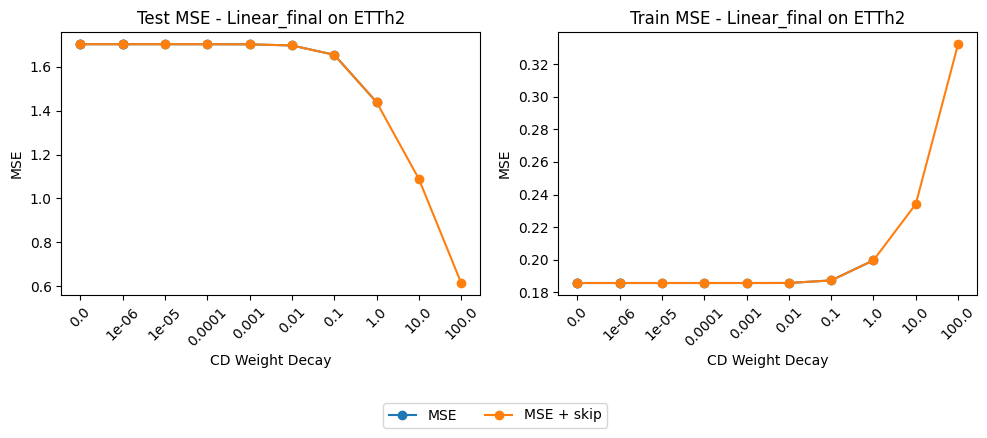

In [5]:
# Shared filter params
data = "ETTh2"
channel_handling = "Delta"
model = "Linear_final"
random_seed = 2021
pred_len = 96
#pred_len = 24
patience = 20
seq_len = 336
#seq_len = 104


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

handles = []
labels = []

for i, (skip, label_suffix) in enumerate([(0, ""), (1, " + skip")]):
    df_filtered = df_subset[
        (df_subset['data_path'].str.contains(data)) &
        (~df_subset['data_path'].str.contains("lag")) &
        (df_subset['model'] == model) &
        (df_subset['channel_handling'] == channel_handling) &
        (df_subset['random_seed'] == random_seed) &
        (df_subset['skip_1st_epoch'] == skip) &
        (df_subset['pred_len'] == pred_len) &
        (df_subset['patience'] == patience) &
        (df_subset['seq_len'] == seq_len)
    ].sort_values(by='cd_weight_decay')

    label = 'MSE' + label_suffix
    line1, = axes[0].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse'], marker='o', label=label)
    line2, = axes[1].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse_train'], marker='o', label=label)

    if label not in labels:  # add only if unique
        handles.append(line1)
        labels.append(label)

# Customize subplots
axes[0].set_title(f'Test MSE - {model} on {data}')
axes[0].set_xlabel('CD Weight Decay')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

axes[1].set_title(f'Train MSE - {model} on {data}')
axes[1].set_xlabel('CD Weight Decay')
axes[1].set_ylabel('MSE')
axes[1].tick_params(axis='x', rotation=45)

# Place a single legend below both plots
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # make space for legend
plt.show()


### Results published in papers

In [6]:
paper_results_df = pd.read_csv('../paper_results.csv')
paper_results_df.head()

Dataset Prediction Length    MSE    MAE  model        source ci_cd  \
0   ETTm1                96  0.288  0.343  TVNet  li2025_tvnet    CD   
1   ETTm1               192  0.326  0.367  TVNet  li2025_tvnet    CD   
2   ETTm1               336  0.365  0.391  TVNet  li2025_tvnet    CD   
3   ETTm1               720  0.412  0.413  TVNet  li2025_tvnet    CD   
4   ETTm1               Avg  0.348  0.379  TVNet  li2025_tvnet    CD   

           model_source  
0  TVNet (li2025_tvnet)  
1  TVNet (li2025_tvnet)  
2  TVNet (li2025_tvnet)  
3  TVNet (li2025_tvnet)  
4  TVNet (li2025_tvnet)

In [7]:

"""
df_ref = paper_results_df[
    (paper_results_df['source'] == "nie2023_patchtst") #| 
    #(paper_results_df['model'] == "Linear") | (paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
    #(paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
]
"""
df_ref = paper_results_df.copy()

df_ref.columns = ['data_path', 'pred_len', 'mse', 'mae', 'model', 'source', 'ci_cd', 'model_source']
df_ref = df_ref.replace("ILI", "national_illness")
df_ref = df_ref.replace("Traffic", "traffic")
df_ref = df_ref.replace("Weather", "weather")
df_ref = df_ref.replace("Electricity", "electricity")
df_ref = df_ref.replace("Exchange", "exchange_rate")

df_ref = df_ref.dropna()

color_map = {'CI': 'tab:blue', 'CD': 'tab:orange'}

display(df_ref.head())

data_path pred_len    mse    mae  model        source ci_cd  \
0     ETTm1       96  0.288  0.343  TVNet  li2025_tvnet    CD   
1     ETTm1      192  0.326  0.367  TVNet  li2025_tvnet    CD   
2     ETTm1      336  0.365  0.391  TVNet  li2025_tvnet    CD   
3     ETTm1      720  0.412  0.413  TVNet  li2025_tvnet    CD   
4     ETTm1      Avg  0.348  0.379  TVNet  li2025_tvnet    CD   

           model_source  
0  TVNet (li2025_tvnet)  
1  TVNet (li2025_tvnet)  
2  TVNet (li2025_tvnet)  
3  TVNet (li2025_tvnet)  
4  TVNet (li2025_tvnet)

# NEW Shower example (dataset selection)
#### 1 Channel of exisiting dataset + lagged one

## Check Avg error channel-wise = error

In [8]:
import statistics

"""
pred_len_list = [96, 720]
data_path_list = ["ETTh1", "weather"]

decimals = 5

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        df_CI = df_subset[(df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()
        
        for index, row in df_CI.iterrows():
            print(index, data_path, round(statistics.mean(row['mse_per_channel_list']), decimals), round(statistics.mean(row['mse_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mse'], decimals), round(row['mse_train'], decimals))
            print()
            print(index, data_path, round(statistics.mean(row['mae_per_channel_list']), decimals), round(statistics.mean(row['mae_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mae'], decimals), round(row['mae_train'], decimals))
            print()
            
"""

'\npred_len_list = [96, 720]\ndata_path_list = ["ETTh1", "weather"]\n\ndecimals = 5\n\nfor i, pred_len in enumerate(pred_len_list):\n    for j, data_path in enumerate(data_path_list):\n        df_CI = df_subset[(df_subset[\'data_path\'].str.contains(data_path)) & (df_subset[\'pred_len\'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()\n        \n        for index, row in df_CI.iterrows():\n            print(index, data_path, round(statistics.mean(row[\'mse_per_channel_list\']), decimals), round(statistics.mean(row[\'mse_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mse\'], decimals), round(row[\'mse_train\'], decimals))\n            print()\n            print(index, data_path, round(statistics.mean(row[\'mae_per_channel_list\']), decimals), round(statistics.mean(row[\'mae_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mae\'], decimals), round(row[\'mae_train\'], decimals))\n     

# Remove duplicates

In [9]:
columns_to_keep = ['model', 'pred_len', 'random_seed', 'data_path', 'mae', 'mse', 'seq_len', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", 
                   "mse_per_channel_list", "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "patience", "head_dropout",
                   "dropout", "delta_factor", "skip_1st_epoch"]

# Keep only those columns
df_subset = df[columns_to_keep]
df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)

df_subset = df_subset[df_subset['model'].isin(["Linear_final", "ModernTCN", "PatchTST"])]

df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]
duplicates = df_hashable[df_hashable.duplicated()]
display(duplicates)

# Remove duplicates from df_subset based on hashable columns
df_subset = df_subset[~df_hashable.duplicated()]

/scratch/ipykernel_125956/4226996381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)
/scratch/ipykernel_125956/4226996381.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]


model  pred_len  random_seed data_path       mae       mse  \
473       PatchTST        96         2021     ETTm2  0.254921  0.164901   
474       PatchTST        96         2021     ETTm2  0.254921  0.164901   
533       PatchTST        96         2021     ETTm2  0.251381  0.163358   
554       PatchTST        96         2021     ETTm2  0.254921  0.164901   
583       PatchTST        96         2021   weather  0.199393  0.151571   
...            ...       ...          ...       ...       ...       ...   
8767  Linear_final       720         2025     ETTm1  0.579387  0.654431   
8775  Linear_final        96         2025     ETTm1  0.373296  0.324243   
8780  Linear_final       192         2025     ETTm1  0.416050  0.391110   
8784  Linear_final       336         2025     ETTm1  0.471309  0.469961   
8789  Linear_final       720         2025     ETTm1  0.568775  0.642575   

      seq_len  cd_weight_decay  mse_train  mae_train channel_handling  \
473       336              0.0   0.208256   0.258387          CI_glob   
474       336              0.0   0.208256   0.258387          CI_glob   
533       336              0.0   0.191638   0.250169           CI_loc   
554       336              0.0   0.208256   0.258387          CI_glob   
583       336              0.0   0.405948   0.293351          CI_glob   
...       ...              ...        ...        ...              ...   
8767      336             10.0   0.356811   0.420420               CD   
8775      336             10.0   0.225746   0.322269            Delta   
8780      336             10.0   0.274798   0.362469            Delta   
8784      336             10.0   0.326006   0.399766            Delta   
8789      336             10.0   0.352712   0.415614            Delta   

      learning_rate  batch_size  patience  head_dropout  dropout  \
473          0.0001         128        20           0.0     0.20   
474          0.0001         128        20           0.0     0.20   
533          0.0001         128        20           0.0     0.20   
554          0.0001         128        20           0.0     0.20   
583          0.0001         128        20           0.0     0.20   
...             ...         ...       ...           ...      ...   
8767         0.0050          32        20           0.0     0.05   
8775         0.0050          32        20           0.0     0.05   
8780         0.0050          32        20           0.0     0.05   
8784         0.0050          32        20           0.0     0.05   
8789         0.0050          32        20           0.0     0.05   

      delta_factor  skip_1st_epoch  
473            1.0             0.0  
474            1.0             0.0  
533            1.0             0.0  
554            1.0             0.0  
583            1.0             0.0  
...            ...             ...  
8767           1.0             1.0  
8775           1.0             1.0  
8780           1.0             1.0  
8784           1.0             1.0  
8789           1.0             1.0  

[246 rows x 18 columns]

# Remove unwanted HPs

In [10]:
# Make a copy of the index to avoid modifying during iteration
rows_to_drop = []

for idx, row in df_subset.iterrows():
    if "lag" in row["data_path"] and row["patience"] == 100:
        rows_to_drop.append(idx)
    
    if row["model"] == "Linear_final":
        if row["channel_handling"] in ["CD", "Delta"] and row["skip_1st_epoch"] == 0 and ("lag" not in row["data_path"]):
            rows_to_drop.append(idx)
        elif row["learning_rate"] != 0.005:
            rows_to_drop.append(idx)
            #print(row.to_string())
        elif row["data_path"] in ["traffic", "electricity"] and (row["batch_size"] != 16 or row["patience"] != 10):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"] and (row["batch_size"] != 32 or row["patience"] != 20):
            rows_to_drop.append(idx)

    elif row["model"] == "PatchTST":
        if row["data_path"] in ["traffic", "electricity"] and row["patience"] != 10:
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "national_illness", "weather"] and row["patience"] != 20:
            rows_to_drop.append(idx)
            print(row.to_string())
    
    elif row["model"] == "ModernTCN":
        if row["channel_handling"] == "Delta" and row["delta_factor"] != 0.5:
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            #print(row.to_string())
        #elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.1 or row["dropout"] != 0.3):
        elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["electricity"] and (row["patience"] != 10 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["traffic"] and (row["patience"] != 10 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["national_illness"] and (row["patience"] != 5 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.1):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["weather"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.4):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["exchange_rate"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.6 or row["dropout"] != 0.2):
            rows_to_drop.append(idx)


print(f"Dropping {len(rows_to_drop)} rows based on model and hyperparameter conditions.")

dropped_rows_df = df_subset.loc[rows_to_drop]
#display(dropped_rows_df[dropped_rows_df["model"] == "Linear_final"])

# Drop the rows head_dropout
df_subset = df_subset.drop(index=rows_to_drop)

#display(df)
#display(df[(df["model"] == "Linear_final") & (df["data_path"] == "ETTh1")& (df["patience"] == 20)& (df["random_seed"] == 2021)])



model                                                                 ModernTCN
pred_len                                                                     96
random_seed                                                                2021
data_path                                                                 ETTm2
mae                                                                    0.257687
mse                                                                    0.169133
seq_len                                                                     336
cd_weight_decay                                                             0.0
mse_train                                                               0.19823
mae_train                                                              0.257306
mse_train_per_channel_list    [0.30523407459259033, 0.3695241808891296, 0.07...
mse_per_channel_list          [0.27678433060646057, 0.20330683887004852, 0.0...
mae_train_per_channel_list    [0.3430073

# Linear final - channel-wise

In [11]:
df_avg = pd.DataFrame()

"""
loop over:
    - channel_handling
        - cd_weight_decay
            - pred_len
    -> Dafür dann über random seeds avg bilden        

"""


def avg_seeds(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    df_subset = df_subset[
        (df_subset['model'] == model) &
        (df_subset['data_path'] == data_path)

        #(df_subset['data_path'].str.contains(data_path)) &
        #(~df_subset['data_path'].str.contains("lag"))
    ].copy()
        
    for channel_handling in list_channel_handling:
        
        df_seed_channel = df_subset[df_subset['channel_handling'] == channel_handling]
        if df_seed_channel.empty:
            continue

        list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
        list_cd_pred_len = df_seed_channel['pred_len'].unique().tolist()

        list_cd_pred_len = list_cd_pred_len + ["Avg"]
        
        for cd_weight_decay in list_cd_weight_decay:
            for pred_len in list_cd_pred_len:
                if pred_len == "Avg":
                    df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay)].copy()
                else:
                    df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay) &
                                                        (df_seed_channel['pred_len'] == pred_len)
                                                        ].copy()
                if df_seed_channel_cd.empty:
                    continue

                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': pred_len,
                    'random_seed': "Avg",

                    'mse_mean': df_seed_channel_cd['mse'].mean(),
                    'mse_std': df_seed_channel_cd['mse'].std(),
                    'mae_mean': df_seed_channel_cd['mae'].mean(),
                    'mae_std': df_seed_channel_cd['mae'].std(),

                    'mse_train_mean': df_seed_channel_cd['mse_train'].mean(),
                    'mse_train_std': df_seed_channel_cd['mse_train'].std(),
                    'mae_train_mean': df_seed_channel_cd['mae_train'].mean(),
                    'mae_train_std': df_seed_channel_cd['mae_train'].std(),

                    'cw_mse_std_mean': df_seed_channel_cd['cw_mse_std'].mean(),
                    'cw_mse_std_std': df_seed_channel_cd['cw_mse_std'].std(),
                    'cw_mae_std_mean': df_seed_channel_cd['cw_mae_std'].mean(),
                    'cw_mae_std_std': df_seed_channel_cd['cw_mae_std'].std(),

                    'cw_mse_std_mean_quot_MEAN': df_seed_channel_cd['cw_mse_std_mean_quot'].mean(),
                    'cw_mse_std_mean_quot_STD': df_seed_channel_cd['cw_mse_std_mean_quot'].std(),

                    'cw_mse_train_std_mean': df_seed_channel_cd['cw_mse_train_std'].mean(),
                    'cw_mse_train_std_std': df_seed_channel_cd['cw_mse_train_std'].std(),
                    'cw_mae_train_std_mean': df_seed_channel_cd['cw_mae_train_std'].mean(),
                    'cw_mae_train_std_std': df_seed_channel_cd['cw_mae_train_std'].std(),

                    'model_CH': model + " ("+ channel_handling+ ")",
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'delta_factor': df_seed_channel_cd['delta_factor'].unique().tolist(),
                    'skip_1st_epoch': df_seed_channel_cd['skip_1st_epoch'].unique().tolist(),
                    'Avg_values_RanS': df_seed_channel_cd['random_seed'].tolist(), 
                    'Avg_Count_RanS': len(df_seed_channel_cd), 
                }
                
                avg_row['mse_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]
                
                avg_row['mse_per_channel_list_stds'] = [np.std(x, ddof=1) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list_stds'] = [np.std(x, ddof=1) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list_stds'] = [np.std(x, ddof=1) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list_stds'] = [np.std(x, ddof=1) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

# Example usage

df_avg_seeds = pd.DataFrame()

#["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]



mask = (
    (df_subset['data_path'].isin(["traffic", "electricity"])) &
    (
        df_subset['model'].str.contains("Linear") |
        df_subset['channel_handling'].isin(["CI_loc"])
    )
)


df_subset = df_subset[~mask]
"""
print((df_subset['data_path'] == "traffic").sum())

display(df_subset[(df_subset['data_path'] == "traffic") & (df_subset['model'] == "PatchTST")].sort_values(by="random_seed"))

display(df_subset[df_subset.isna().any(axis=1)])

print((df_subset['data_path'] == "traffic").sum())
"""

#display(df_subset[df_subset.isna().any(axis=1)])

#df_subset = df_subset.dropna()
df_subset = df_subset[df_subset["mse"].notna()]

cols_to_fill = [
    "mse_train_per_channel_list",
    "mse_per_channel_list",
    "mae_train_per_channel_list",
    "mae_per_channel_list"
]

#for col in cols_to_fill:
#    df_subset.loc[df_subset[col].isna(), col] = [0,0]

for col in cols_to_fill:
    df_subset[col] = df_subset[col].apply(lambda x: x if isinstance(x, list) else [0, 0] if pd.isna(x) else x)



#df_subset = df_subset[~df_subset['data_path'].str.contains('traffic|electricity', case=False, na=False)]

mask = df_subset['data_path'].str.contains('traffic|electricity', case=False, na=False)

# For each column, replace dicts with [0] only where the mask is True
for col in df_subset.columns:
    df_subset.loc[mask, col] = df_subset.loc[mask, col].apply(
        lambda x: [0] if isinstance(x, dict) else x
    )

print(df_subset['mse_per_channel_list'].apply(type).value_counts())
print(df_subset[df_subset['mse_per_channel_list'].apply(lambda x: isinstance(x, dict))]['data_path'])


print(df_subset['model'].unique().tolist())

df_subset['model'] = df_subset['model'].replace("Linear_final", "Linear")
df_subset['data_path'] = df_subset['data_path'].replace("exchange_rate", "Exchange")
df_subset['data_path'] = df_subset['data_path'].replace("weather", "Weather")
df_subset['data_path'] = df_subset['data_path'].replace("national_illness", "ILI")
df_subset['data_path'] = df_subset['data_path'].replace("electricity", "Electricity")
df_subset['data_path'] = df_subset['data_path'].replace("traffic", "Traffic")


mse_per_channel_list
<class 'list'>    5425
Name: count, dtype: int64
Series([], Name: data_path, dtype: object)
['PatchTST', 'ModernTCN', 'Linear_final']


In [12]:
found = []
not_found = []

base_path = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"


def check(matches):
    for match in matches:
        file_path = os.path.join(base_path, match, "mse_per_channel_list.json")
        if os.path.isfile(file_path):
            rs_match = re.search(r"rs(\d+)", match)
            pl_match = re.search(r"pl(\d+)", match)

            rs = int(rs_match.group(1)) if rs_match else None
            pl = int(pl_match.group(1)) if pl_match else None

            found.append(f"{rs}_{pl}")

            pass
        else:
            not_found.append(os.path.join(base_path, match))
            print(f"File not found: {file_path}")

def return_list(match):
    file_path = os.path.join(base_path, match, "mse_per_channel_list.json")
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


model_types = []

for pred_len in [96, 192, 336, 720]:
    for rseed in [2021, 2022, 2023, 2024, 2025]:
        for data_path in ["Traffic", "Electricity"]:
            print(pred_len, rseed, data_path)
            ### TCN CI
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "chCI_glob", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "CI_glob") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])
            
            ### TCN CD
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "chCD", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "CD") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])

            ### TCN Delta
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "df0.5", "chDelta", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "Delta") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])

            ### Patch CI
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TST", data_path[1:], "chCI_glob", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)

            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "PatchTST")  & (df_subset['channel_handling'] == "CI_glob") 
            # Assign new values
            #display(df_subset.loc[mask, 'mse_per_channel_list'])
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])
            #display(df_subset.loc[mask, 'mse_per_channel_list'])


96 2021 Traffic
['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_df1.0_p10_sk0_Exp_0']
['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_Exp_0']
['traffic_336_96_PatchTST_custom_ftM_sl336_ll48_pl96_dm128_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
96 2021 Electricity
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_df1.0_p10_sk0_Exp_0']
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs202

In [13]:
"""
df_subset['cw_mse_std'] = df_subset['mse_per_channel_list'].apply(np.std)
df_subset['cw_mae_std'] = df_subset['mae_per_channel_list'].apply(np.std)
df_subset['cw_mse_train_std'] = df_subset['mse_train_per_channel_list'].apply(np.std)
df_subset['cw_mae_train_std'] = df_subset['mae_train_per_channel_list'].apply(np.std)
"""

df_subset['cw_mse_std'] = df_subset['mse_per_channel_list'].apply(lambda x: np.std(x, ddof=1))
df_subset['cw_mae_std'] = df_subset['mae_per_channel_list'].apply(lambda x: np.std(x, ddof=1))
df_subset['cw_mse_train_std'] = df_subset['mse_train_per_channel_list'].apply(lambda x: np.std(x, ddof=1))
df_subset['cw_mae_train_std'] = df_subset['mae_train_per_channel_list'].apply(lambda x: np.std(x, ddof=1))


df_subset['cw_mse_std_mean_quot'] = df_subset['cw_mse_std'] / df_subset['mse']

list_lag = ["_weather_shower_lag_0_T_degC", "_weather_shower_lag_48_T_degC", "_weather_shower_lag_96_T_degC", "_weather_shower_lag_192_T_degC", 
            "_weather_shower_lag_336_T_degC", "_weather_shower_lag_720_T_degC"]
""" 
for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"]:
    for model in ["Linear_final", "PatchTST", "ModernTCN"]:
        df_avg_seeds = avg_seeds(df_avg=df_avg_seeds, data_path=data_path, model=model, df_subset=df_subset)

df_avg_seeds.to_pickle("df_avg_seeds.pkl")

#display(df_avg_seeds)

"""

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Weather", "Exchange", "ILI", "Electricity", "Traffic"] + list_lag:
    for model in ["Linear", "PatchTST", "ModernTCN"]:
#for data_path in list_lag:
        df_avg = pd.DataFrame()
        df_avg = avg_seeds(df_avg, data_path=data_path, model=model, df_subset=df_subset)
        if df_avg.empty == False:
            print(df_avg['Avg_Count_RanS'].unique().tolist(), data_path, model)

df_avg = pd.DataFrame()

df_avg = avg_seeds(df_avg, data_path="Electricity", model="ModernTCN", df_subset=df_subset)
display(df_avg)

df_avg = pd.DataFrame()

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Weather", "Exchange", "ILI", "Electricity", "Traffic"] + list_lag:
    for model in ["Linear", "PatchTST", "ModernTCN"]:
        df_avg = avg_seeds(df_avg, data_path=data_path, model=model, df_subset=df_subset)



"""
df_avg = pd.DataFrame()
df_avg = avg_seeds(df_avg, data_path="_weather_shower_lag_336_T_degC", model="Linear_final", df_subset=df_subset)

display(df_avg)
"""

/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/miniconda3/envs/PatchTST/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/miniconda3/envs/PatchTST/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/miniconda3/envs/PatchTST/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/miniconda3/envs/PatchTST/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[5, 20] ETTh1 Linear
[5, 20] ETTh1 PatchTST
[5, 20] ETTh1 ModernTCN
[5, 20] ETTh2 Linear
[5, 20] ETTh2 PatchTST
[5, 20] ETTh2 ModernTCN
[5, 20] ETTm1 Linear
[5, 20] ETTm1 PatchTST
[5, 20] ETTm1 ModernTCN
[5, 20] ETTm2 Linear
[5, 20] ETTm2 PatchTST
[5, 20] ETTm2 ModernTCN
[5, 20] Weather Linear
[5, 20] Weather PatchTST
[5, 20] Weather ModernTCN
[5, 20] Exchange Linear
[5, 20] Exchange PatchTST
[5, 20] Exchange ModernTCN
[5, 20] ILI Linear
[5, 20] ILI PatchTST
[5, 20] ILI ModernTCN
[5, 20] Electricity PatchTST
[5, 20] Electricity ModernTCN
[5, 20] Traffic PatchTST
[5, 20] Traffic ModernTCN
[5, 20] _weather_shower_lag_0_T_degC Linear
[5, 20] _weather_shower_lag_0_T_degC ModernTCN
[5, 20] _weather_shower_lag_48_T_degC Linear
[5, 20] _weather_shower_lag_48_T_degC ModernTCN
[5, 20] _weather_shower_lag_96_T_degC Linear
[5, 20] _weather_shower_lag_96_T_degC ModernTCN
[5, 20] _weather_shower_lag_192_T_degC Linear
[5, 20] _weather_shower_lag_192_T_degC ModernTCN
[5, 20] _weather_shower_lag_336_T

model    data_path pred_len random_seed  mse_mean   mse_std  mae_mean  \
0   ModernTCN  Electricity       96         Avg  0.141262  0.000574  0.236999   
1   ModernTCN  Electricity      192         Avg  0.154329  0.000333  0.248312   
2   ModernTCN  Electricity      336         Avg  0.170767  0.000441  0.264741   
3   ModernTCN  Electricity      720         Avg  0.209611  0.000601  0.297010   
4   ModernTCN  Electricity      Avg         Avg  0.168992  0.026347  0.261766   
5   ModernTCN  Electricity       96         Avg  0.135003  0.000098  0.230738   
6   ModernTCN  Electricity      192         Avg  0.148982  0.000100  0.242938   
7   ModernTCN  Electricity      336         Avg  0.164734  0.000175  0.259153   
8   ModernTCN  Electricity      720         Avg  0.205782  0.001847  0.295890   
9   ModernTCN  Electricity      Avg         Avg  0.163626  0.027217  0.257180   
10  ModernTCN  Electricity      336         Avg  0.165096  0.000790  0.260825   
11  ModernTCN  Electricity       96         Avg  0.136174  0.001291  0.231984   
12  ModernTCN  Electricity      720         Avg  0.198233  0.002123  0.290148   
13  ModernTCN  Electricity      192         Avg  0.149587  0.000687  0.243899   
14  ModernTCN  Electricity      Avg         Avg  0.162273  0.023781  0.256714   

     mae_std  mse_train_mean  mse_train_std  ...  \
0   0.001033        0.142266       0.000554  ...   
1   0.000591        0.156975       0.000301  ...   
2   0.000706        0.179759       0.000331  ...   
3   0.000805        0.225632       0.000459  ...   
4   0.023212        0.176158       0.032354  ...   
5   0.000106        0.134066       0.000107  ...   
6   0.000111        0.149573       0.000152  ...   
7   0.000196        0.169718       0.000708  ...   
8   0.002320        0.207495       0.006376  ...   
9   0.025177        0.162988       0.027240  ...   
10  0.001229        0.166568       0.002894  ...   
11  0.001040        0.135947       0.001792  ...   
12  0.001835        0.191210       0.002856  ...   
13  0.000667        0.150319       0.000835  ...   
14  0.022453        0.159422       0.020467  ...   

                                      Avg_values_RanS  Avg_Count_RanS  \
0                      [2021, 2022, 2023, 2024, 2025]               5   
1                      [2021, 2022, 2025, 2023, 2024]               5   
2                      [2021, 2022, 2025, 2023, 2024]               5   
3                      [2022, 2023, 2025, 2024, 2021]               5   
4   [2021, 2021, 2021, 2022, 2022, 2022, 2022, 202...              20   
5                      [2022, 2023, 2024, 2025, 2021]               5   
6                      [2022, 2023, 2024, 2025, 2021]               5   
7                      [2022, 2023, 2024, 2025, 2021]               5   
8                      [2022, 2023, 2024, 2025, 2021]               5   
9   [2022, 2022, 2022, 2022, 2023, 2024, 2025, 202...              20   
10                     [2021, 2022, 2023, 2024, 2025]               5   
11                     [2021, 2023, 2022, 2024, 2025]               5   
12                     [2021, 2023, 2022, 2024, 2025]               5   
13                     [2021, 2022, 2023, 2025, 2024]               5   
14  [2021, 2021, 2021, 2021, 2022, 2023, 2023, 202...              20   

                           mse_per_channel_list_means  \
0   [0.3784301280975342, 0.14146406352519988, 0.00...   
1   [0.4637388825416565, 0.158041849732399, 0.0002...   
2   [0.6292712807655334, 0.1812553197145462, 0.000...   
3   [1.1152931451797485, 0.27220059633255006, 0.00...   
4   [0.6466833591461182, 0.18824045732617378, 0.00...   
5   [0.3550825595855713, 0.1344420164823532, 0.000...   
6   [0.44499664902687075, 0.1518248051404953, 0.00...   
7   [0.6122086405754089, 0.175484099984169, 0.0002...   
8   [1.1344626665115356, 0.26548182368278506, 0.00...   
9   [0.6366876289248466, 0.18180818632245063, 0.00...   
10  [0.6342210531234741, 0.17960575222969055, 0.00...   
11  [0.36113010048866273,

'\ndf_avg = pd.DataFrame()\ndf_avg = avg_seeds(df_avg, data_path="_weather_shower_lag_336_T_degC", model="Linear_final", df_subset=df_subset)\n\ndisplay(df_avg)\n'

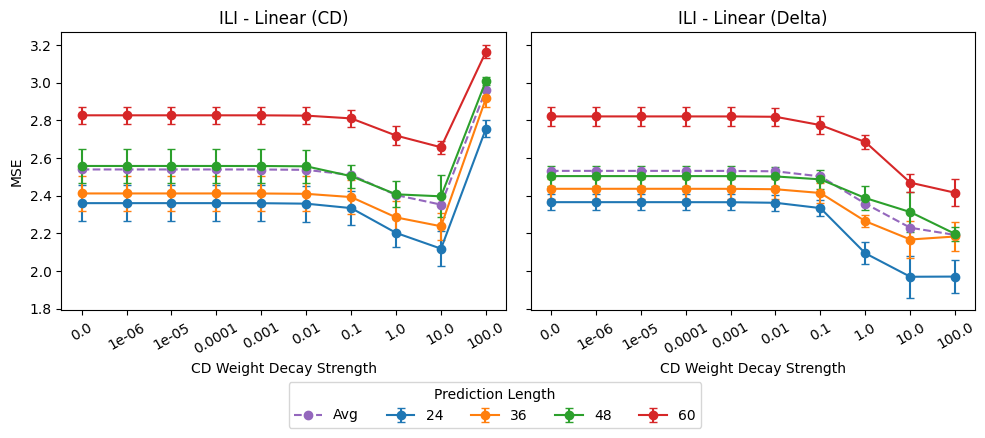

In [14]:
metric = "mse"
data = "ETTh1"
model = "Linear"
channel_handlings = ["CD", "Delta"]
#pred_lens = [96, 192, 336, 720, "Avg"]

for data in ["ILI"]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    pred_lens = df_avg[(df_avg['data_path'] == data)]['pred_len'].unique().tolist()
    pred_lens = sorted(pred_lens, key=lambda x: float('inf') if x == "Avg" else x)

    #print(pred_lens)

    for ax, channel_handling in zip(axes, channel_handlings):
        for pred_len in pred_lens:
            df_filtered = df_avg[
                (df_avg['data_path'] == data) &
                (df_avg['model'] == model) &
                (df_avg['channel_handling'] == channel_handling) &
                (df_avg['pred_len'] == pred_len)
            ].sort_values(by='cd_weight_decay')

            if not df_filtered.empty:
                if pred_len == "Avg":
                    ax.plot(
                        df_filtered['cd_weight_decay'].astype(str),
                        df_filtered[metric+'_mean'],
                        marker='o',
                        linestyle='--',
                        label=str(pred_len)
                    )
                else:
                    ax.errorbar(
                        df_filtered['cd_weight_decay'].astype(str),
                        df_filtered[metric+'_mean'],
                        yerr=df_filtered[metric+'_std'],
                        marker='o',
                        capsize=3,
                        label=str(pred_len)
                    )

        ax.set_title(f"{data} - Linear ({channel_handling})")
        ax.set_xlabel("CD Weight Decay Strength")
        ax.tick_params(axis='x', rotation=30)
        #ax.grid()

    axes[0].set_ylabel(metric.upper())
    #fig.legend(title="Prediction Length", loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.1))
    # Get all handles and labels from both axes
    handles_labels = [ax.get_legend_handles_labels() for ax in axes]
    handles, labels = zip(*handles_labels)

    # Flatten and deduplicate
    flat_handles = sum(handles, [])
    flat_labels = sum(labels, [])
    unique = dict(zip(flat_labels, flat_handles))  # removes duplicates by label

    # Shared legend
    fig.legend(
        unique.values(),
        unique.keys(),
        title="Prediction Length",
        loc="lower center",
        ncol=5,
        bbox_to_anchor=(0.5, -0.1)
    )
    plt.tight_layout(rect=[0, 0.01, 1, 1])
    os.makedirs("plots/Thesis", exist_ok=True)
    plt.savefig(f"plots/Thesis/Linear_WeightDecay_{data}.png", bbox_inches='tight', dpi=300)
    plt.show()


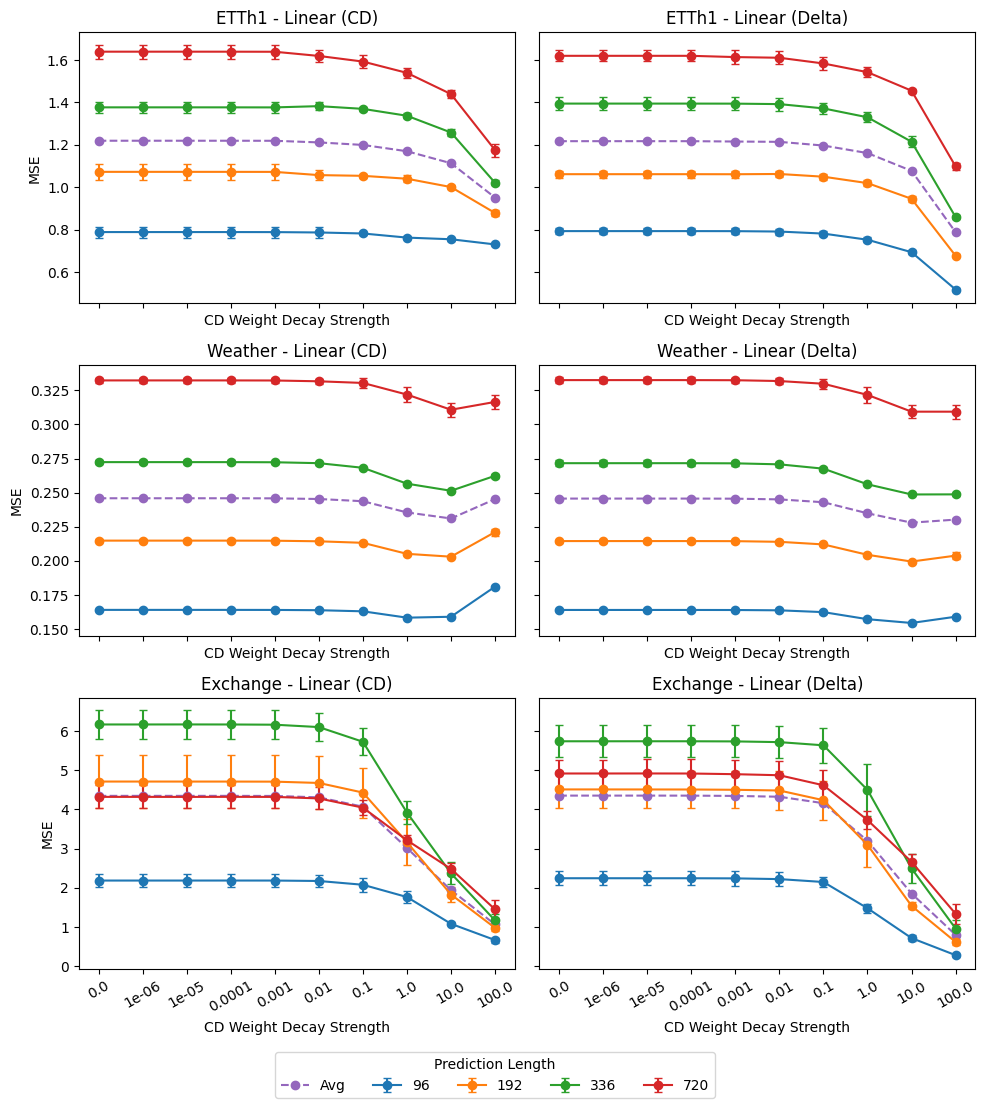

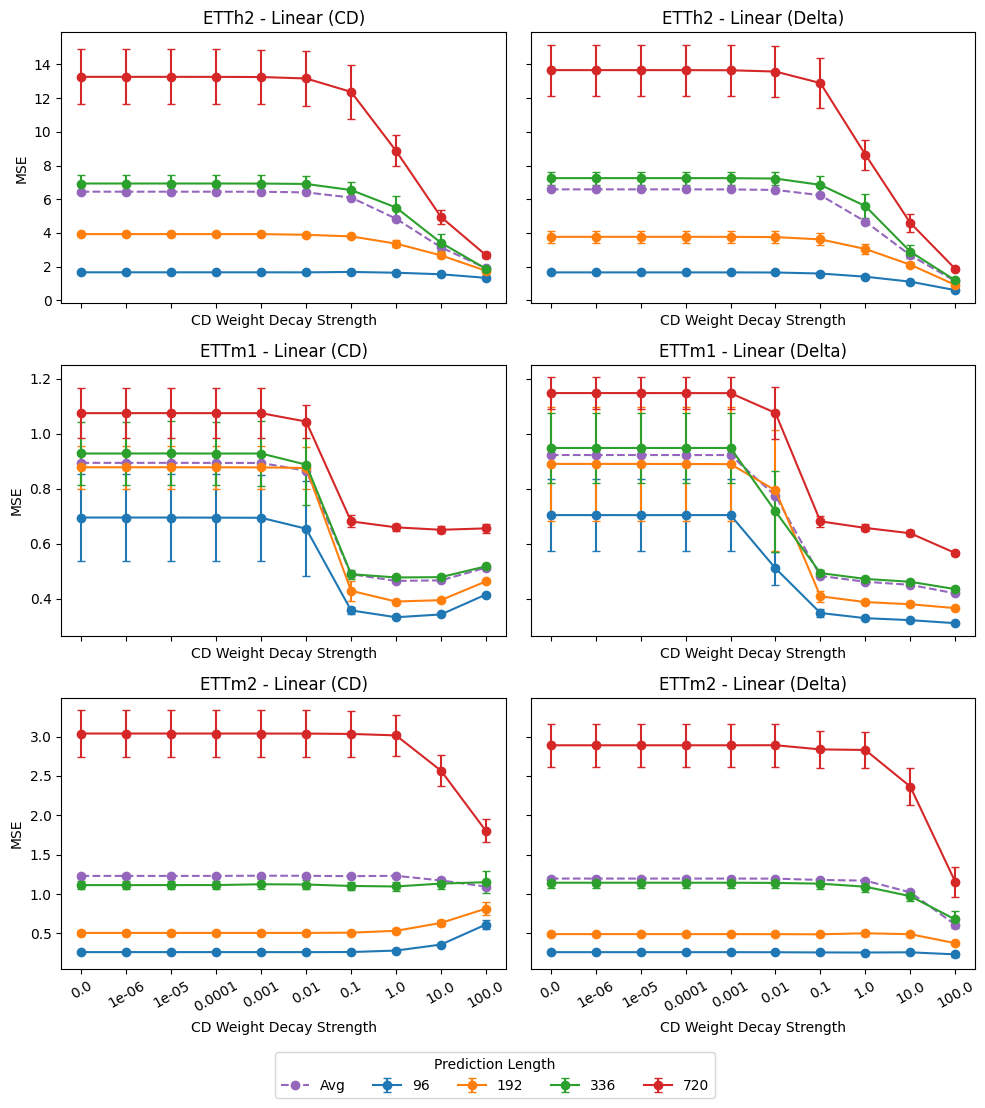

In [15]:
def plot_cd_delta_grid(df, data_list, model="Linear", metric="mse", channel_handlings=["CD", "Delta"]):
    n = len(data_list)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3.7 * n), sharey='row',sharex = True)

    for i, data in enumerate(data_list):
        pred_lens = df[(df['data_path'] == data)]['pred_len'].unique().tolist()
        pred_lens = sorted(pred_lens, key=lambda x: float('inf') if x == "Avg" else x)

        for j, channel_handling in enumerate(channel_handlings):
            ax = axes[i, j] if n > 1 else axes[j]

            for pred_len in pred_lens:
                df_filtered = df[
                    (df['data_path'] == data) &
                    (df['model'] == model) &
                    (df['channel_handling'] == channel_handling) &
                    (df['pred_len'] == pred_len)
                ].sort_values(by='cd_weight_decay')

                if not df_filtered.empty:
                    if pred_len == "Avg":
                        ax.plot(
                            df_filtered['cd_weight_decay'].astype(str),
                            df_filtered[f'{metric}_mean'],
                            marker='o',
                            linestyle='--',
                            label=str(pred_len)
                        )
                    else:
                        ax.errorbar(
                            df_filtered['cd_weight_decay'].astype(str),
                            df_filtered[f'{metric}_mean'],
                            yerr=df_filtered[f'{metric}_std'],
                            marker='o',
                            capsize=3,
                            label=str(pred_len)
                        )

            ax.set_title(f"{data} - {model} ({channel_handling})")
            ax.set_xlabel("CD Weight Decay Strength")
            ax.tick_params(axis='x', rotation=30)
            #ax.grid(alpha=0.3)

            if j == 0:
                ax.set_ylabel(metric.upper())

    # Shared legend
    handles_labels = [ax.get_legend_handles_labels() for ax in axes[0] if hasattr(ax, "get_legend_handles_labels")]
    handles, labels = zip(*handles_labels)
    flat_handles = sum(handles, [])
    flat_labels = sum(labels, [])
    unique = dict(zip(flat_labels, flat_handles))

    fig.legend(
        unique.values(),
        unique.keys(),
        title="Prediction Length",
        loc="lower center",
        ncol=5,
        bbox_to_anchor=(0.5, 0.0)
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs("plots/Thesis", exist_ok=True)
    plt.savefig(f"plots/Thesis/Linear_WeightDecay_{data}.png", bbox_inches='tight', dpi=300)
    plt.show()

plot_cd_delta_grid(df=df_avg, data_list = ["ETTh1", "Weather", "Exchange"]) 
plot_cd_delta_grid(df=df_avg, data_list = ["ETTh2", "ETTm1", "ETTm2"]) 
#plot_cd_delta_grid(df=df_avg, data_list = ["national_illness"]) 


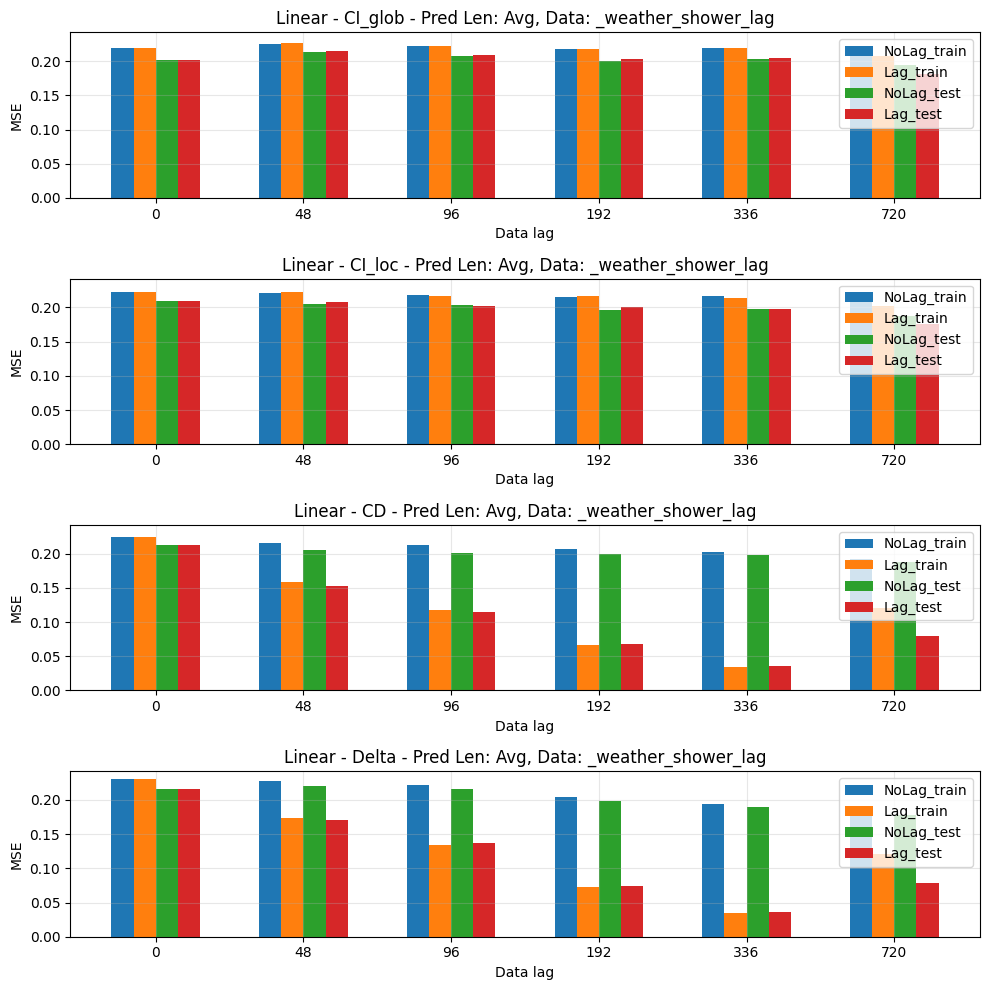

In [16]:
pred_len_list = "Avg"
data_path_list = ["_weather_shower_lag"]
metric = "MSE"

def lag(pred_len=pred_len, data_path_list=data_path_list, df_subset=df_subset, model="Linear_final"):
    fig, axs = plt.subplots(4, figsize=(10, 10), sharey=True)
    #fig, axs = plt.subplots(4, figsize=(10, 10))#, sharey=True)

    
    for j, data_path in enumerate(data_path_list):
        for ind, channel_handling in enumerate(["CI_glob", "CI_loc", "CD", "Delta"]):
            df_CI = df_subset[(df_subset['model'] == model) & (df_subset['channel_handling'] == channel_handling) & (df_subset['cd_weight_decay'] == 0.0) 
                              & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len)].copy()
            #df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_([0-9]+)$').astype(int)
            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            #display(df_CI)

            data_train = df_CI["mse_train_per_channel_list_means"].tolist()
            data_test = df_CI["mse_per_channel_list_means"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            #display(data)

            x_labels = df_CI['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[ind].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[ind].set_xticks(x)
            axs[ind].set_xticklabels(x_labels)
            axs[ind].set_title(f'{model} - {channel_handling} - Pred Len: {pred_len}, Data: {data_path}')
            axs[ind].set_ylabel(metric)
            axs[ind].set_xlabel("Data lag")
            axs[ind].legend()
            axs[ind].grid(alpha=0.3)

    plt.tight_layout()
    #plt.savefig("plots/Dataset_Selec/"+model+"_pred"+str(pred_len)+".png")
    plt.show()

lag(pred_len=pred_len_list, data_path_list=data_path_list, df_subset=df_avg, model="Linear")

In [17]:

pred_len_list = 192
data_path_list = ["_weather_shower_lag"]
metric = "MSE"

def lag(pred_len=pred_len_list, data_path_list=data_path_list, df_subset=None, model="Linear"):
    #fig, axs = plt.subplots(4, figsize=(10, 8), sharey=True, sharex=True)
    fig, axs = plt.subplots(4, figsize=(5, 8), sharey=True, sharex=True)

    for j, data_path in enumerate(data_path_list):
        for ind, channel_handling in enumerate(["CI_glob", "CI_loc", "CD", "Delta"]):
            df_CI = df_subset[
                (df_subset['model'] == model) &
                (df_subset['channel_handling'] == channel_handling) &
                (df_subset['cd_weight_decay'] == 0.0) &
                (df_subset['data_path'].str.contains(data_path)) &
                (df_subset['pred_len'] == pred_len)
            ].copy()

            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            # === MEANS ===
            data_train = df_CI["mse_train_per_channel_list_means"].tolist()
            data_test = df_CI["mse_per_channel_list_means"].tolist()
            #combined_means = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            combined_means = data_test
            means = list(map(list, zip(*combined_means)))  # Transpose

            # === STDs ===
            std_train = df_CI["mse_train_per_channel_list_stds"].tolist()
            std_test = df_CI["mse_per_channel_list_stds"].tolist()
            #combined_stds = [s1 + s2 for s1, s2 in zip(std_train, std_test)]
            combined_stds = std_test
            stds = list(map(list, zip(*combined_stds)))  # Transpose

            x_labels = df_CI['data_lag'].astype(str).tolist()
            #group_labels = ['Train Ch. 1', 'Train Ch. 2 (Lag)', 'Test Ch. 1', 'Test Ch. 2 (Lag)']
            group_labels = ['Channel 1', 'Channel 2 (Lag)']
            
            #bar_width = 0.15
            bar_width = 0.3
            x = np.arange(len(x_labels))

            for l, (group_mean, group_std) in enumerate(zip(means, stds)):
                offset = (l - len(means)/2 + 0.5) * bar_width
                axs[ind].bar(
                    x + offset,
                    group_mean,
                    width=bar_width,
                    yerr=group_std,
                    capsize=3,
                    label=group_labels[l])
                
            axs[ind].set_xticks(x)
            axs[ind].set_xticklabels(x_labels)
            axs[ind].set_title(f'{model} ({channel_handling})')#, Prediction Length = {pred_len}')
            axs[ind].set_ylabel(metric)
            axs[ind].set_xlabel("Channel 2 Lag")
            axs[ind].grid(alpha=0.3)

    # === Shared Legend ===
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0.01, 1, 1])  # leave space for legend
    os.makedirs("plots/Thesis", exist_ok=True)
    plt.savefig(f"plots/Thesis/Lag_{model}_Pred_{pred_len}.png", bbox_inches='tight', dpi=300)
    plt.show()


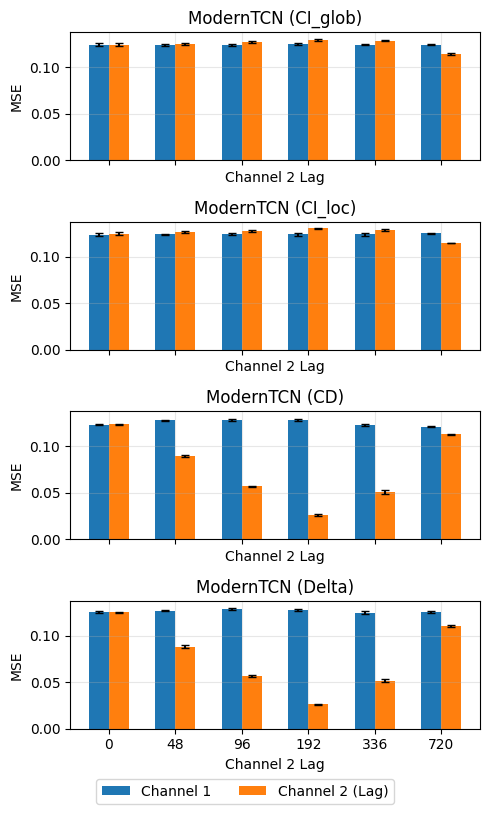

In [18]:

# Example usage
lag(pred_len=pred_len_list, data_path_list=data_path_list, df_subset=df_avg, model="ModernTCN")

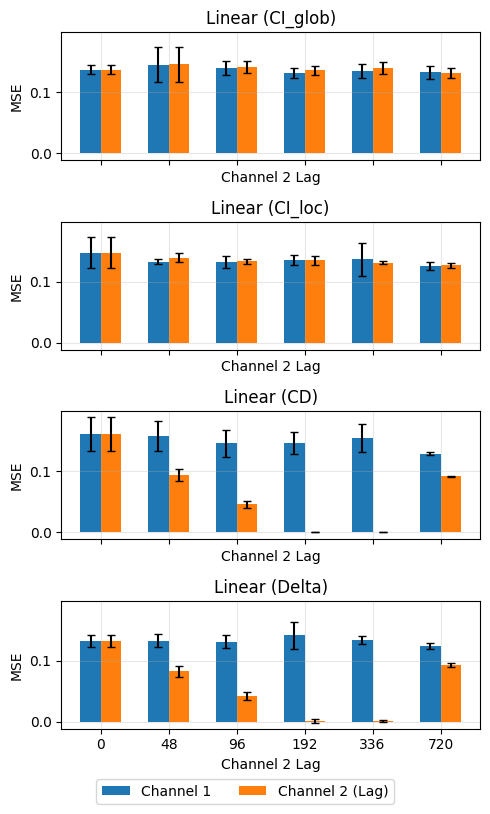

In [19]:
lag(pred_len=pred_len_list, data_path_list=data_path_list, df_subset=df_avg, model="Linear")

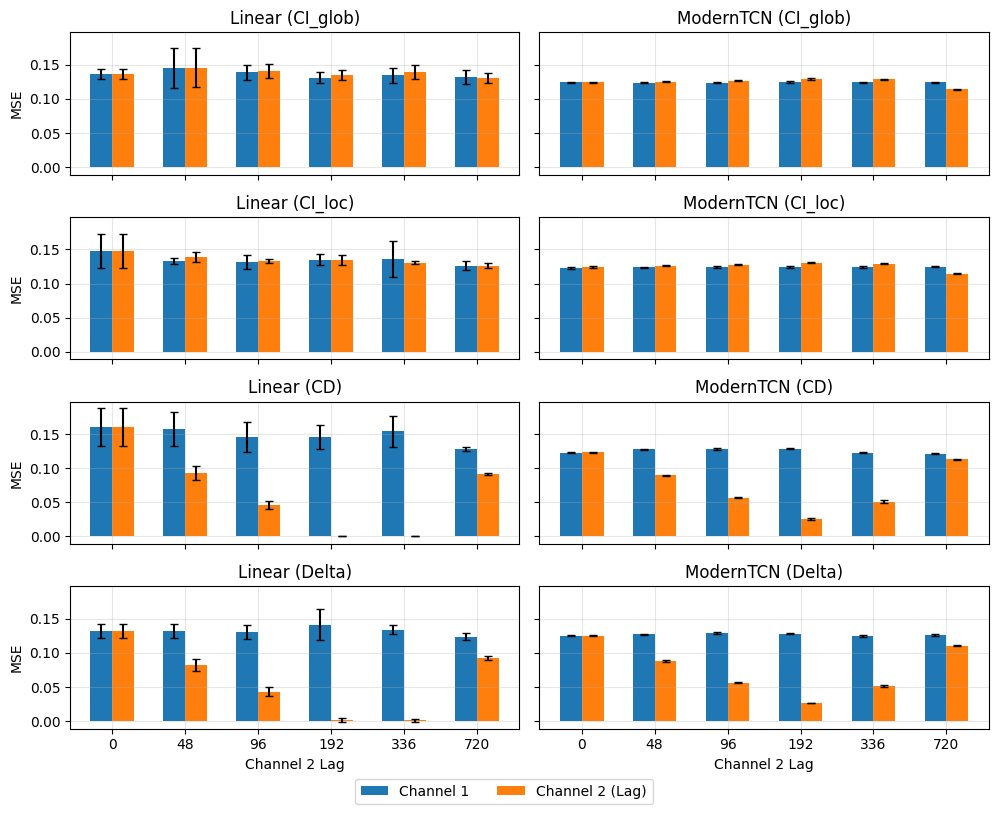

Saved to: plots/Thesis/Lag_Linear_vs_ModernTCN_Pred_192.png


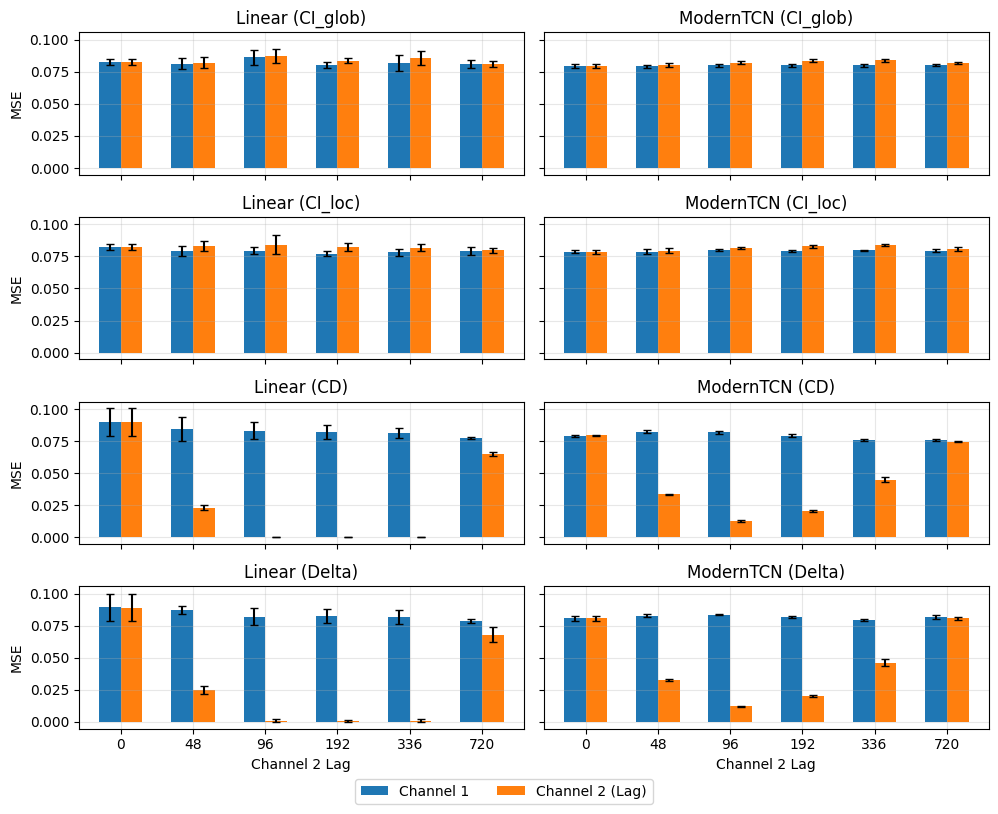

Saved to: plots/Thesis/Lag_Linear_vs_ModernTCN_Pred_96.png


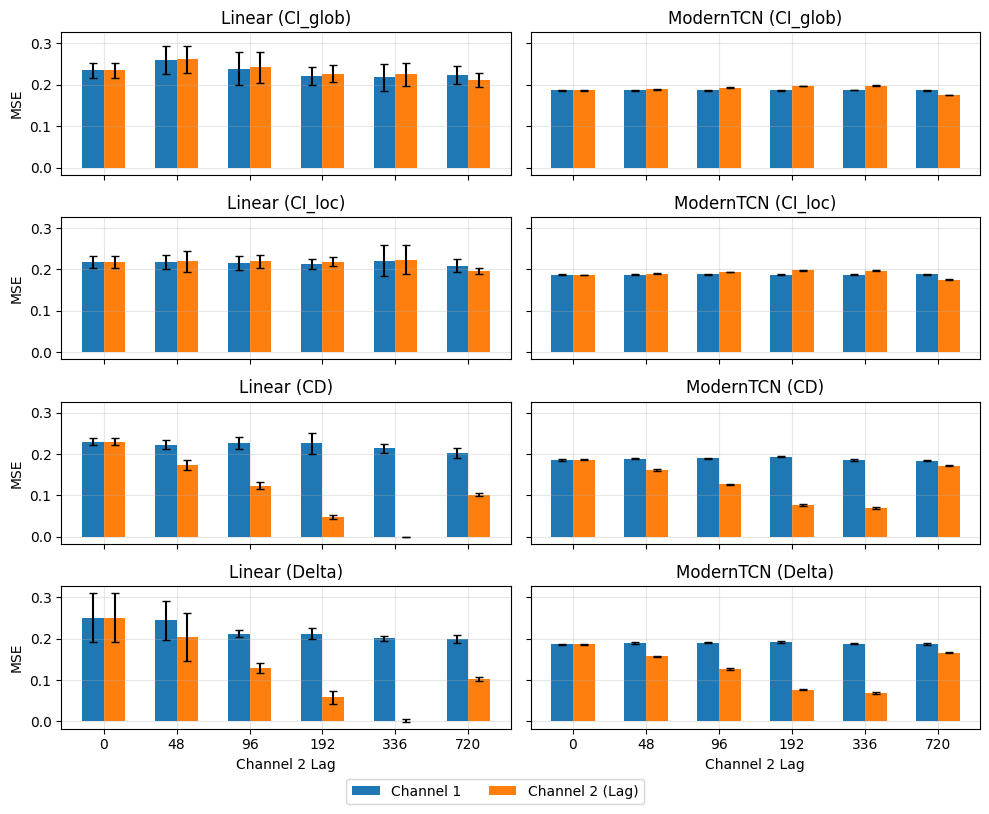

Saved to: plots/Thesis/Lag_Linear_vs_ModernTCN_Pred_336.png


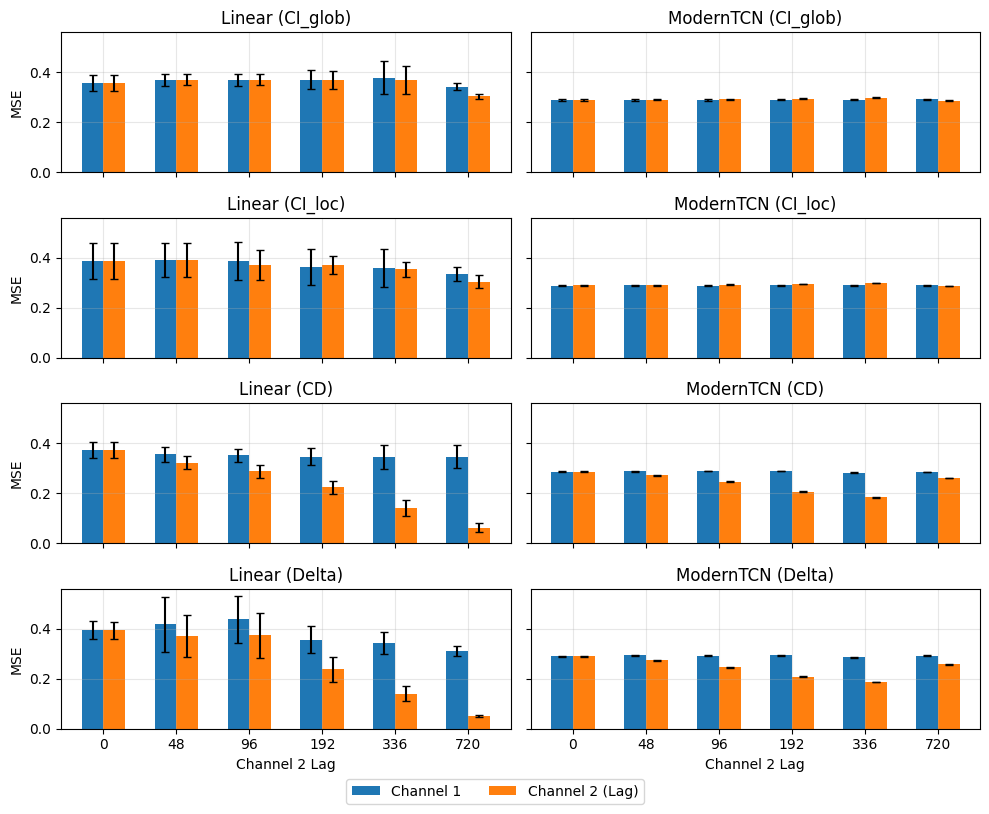

Saved to: plots/Thesis/Lag_Linear_vs_ModernTCN_Pred_720.png


In [20]:

pred_len_list = 192
data_path_list = ["_weather_shower_lag"]
metric = "MSE"

def lag_side_by_side(pred_len=pred_len_list, data_path_list=data_path_list, df_subset=None, models=("Linear","ModernTCN")):
    channel_modes = ["CI_glob", "CI_loc", "CD", "Delta"]
    fig, axs = plt.subplots(len(channel_modes), len(models), figsize=(10, 8), sharey=True, sharex=True)

    # If axs is 2D even for 1x2 or 4x2 cases
    axs = np.atleast_2d(axs)

    for col, model in enumerate(models):
        for row, channel_handling in enumerate(channel_modes):
            ax = axs[row, col]

            # Filter
            df_CI = df_subset[
                (df_subset['model'] == model) &
                (df_subset['channel_handling'] == channel_handling) &
                (df_subset['cd_weight_decay'] == 0.0) &
                (df_subset['data_path'].str.contains("|".join(map(str, data_path_list)))) &
                (df_subset['pred_len'] == pred_len)
            ].copy()

            if df_CI.empty:
                ax.set_title(f'{model} ({channel_handling})')
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.grid(alpha=0.3)
                continue

            # Extract lag from data_path
            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            # Means & STDs (using TEST only per your current code)
            data_test = df_CI["mse_per_channel_list_means"].tolist()
            std_test  = df_CI["mse_per_channel_list_stds"].tolist()

            means = list(map(list, zip(*data_test)))  # transpose to groups
            stds  = list(map(list, zip(*std_test)))

            x_labels = df_CI['data_lag'].astype(str).tolist()
            group_labels = ['Channel 1', 'Channel 2 (Lag)']

            bar_width = 0.3
            x = np.arange(len(x_labels))

            for l, (group_mean, group_std) in enumerate(zip(means, stds)):
                offset = (l - len(means)/2 + 0.5) * bar_width
                ax.bar(
                    x + offset,
                    group_mean,
                    width=bar_width,
                    yerr=group_std,
                    capsize=3,
                    label=group_labels[l]
                )

            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
            if col == 0:
                ax.set_ylabel(metric)
            if row == len(channel_modes) - 1:
                ax.set_xlabel("Channel 2 Lag")
            ax.set_title(f'{model} ({channel_handling})')
            ax.grid(alpha=0.3)

    # Shared legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0.01, 1, 1])  # leave space for legend
    os.makedirs("plots/Thesis", exist_ok=True)
    outpath = f"plots/Thesis/Lag_{models[0]}_vs_{models[1]}_Pred_{pred_len}.png"
    plt.savefig(outpath, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Saved to: {outpath}")

# Example usage
lag_side_by_side(pred_len=192, data_path_list=data_path_list, df_subset=df_avg, models=("Linear","ModernTCN"))

lag_side_by_side(pred_len=96, data_path_list=data_path_list, df_subset=df_avg, models=("Linear","ModernTCN"))
lag_side_by_side(pred_len=336, data_path_list=data_path_list, df_subset=df_avg, models=("Linear","ModernTCN"))
lag_side_by_side(pred_len=720, data_path_list=data_path_list, df_subset=df_avg, models=("Linear","ModernTCN"))


In [21]:
"""
# Only keep Linear CD / Delta for weight decay 1
df_avg = df_avg[~(
    (df_avg["model"] == "Linear") &
    (df_avg["cd_weight_decay"] != 1) &
    (df_avg["channel_handling"].isin(["CD", "Delta"]))
)]
"""

group_100 = {"ETTh1", "ETTh2", "Exchange"}
group_10  = {"ETTm1", "ETTm2", "Weather", "ILI"}

cond_target = (
    (df_avg["model"] == "Linear") &
    (df_avg["channel_handling"].isin(["CD", "Delta"]))
)

keep_decay = (
    (df_avg["data_path"].isin(group_100) & (df_avg["cd_weight_decay"] == 100)) |
    (df_avg["data_path"].isin(group_10)  & (df_avg["cd_weight_decay"] == 10))
)

# Keep everything outside the target subset, and within the target subset keep only matching decays
mask = (~cond_target) | (cond_target & keep_decay)
df_avg = df_avg[mask].copy()

display(df_avg)



model                       data_path pred_len random_seed  \
0        Linear                           ETTh1      192         Avg   
1        Linear                           ETTh1      336         Avg   
2        Linear                           ETTh1      720         Avg   
3        Linear                           ETTh1       96         Avg   
4        Linear                           ETTh1      Avg         Avg   
...         ...                             ...      ...         ...   
1255  ModernTCN  _weather_shower_lag_720_T_degC       96         Avg   
1256  ModernTCN  _weather_shower_lag_720_T_degC      192         Avg   
1257  ModernTCN  _weather_shower_lag_720_T_degC      336         Avg   
1258  ModernTCN  _weather_shower_lag_720_T_degC      720         Avg   
1259  ModernTCN  _weather_shower_lag_720_T_degC      Avg         Avg   

      mse_mean   mse_std  mae_mean   mae_std  mse_train_mean  mse_train_std  \
0     0.428359  0.010755  0.440656  0.010571        0.399685       0.008815   
1     0.463995  0.012235  0.465188  0.011130        0.450571       0.009280   
2     0.515326  0.023620  0.520389  0.016407        0.526693       0.013299   
3     0.385369  0.013068  0.409559  0.013310        0.341039       0.011280   
4     0.448262  0.051021  0.458948  0.043327        0.429497       0.070672   
...        ...       ...       ...       ...             ...            ...   
1255  0.081199  0.001373  0.204995  0.001557        0.105132       0.001499   
1256  0.118220  0.001082  0.248884  0.001263        0.153015       0.001902   
1257  0.176664  0.001516  0.306005  0.001347        0.204888       0.003700   
1258  0.274696  0.002319  0.388735  0.001632        0.250794       0.001299   
1259  0.162695  0.074987  0.287155  0.070516        0.178457       0.056130   

      ...                                    Avg_values_RanS  Avg_Count_RanS  \
0     ...                     [2021, 2022, 2023, 2024, 2025]               5   
1     ...                     [2021, 2022, 2023, 2024, 2025]               5   
2     ...                     [2021, 2022, 2023, 2024, 2025]               5   
3     ...                     [2022, 2023, 2024, 2025, 2021]               5   
4     ...  [2021, 2021, 2021, 2022, 2022, 2022, 2022, 202...              20   
...   ...                                                ...             ...   
1255  ...                     [2021, 2022, 2023, 2024, 2025]               5   
1256  ...                     [2021, 2022, 2023, 2024, 2025]               5   
1257  ...                     [2021, 2022, 2023, 2024, 2025]               5   
1258  ...                     [2021, 2022, 2023, 2024, 2025]               5   
1259  ...  [2021, 2021, 2021, 2021, 2022, 2022, 2022, 202...              20   

                             mse_per_channel_list_means  \
0     [0.8228135108947754, 0.24596365988254548, 0.84...   
1     [0.8598625302314759, 0.26672130823135376, 0.87...   
2     [0.7985777378082275, 0.32062711119651793, 0.78...   
3     [0.7591026425361633, 0.215773868560791, 0.7838...   
4     [0.8100891053676605, 0.26227148696780206, 0.82...   
...                                                 ...   
1255          [0.0817288801074028, 0.08066987097263337]   
1256          [0.1257843405008316, 0.11065521389245987]   
1257           [0.18680073022842408, 0.166527259349823]   
1258           [0.2916865348815918, 0.2577050864696503]   
1259         [0.17150012142956256, 0.15388935767114162]   

                             mae_per_channel_list_means  \
0     [0.6180592536926269, 0.37087311744689944, 0.61...   
1     [0.6311773777008056, 0.3863368630409241, 0.619...   
2     [0.6383005142211914, 0.4306677281856537, 0.613...   
3     [0.5926631808280944, 0.3466036140918732, 0.589...   
4     [0.6200500816106796, 0.3836203306913376, 0.608...   
...                                                 ...   
1255           [0.20616614520549775, 0.203824046254158]   
1256             [0.2565205514431, 0.24124749898910522

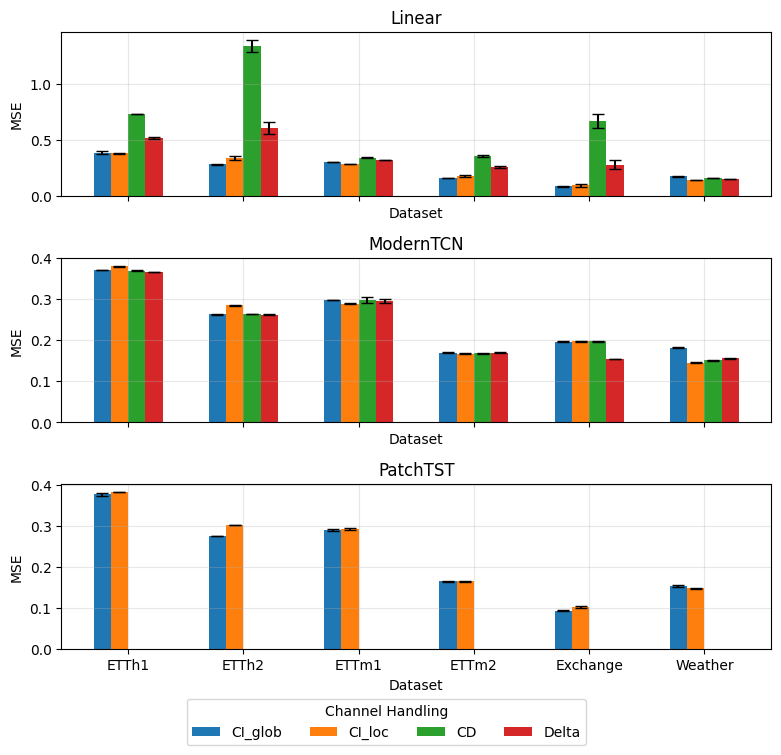

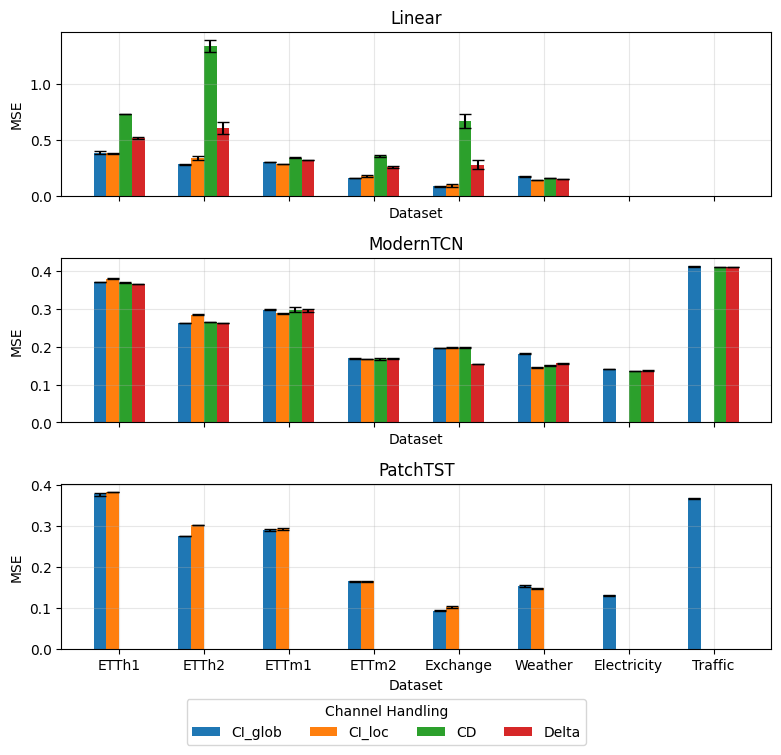

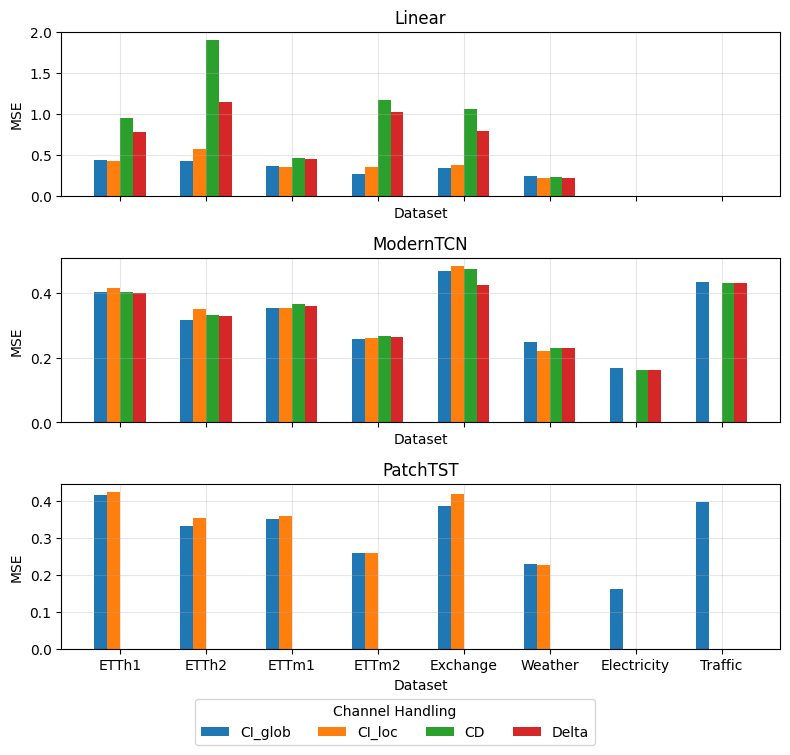

In [22]:


# === Settings ===
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather"]
model_list = ["Linear", "ModernTCN", "PatchTST"]

pred_len = 96

def plot_overview(pred_len=pred_len, model_list=model_list, data_path_list=data_path_list):
    # === Plot setup ===
    n = len(model_list)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5 * n), squeeze=False, sharex=True)

    # Track all handles/labels for a shared legend
    all_handles = []
    all_labels = []

    for idx, model in enumerate(model_list):
        ax = axes[idx][0]

        df_plot = df_avg[
            (df_avg["model"] == model) &
            (df_avg["pred_len"] == pred_len) &
            (df_avg["data_path"].isin(data_path_list))
        ].copy()

        if df_plot.empty:
            ax.set_title(f"{model} (no data)")
            ax.axis("off")
            continue

        channel_handlings = ["CI_glob", "CI_loc", "CD", "Delta"]
        bar_width = 0.15
        x = np.arange(len(data_path_list))

        for i, ch in enumerate(channel_handlings):
            df_ch = df_plot[df_plot["channel_handling"] == ch]

            y_vals = []
            y_errs = []
            for dp in data_path_list:
                row = df_ch[df_ch['data_path'] == dp]
                if not row.empty:
                    y_vals.append(row['mse_mean'].values[0])
                    if pred_len == "Avg":
                        y_errs.append(0)  # skip error bars for average
                    else:
                        y_errs.append(row['mse_std'].values[0])
                else:
                    y_vals.append(np.nan)
                    y_errs.append(0)

            offset = (i - len(channel_handlings)/2) * bar_width + bar_width/2
            bars = ax.bar(
                x + offset,
                y_vals,
                width=bar_width,
                yerr=y_errs if pred_len != "Avg" else None,
                capsize=4 if pred_len != "Avg" else 0,
                label=ch
            )

            # Only collect one handle per channel
            all_handles.append(bars[0])
            all_labels.append(ch)

        ax.set_xticks(x)
        ax.set_xticklabels(data_path_list, rotation=0)
        ax.set_title(f"{model}")
        ax.set_ylabel("MSE")
        ax.set_xlabel("Dataset")
        ax.grid(alpha=0.3)

    # === Shared Legend (deduplicated) ===
    unique = dict(zip(all_labels, all_handles))
    fig.legend(
        unique.values(),
        unique.keys(),
        title="Channel Handling",
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.01)
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs("plots/Thesis", exist_ok=True)
    plt.savefig(f"plots/Thesis/Overview_Pred_{pred_len}.png", bbox_inches='tight', dpi=300)
    plt.show()



plot_overview()

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "Electricity", "Traffic"]
model_list = ["Linear", "ModernTCN", "PatchTST"]

pred_len = 96
plot_overview(pred_len=pred_len, model_list=model_list, data_path_list=data_path_list)

pred_len = "Avg"
plot_overview(pred_len=pred_len, model_list=model_list, data_path_list=data_path_list)

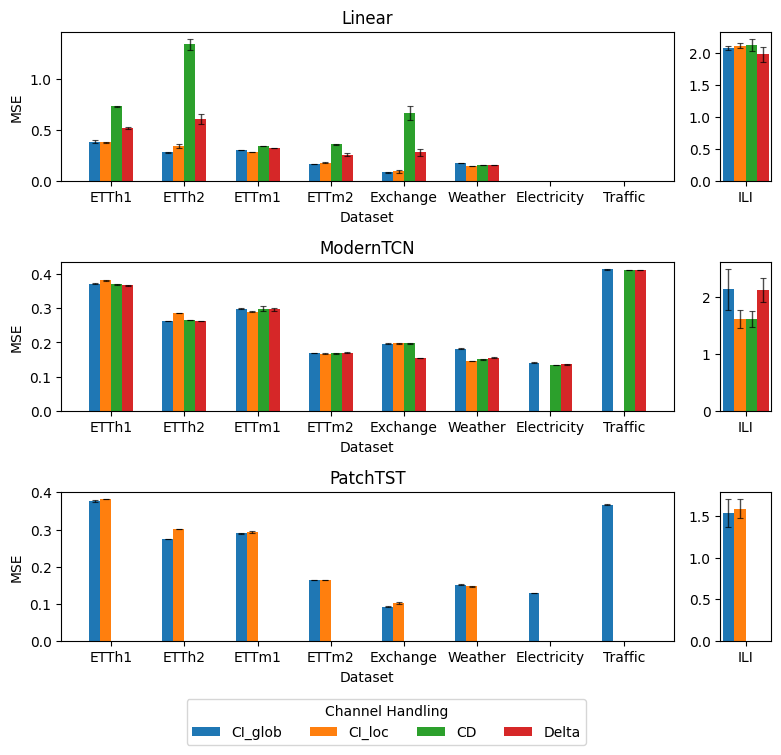

Saved to: plots/Thesis/Overview_Pred_96.png


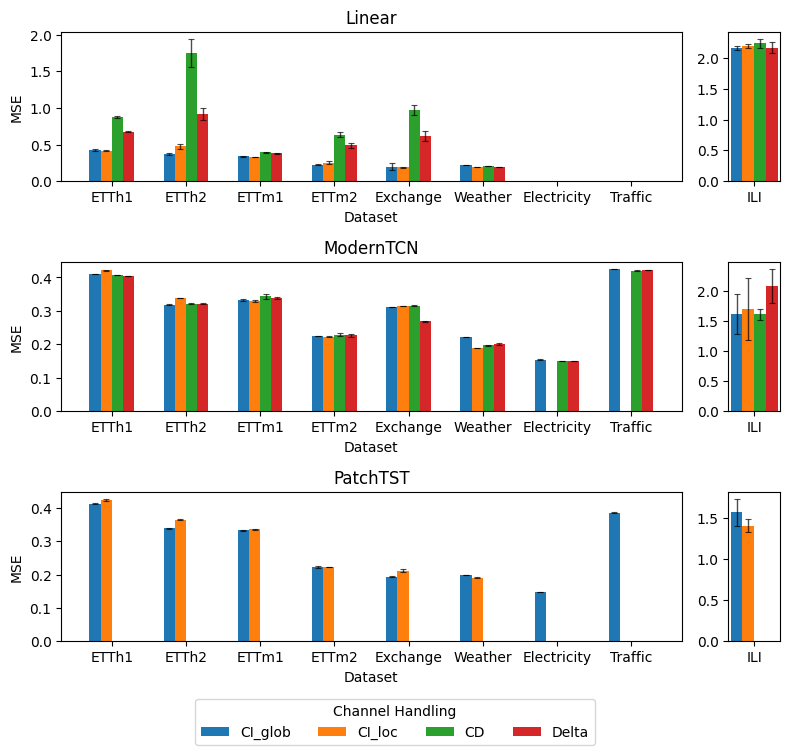

Saved to: plots/Thesis/Overview_Pred_192.png


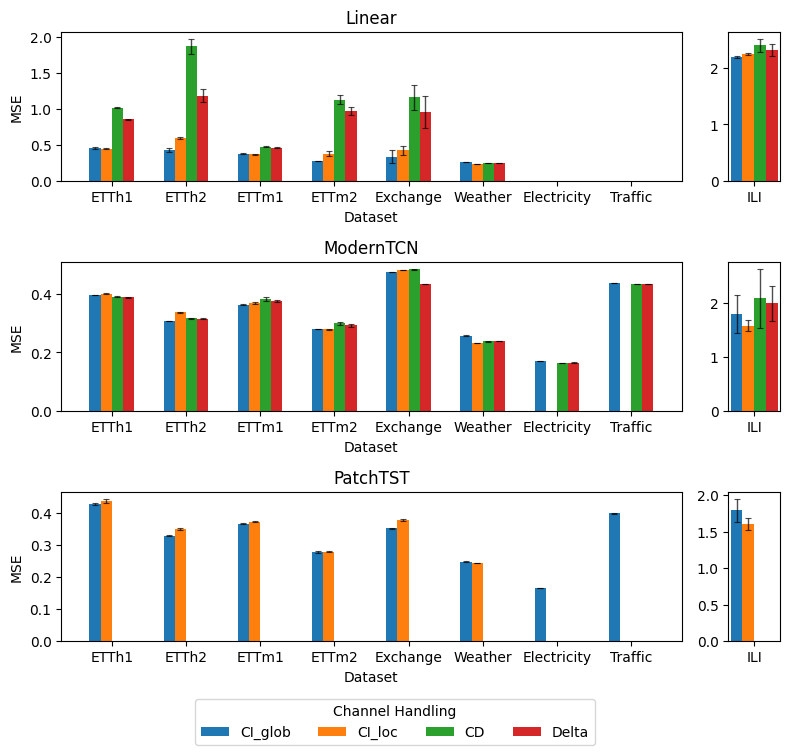

Saved to: plots/Thesis/Overview_Pred_336.png


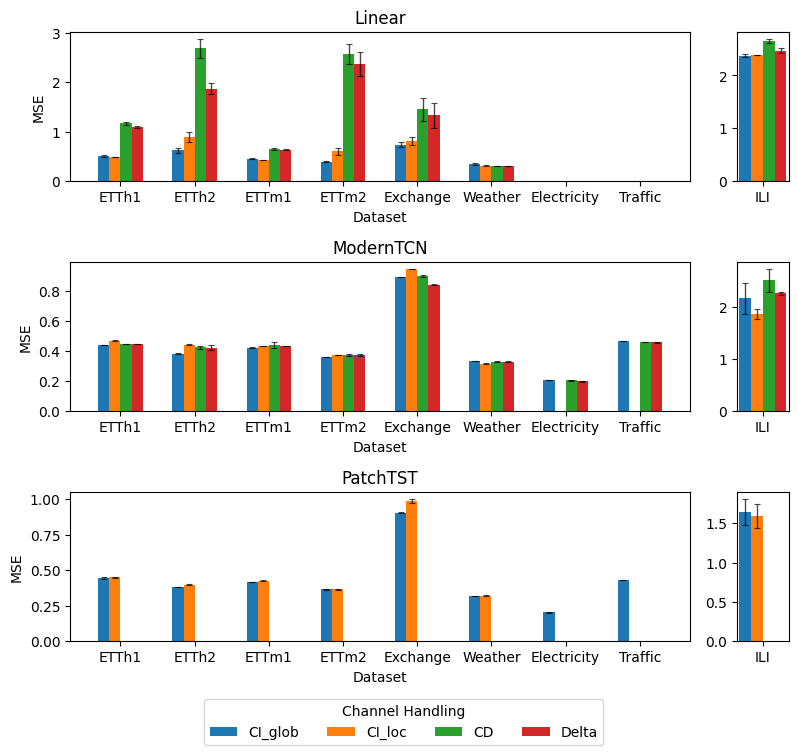

Saved to: plots/Thesis/Overview_Pred_720.png


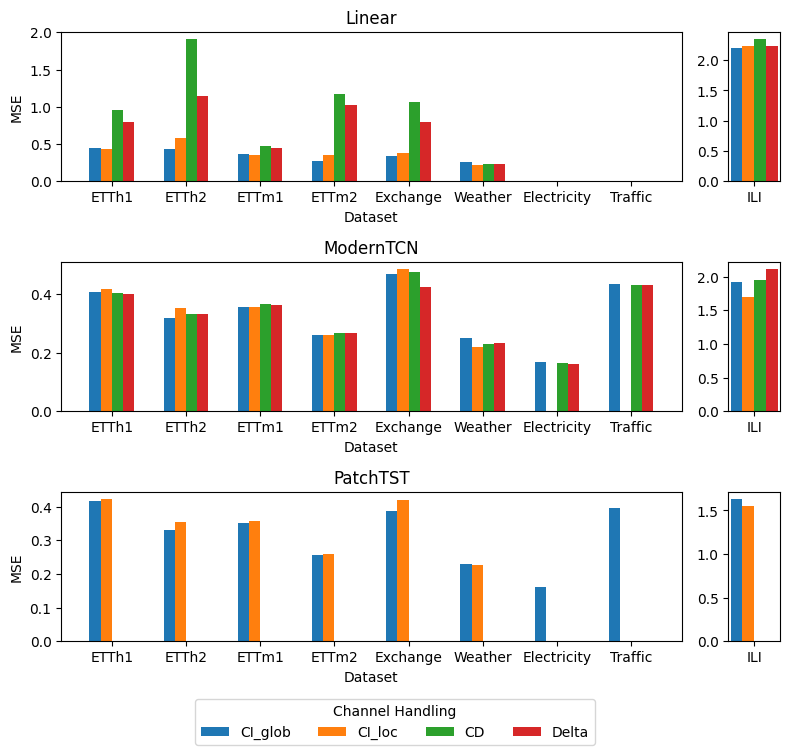

Saved to: plots/Thesis/Overview_Pred_Avg.png


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather"]
model_list = ["Linear", "ModernTCN", "PatchTST"]
pred_len = 96

# Map left-column pred_len -> ILI pred_len
ILI_PRED_MAP = {96: 24, 192: 36, 336: 48, 720: 60}

def map_ili_pred_len(pl):
    if pl == "Avg":
        return "Avg"
    try:
        return ILI_PRED_MAP[int(pl)]
    except (ValueError, KeyError):
        return pl

def plot_overview_two_cols(pred_len=pred_len, model_list=model_list, data_path_list=data_path_list, ili_dataset="ILI"):
    n = len(model_list)
    fig, axes = plt.subplots(n, 2, figsize=(8, 2.5 * n), gridspec_kw={'width_ratios': [12, 1]})

    # Share x-axis per column
    for col in range(2):
        for row in range(1, n):
            axes[row, col].sharex(axes[0, col])

    # Shared legend collections
    all_handles, all_labels = [], []

    channel_handlings = ["CI_glob", "CI_loc", "CD", "Delta"]
    bar_width = 0.15

    # Subtle error-bar style
    eb_style = dict(
        elinewidth=1,
        capsize=2,       # set 0 to remove caps entirely
        capthick=0.8,
        #ecolor="0.7",
        ecolor="black",
        alpha=0.7,
        zorder=3
    )

    def plot_panel(ax, df_plot, datasets, model, panel_label):
        if df_plot.empty:
            ax.set_title(f"{model} — {panel_label} (no data)")
            ax.axis("off")
            return

        x = np.arange(len(datasets))
        for i, ch in enumerate(channel_handlings):
            df_ch = df_plot[df_plot["channel_handling"] == ch]

            y_vals, y_errs = [], []
            for dp in datasets:
                row = df_ch[df_ch["data_path"] == dp]
                if not row.empty:
                    y_vals.append(row["mse_mean"].values[0])
                    y_errs.append(0 if pred_len == "Avg" else row["mse_std"].values[0])
                else:
                    y_vals.append(np.nan)
                    y_errs.append(0)

            offset = (i - len(channel_handlings) / 2) * bar_width + bar_width / 2
            bars = ax.bar(
                x + offset,
                y_vals,
                width=bar_width,
                yerr=None if pred_len == "Avg" else y_errs,
                error_kw=None if pred_len == "Avg" else eb_style,
                capsize=0 if pred_len == "Avg" else 0,  # keep caps controlled by error_kw
                edgecolor="none"  # optional: avoids thick edges around bars
            )
            # collect one handle per channel
            all_handles.append(bars[0])
            all_labels.append(ch)

        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=0)
        if panel_label != "ILI only":
            ax.set_title(f"{model}")
            ax.set_ylabel("MSE")
            ax.set_xlabel("Dataset")
        #ax.grid(alpha=0.3)

    for idx, model in enumerate(model_list):
        # Left: selected datasets
        df_left = df_avg[
            (df_avg["model"] == model) &
            (df_avg["pred_len"] == pred_len) &
            (df_avg["data_path"].isin(data_path_list))
        ].copy()
        plot_panel(axes[idx, 0], df_left, data_path_list, model, "selected")

        # Right: ILI only (mapped pred_len)
        ili_len = map_ili_pred_len(pred_len)
        df_right = df_avg[
            (df_avg["model"] == model) &
            (df_avg["pred_len"] == ili_len) &
            (df_avg["data_path"] == ili_dataset)
        ].copy()
        plot_panel(axes[idx, 1], df_right, [ili_dataset], model, "ILI only")

    # Shared legend (deduplicated)
    unique = dict(zip(all_labels, all_handles))
    fig.legend(
        unique.values(),
        unique.keys(),
        title="Channel Handling",
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.01)
    )

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    os.makedirs("plots/Thesis", exist_ok=True)
    out = f"plots/Thesis/Overview_Pred_{pred_len}.png"
    plt.savefig(out, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"Saved to: {out}")

# Examples
for pred_len in [96, 192, 336, 720, "Avg"]:
    plot_overview_two_cols(
        pred_len=pred_len,
        model_list=["Linear","ModernTCN","PatchTST"],
        data_path_list=["ETTh1","ETTh2","ETTm1","ETTm2","Exchange","Weather","Electricity","Traffic"]
    )


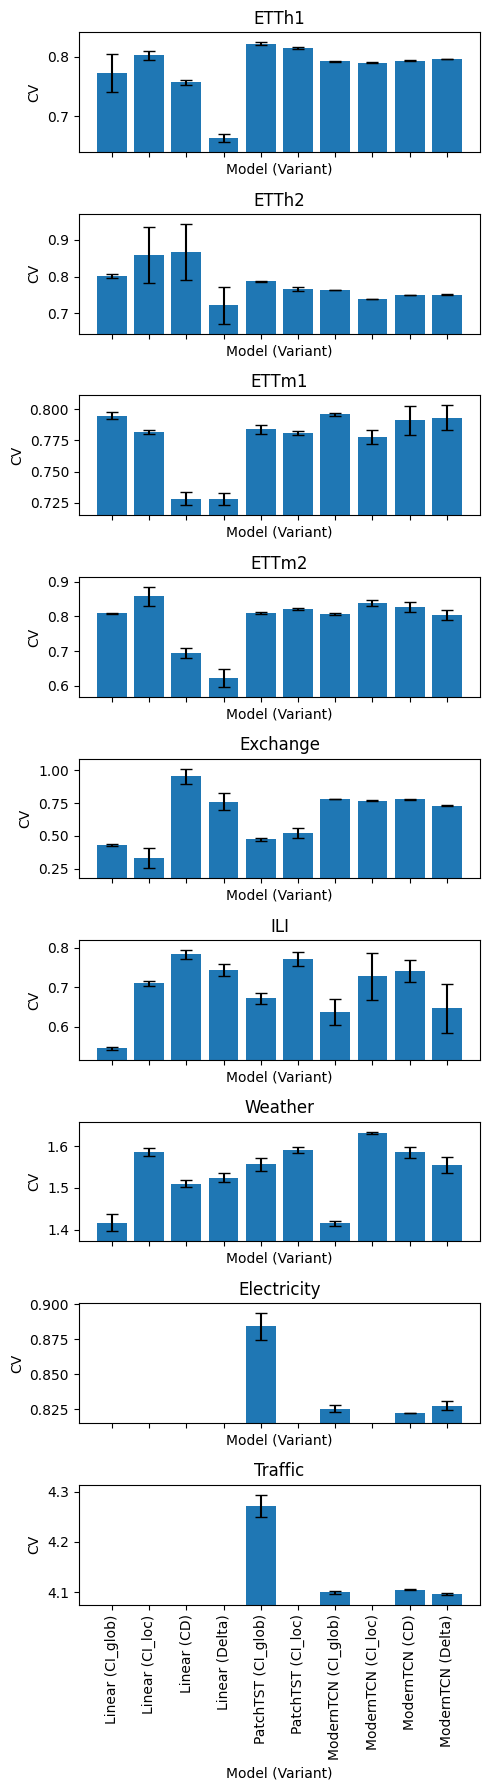

In [24]:

pred_len = 96

#data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "ILI"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]


n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(5, 2 * n), sharex = True , squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    if data_path == "ILI":
        plot_len = map_ili_pred_len(pred_len)
    else:
        plot_len = pred_len

    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["pred_len"] == plot_len)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['cw_mse_std_mean_quot_MEAN']
    yerr = df_plot['cw_mse_std_mean_quot_STD']

    ax.bar(x, y, yerr=yerr, capsize=4)
    ax.set_title(data_path)
    ax.set_xlabel('Model (Variant)')
    
    #ax.set_ylabel('std / mean')
    ax.set_ylabel('CV')
    ymin = min(y - e for y, e in zip(y, yerr))
    ymax = max(y + e for y, e in zip(y, yerr))
    margin = (ymax - ymin) * 0.1  # Add a 10% margin
    ax.set_ylim(ymin - margin, ymax + margin)

    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
plt.savefig(f"plots/Thesis/CW_Std_{pred_len}.png", bbox_inches='tight', dpi=300)
plt.show()


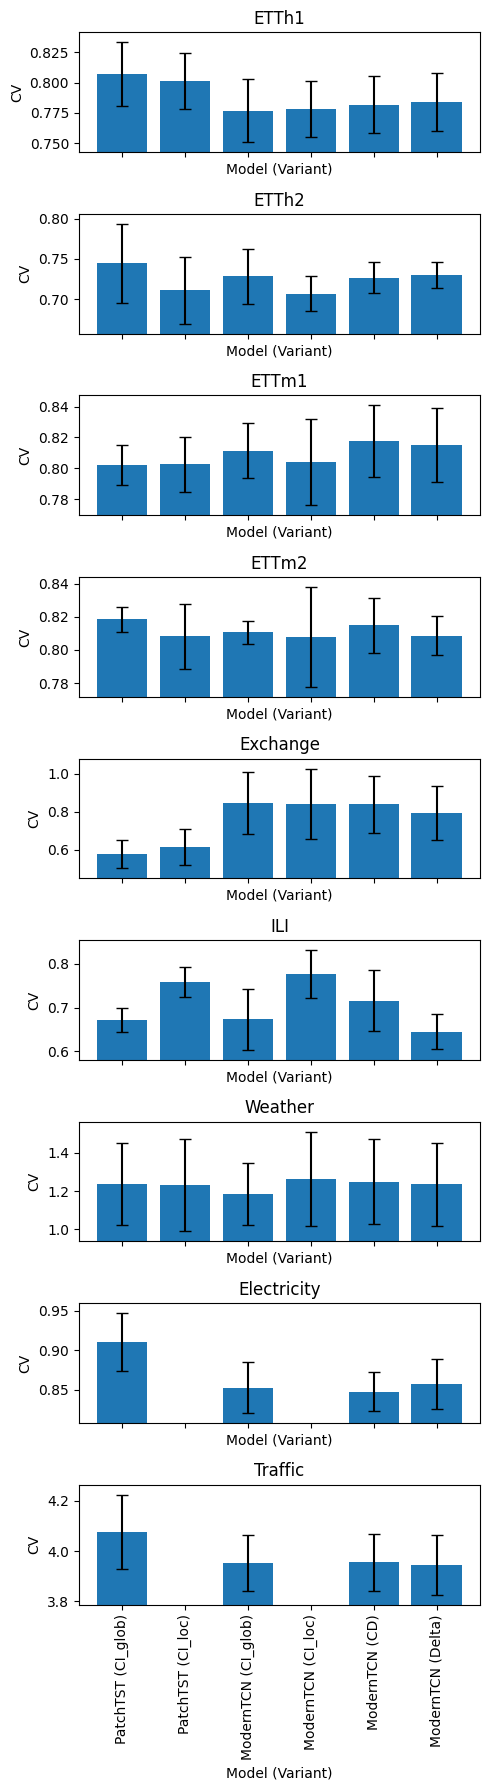

In [25]:

pred_len = 720
pred_len = "Avg"

#data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "ILI"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]


n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(5, 2 * n), sharex = True , squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    if data_path == "ILI":
        plot_len = map_ili_pred_len(pred_len)
    else:
        plot_len = pred_len

    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["model"] != "Linear") &
                     (df_avg["pred_len"] == plot_len)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['cw_mse_std_mean_quot_MEAN']
    yerr = df_plot['cw_mse_std_mean_quot_STD']

    ax.bar(x, y, yerr=yerr, capsize=4)
    ax.set_title(data_path)
    ax.set_xlabel('Model (Variant)')
    
    #ax.set_ylabel('std / mean')
    ax.set_ylabel('CV')
    ymin = min(y - e for y, e in zip(y, yerr))
    ymax = max(y + e for y, e in zip(y, yerr))
    margin = (ymax - ymin) * 0.1  # Add a 10% margin
    ax.set_ylim(ymin - margin, ymax + margin)

    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
plt.savefig(f"plots/Thesis/CW_Std_{pred_len}.png", bbox_inches='tight', dpi=300)
plt.show()


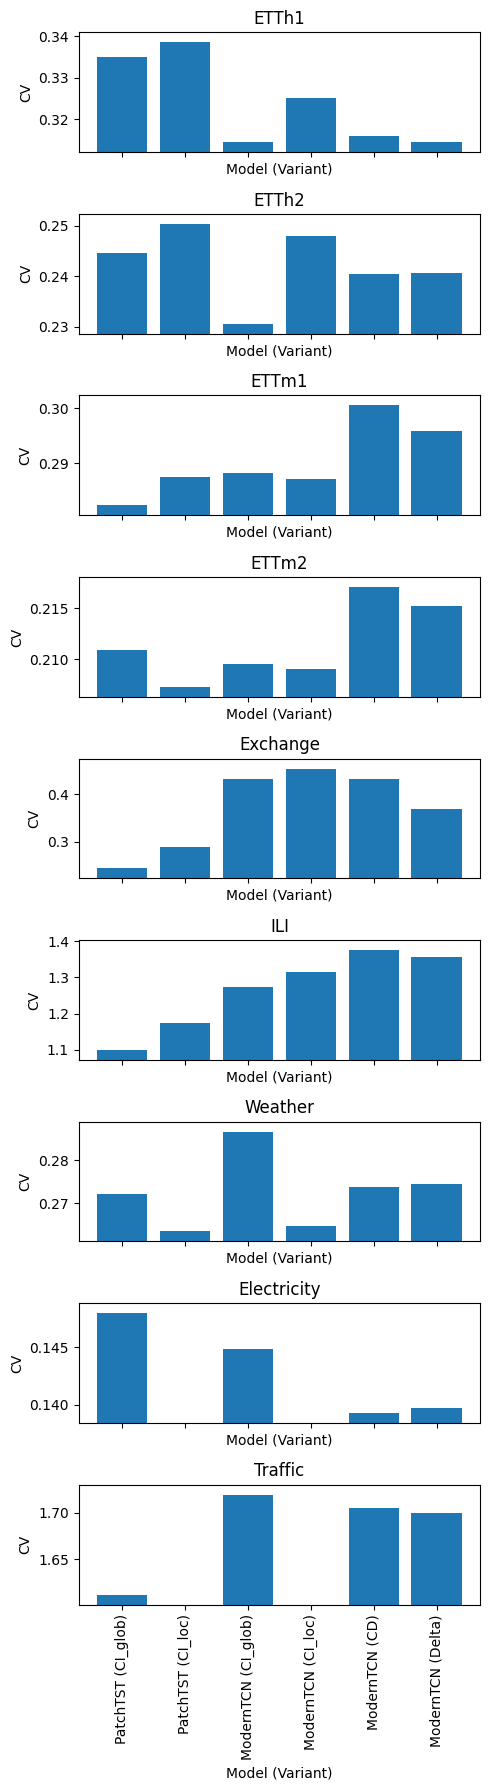

In [26]:

pred_len = 720
pred_len = "Avg"

#data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "ILI"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]


n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(5, 2 * n), sharex = True , squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    if data_path == "ILI":
        plot_len = map_ili_pred_len(pred_len)
    else:
        plot_len = pred_len

    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["model"] != "Linear") &
                     (df_avg["pred_len"] == plot_len)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']

    
    y2 = df_plot['cw_mse_std_mean_quot_MEAN']

    y = df_plot['cw_mse_std_mean']


    yerr = df_plot['cw_mse_std_mean_quot_STD']

    # plot with or without error bars depending on pred_len
    if pred_len == "Avg":
        ax.bar(x, y, capsize=4)
    else:
        ax.bar(x, y, yerr=yerr, capsize=4)

    ax.set_title(data_path)
    ax.set_xlabel('Model (Variant)')
    ax.set_ylabel('CV')

    ymin = min(y - (yerr if pred_len != "Avg" else 0))
    ymax = max(y + (yerr if pred_len != "Avg" else 0))
    margin = (ymax - ymin) * 0.1
    ax.set_ylim(ymin - margin, ymax + margin)

    ax.tick_params(axis='x', rotation=90)


plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
plt.savefig(f"plots/Thesis/CW_Std_{pred_len}.png", bbox_inches='tight', dpi=300)
plt.show()


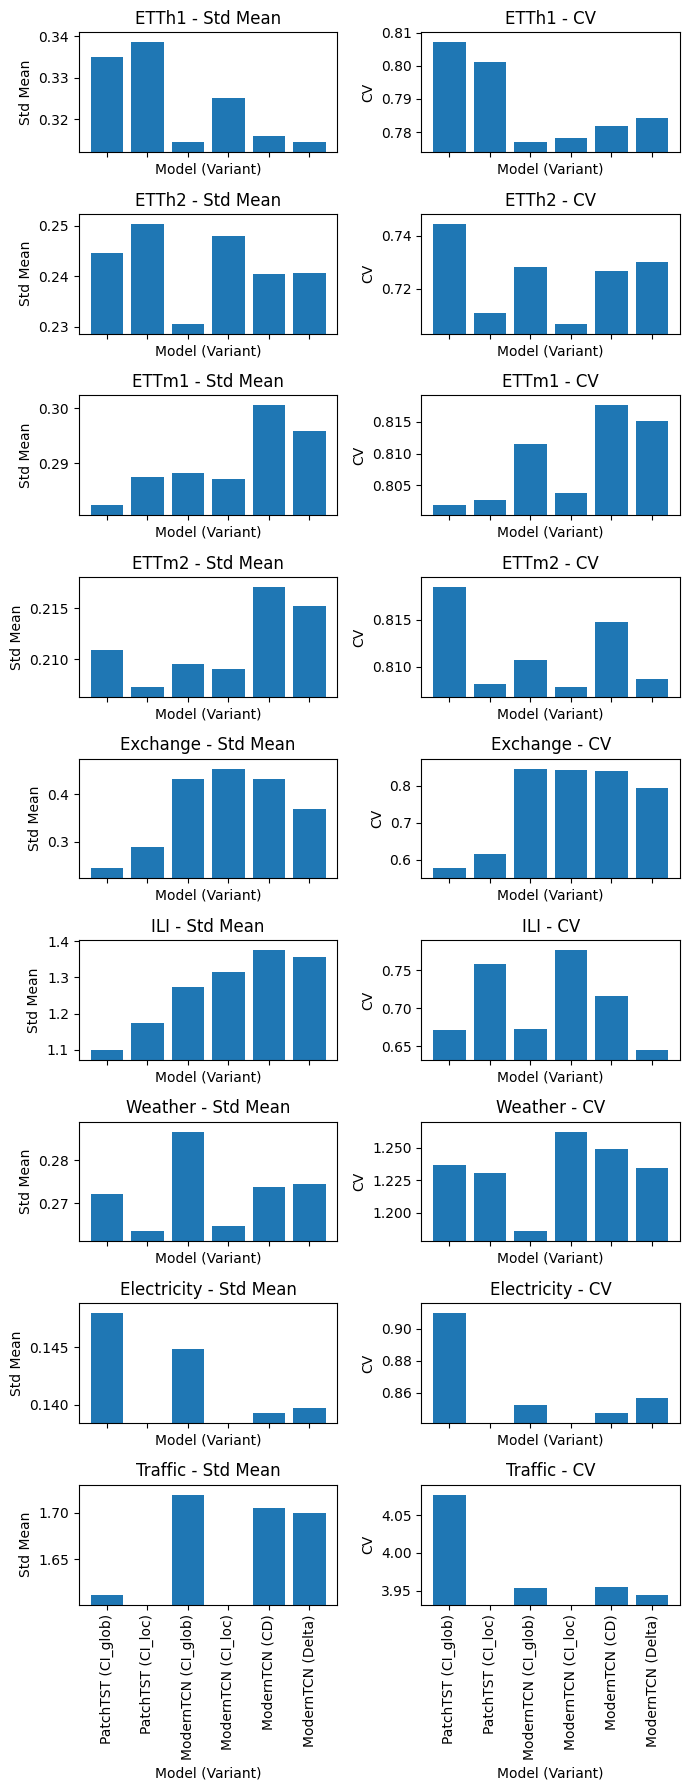

In [27]:
import os
import matplotlib.pyplot as plt

pred_len = 720
pred_len = "Avg"

# data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "ILI"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 2, figsize=(7, 2 * n), sharex=True, squeeze=False)  # n rows, 2 columns

for idx, data_path in enumerate(data_path_list):
    plot_len = map_ili_pred_len(pred_len) if data_path == "ILI" else pred_len

    df_plot = df_avg[
        (df_avg["data_path"] == data_path)
        & (df_avg["model"] != "Linear")
        & (df_avg["pred_len"] == plot_len)
    ].copy()

    ax1, ax2 = axes[idx][0], axes[idx][1]

    if df_plot.empty:
        ax1.set_title(f"{data_path} (no data)")
        ax1.axis("off")
        ax2.set_title(f"{data_path} (no data)")
        ax2.axis("off")
        continue

    x   = df_plot["model_CH"]
    y1   = df_plot["mse_mean"]                 # left column
    y   = df_plot["cw_mse_std_mean"]                 # middle column
    y2  = df_plot["cw_mse_std_mean_quot_MEAN"]       # right column (CV)
    yerr = df_plot["cw_mse_std_mean_quot_STD"]

    # ---------------- Left subplot: y (with conditional error bars) ----------------
    if pred_len == "Avg":
        ax1.bar(x, y, capsize=4)
        y_min_vals = y
        y_max_vals = y
    else:
        ax1.bar(x, y, yerr=yerr, capsize=4)
        y_min_vals = y - yerr
        y_max_vals = y + yerr

    ax1.set_title(f"{data_path} - Std Mean")
    ax1.set_xlabel("Model (Variant)")
    ax1.set_ylabel("Std Mean")
    ymin = float(y_min_vals.min())
    ymax = float(y_max_vals.max())
    margin = max((ymax - ymin) * 0.1, 1e-6)  # small epsilon to avoid identical limits
    ax1.set_ylim(ymin - margin, ymax + margin)
    ax1.tick_params(axis="x", rotation=90)

    # ---------------- Right subplot: y2 (CV, no error bars) ----------------
    ax2.bar(x, y2, capsize=4)
    ax2.set_title(f"{data_path} - CV")
    ax2.set_xlabel("Model (Variant)")
    ax2.set_ylabel("CV")
    ymin2 = float(y2.min())
    ymax2 = float(y2.max())
    margin2 = max((ymax2 - ymin2) * 0.1, 1e-6)
    ax2.set_ylim(ymin2 - margin2, ymax2 + margin2)
    ax2.tick_params(axis="x", rotation=90)

plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
#plt.savefig(f"plots/Thesis/CW_Std_{pred_len}_2cols.png", bbox_inches="tight", dpi=300)
plt.show()


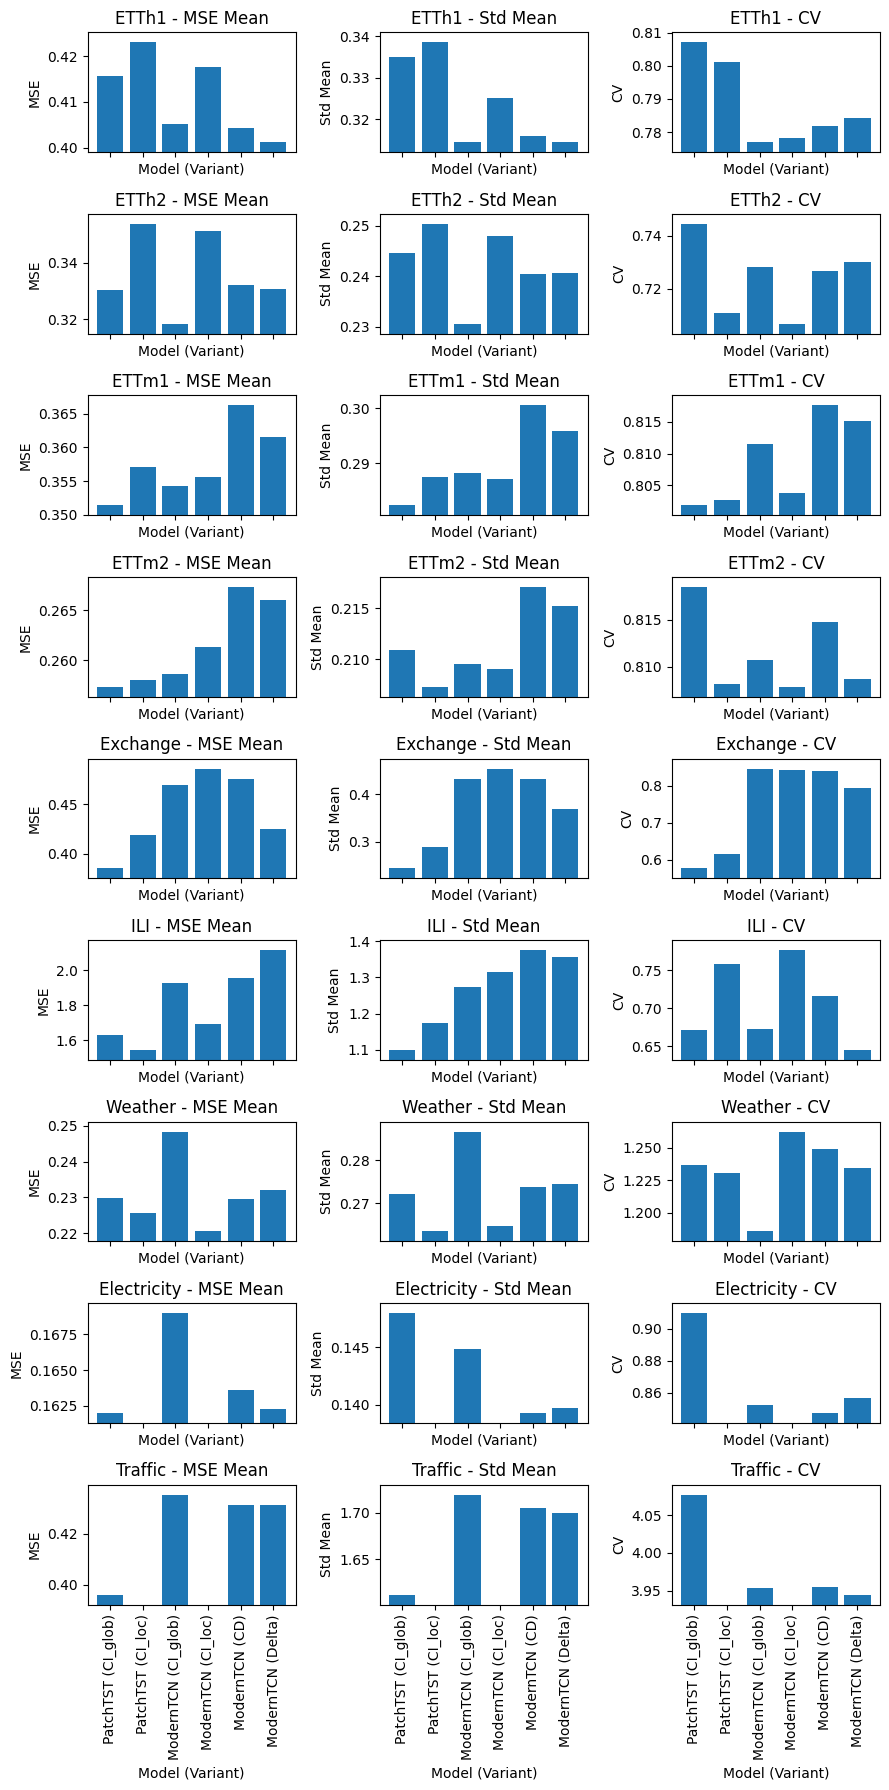

In [28]:
import os
import matplotlib.pyplot as plt

pred_len = 720
pred_len = "Avg"

# data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "ILI"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 3, figsize=(9, 2 * n), sharex=True, squeeze=False)  # n rows, 3 columns

for idx, data_path in enumerate(data_path_list):
    plot_len = map_ili_pred_len(pred_len) if data_path == "ILI" else pred_len

    df_plot = df_avg[
        (df_avg["data_path"] == data_path)
        & (df_avg["model"] != "Linear")
        & (df_avg["pred_len"] == plot_len)
    ].copy()

    ax1, ax2, ax3 = axes[idx][0], axes[idx][1], axes[idx][2]

    if df_plot.empty:
        for ax in [ax1, ax2, ax3]:
            ax.set_title(f"{data_path} (no data)")
            ax.axis("off")
        continue

    x   = df_plot["model_CH"]
    y1  = df_plot["mse_mean"]                    # first column
    y   = df_plot["cw_mse_std_mean"]             # second column
    y2  = df_plot["cw_mse_std_mean_quot_MEAN"]   # third column (CV)
    yerr = df_plot["cw_mse_std_mean_quot_STD"]

    # ---------------- Column 1: y1 (MSE Mean) ----------------
    ax1.bar(x, y1, capsize=4)
    ax1.set_title(f"{data_path} - MSE Mean")
    ax1.set_xlabel("Model (Variant)")
    ax1.set_ylabel("MSE")
    ymin1, ymax1 = float(y1.min()), float(y1.max())
    margin1 = max((ymax1 - ymin1) * 0.1, 1e-6)
    ax1.set_ylim(ymin1 - margin1, ymax1 + margin1)
    ax1.tick_params(axis="x", rotation=90)

    # ---------------- Column 2: y (Std Mean, conditional error bars) ----------------
    if pred_len == "Avg":
        ax2.bar(x, y, capsize=4)
        y_min_vals = y
        y_max_vals = y
    else:
        ax2.bar(x, y, yerr=yerr, capsize=4)
        y_min_vals = y - yerr
        y_max_vals = y + yerr

    ax2.set_title(f"{data_path} - Std Mean")
    ax2.set_xlabel("Model (Variant)")
    ax2.set_ylabel("Std Mean")
    ymin = float(y_min_vals.min())
    ymax = float(y_max_vals.max())
    margin = max((ymax - ymin) * 0.1, 1e-6)
    ax2.set_ylim(ymin - margin, ymax + margin)
    ax2.tick_params(axis="x", rotation=90)

    # ---------------- Column 3: y2 (CV, no error bars) ----------------
    ax3.bar(x, y2, capsize=4)
    ax3.set_title(f"{data_path} - CV")
    ax3.set_xlabel("Model (Variant)")
    ax3.set_ylabel("CV")
    ymin2, ymax2 = float(y2.min()), float(y2.max())
    margin2 = max((ymax2 - ymin2) * 0.1, 1e-6)
    ax3.set_ylim(ymin2 - margin2, ymax2 + margin2)
    ax3.tick_params(axis="x", rotation=90)

plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
#plt.savefig(f"plots/Thesis/CW_Std_{pred_len}_3cols.png", bbox_inches="tight", dpi=300)
plt.show()


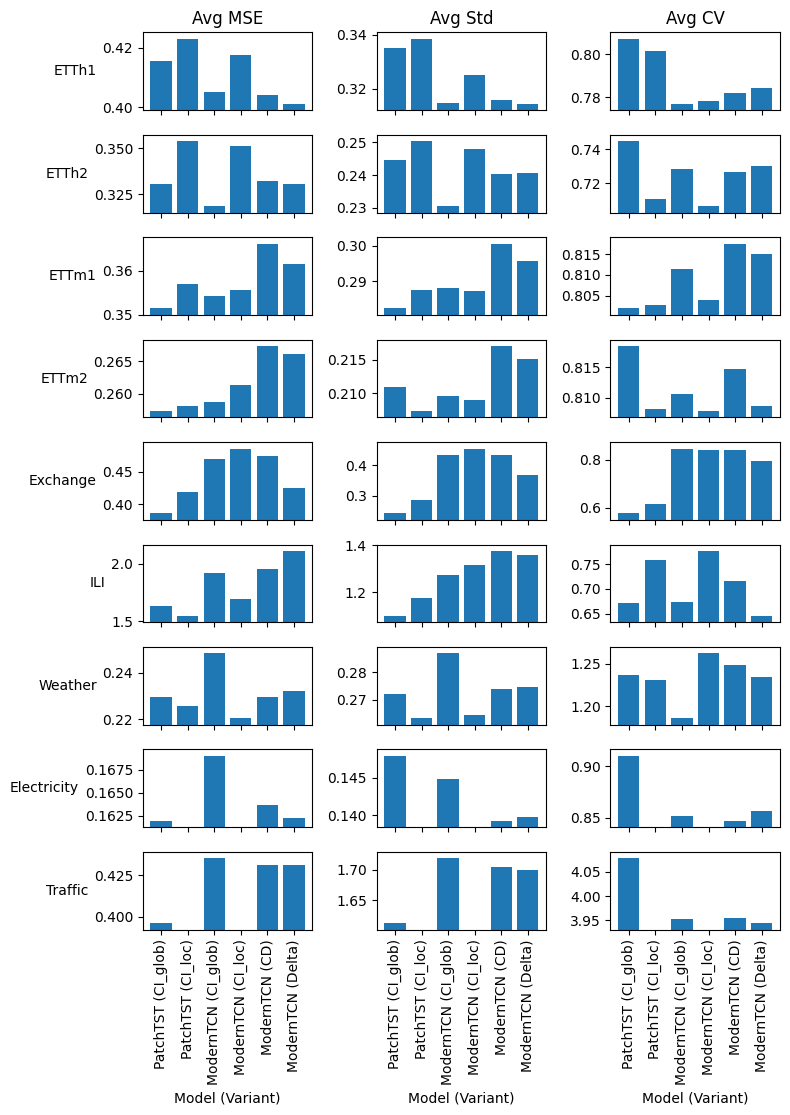

In [29]:
import os
import matplotlib.pyplot as plt

pred_len = 720
pred_len = "Avg"

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "ILI", "Weather", "Electricity", "Traffic"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 3, figsize=(8, 1.25 * n), sharex=True, squeeze=False)  # n rows, 3 columns

for idx, data_path in enumerate(data_path_list):
    plot_len = map_ili_pred_len(pred_len) if data_path == "ILI" else pred_len

    df_plot = df_avg[
        (df_avg["data_path"] == data_path)
        & (df_avg["model"] != "Linear")
        & (df_avg["pred_len"] == plot_len)
    ].copy()

    ax1, ax2, ax3 = axes[idx]

    if df_plot.empty:
        for ax in [ax1, ax2, ax3]:
            ax.axis("off")
        # put dataset label even if no data
        ax1.set_ylabel(data_path, rotation=0, ha="right", va="center", fontsize=10)
        continue

    x   = df_plot["model_CH"]
    y1  = df_plot["mse_mean"]                  
    y   = df_plot["cw_mse_std_mean"]           
    y2  = df_plot["cw_mse_std_mean_quot_MEAN"] 
    yerr = df_plot["cw_mse_std_mean_quot_STD"]

    # --- Column 1: y1 (MSE Mean) ---
    ax1.bar(x, y1, capsize=4)
    ymin1, ymax1 = float(y1.min()), float(y1.max())
    margin1 = max((ymax1 - ymin1) * 0.1, 1e-6)
    ax1.set_ylim(ymin1 - margin1, ymax1 + margin1)

    # --- Column 2: y (Std Mean) ---
    if pred_len == "Avg":
        ax2.bar(x, y, capsize=4)
        y_min_vals, y_max_vals = y, y
    else:
        ax2.bar(x, y, yerr=yerr, capsize=4)
        y_min_vals, y_max_vals = y - yerr, y + yerr
    ymin, ymax = float(y_min_vals.min()), float(y_max_vals.max())
    margin = max((ymax - ymin) * 0.1, 1e-6)
    ax2.set_ylim(ymin - margin, ymax + margin)

    # --- Column 3: y2 (CV) ---
    ax3.bar(x, y2, capsize=4)
    ymin2, ymax2 = float(y2.min()), float(y2.max())
    margin2 = max((ymax2 - ymin2) * 0.1, 1e-6)
    ax3.set_ylim(ymin2 - margin2, ymax2 + margin2)

    # only show dataset name once per row (on the left side)
    ax1.set_ylabel(data_path, rotation=0, ha="right", va="center", fontsize=10)

    # rotate xticks
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis="x", rotation=90)

# Set column titles once at the top
axes[0][0].set_title("Avg MSE")
axes[0][1].set_title("Avg Std")
axes[0][2].set_title("Avg CV")

# Add common x label
for ax in axes[-1]:
    ax.set_xlabel("Model (Variant)")

plt.tight_layout()
os.makedirs("plots/Thesis", exist_ok=True)
plt.savefig(f"plots/Thesis/CW_Std_{pred_len}_3cols.png", bbox_inches="tight", dpi=300)
plt.show()


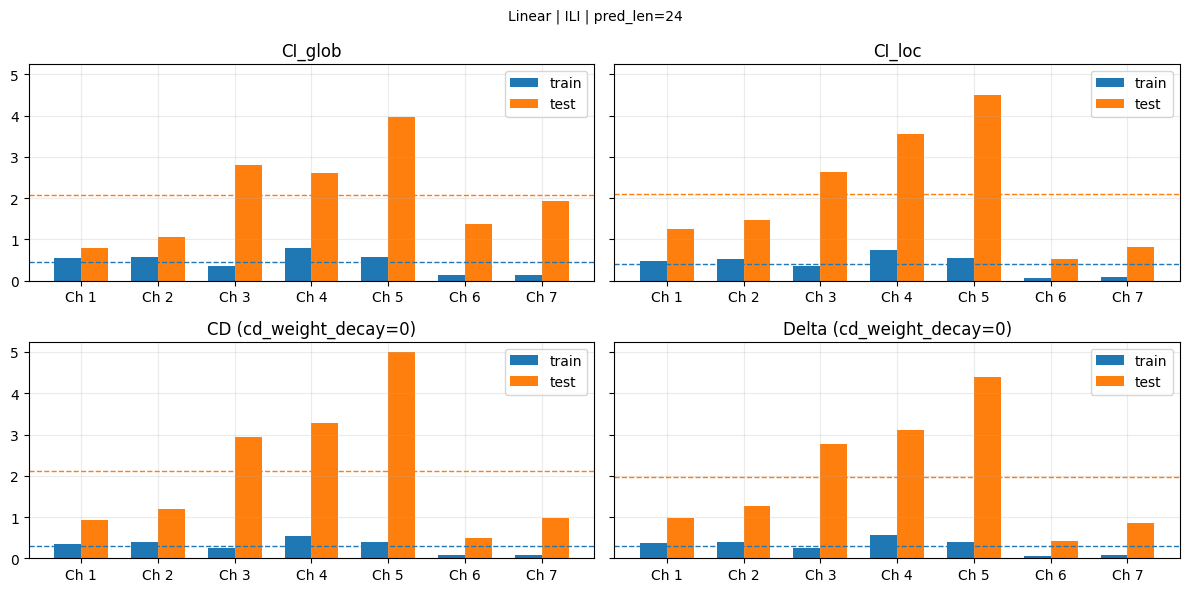

In [30]:
def channel_wise(df_subset, pred_len=24, data_path="ILI", model="Linear", m_type= [["CI_glob", 0], ["CI_loc", 0], ["CD", 0], ["Delta", 0]]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)

    if model=="PatchTST":
        rows = [0]
    else:
        rows = [0, 1]
    
    for row in rows:
        for col in [0, 1]:
            ax = axs[row, col]
            channel_handling = m_type[2*row+col][0]
            cd_weight_decay = m_type[2*row+col][1]

            df_CI = df_subset[
                (df_subset['model'] == model) &
                (df_subset['channel_handling'] == channel_handling) &
                (df_subset['data_path'] == data_path) &
                (df_subset['pred_len'] == pred_len)
            ].copy()

            #display(df_CI)
            
            # Extract lists
            data_train = df_CI["mse_train_per_channel_list_means"].tolist()
            data_test = df_CI["mse_per_channel_list_means"].tolist()

            # Combine per channel
            combined = [[train, test] for train, test in zip(data_train[0], data_test[0])]

            data = list(map(list, zip(*combined)))  # shape: 2 × 7

            group_labels = ['train', 'test']
            colors = ['#1f77b4', '#ff7f0e']  # train, test
            bar_width = 0.35
            x = np.arange(len(combined))  # 7 channels

            # Plot on axs[0, 0]
            for i, group in enumerate(data):
                offset = (i - len(data)/2 + 0.5) * bar_width
                ax.bar(x + offset, group, width=bar_width, label=group_labels[i], color=colors[i])

            # Horizontal lines
            ax.axhline(y=df_CI["mse_train_mean"].values[0], color=colors[0], linestyle='--', linewidth=1)
            ax.axhline(y=df_CI["mse_mean"].values[0], color=colors[1], linestyle='--', linewidth=1)

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels([f'Ch {i+1}' for i in x])
            #ax.set_xticklabels([f'{i+1}' for i in x])
            #ax.set_ylabel("MSE")
            if channel_handling == "CI_glob" or channel_handling == "CI_loc":
                ax.set_title(channel_handling)
            else:
                ax.set_title(f"{channel_handling} (cd_weight_decay={cd_weight_decay})")
            #ax.set_xlabel("Channels")
            ax.grid(alpha=0.25)
            ax.legend()
            
    fig.suptitle(f"{model} | {data_path} | pred_len={pred_len}", fontsize=10)
    fig.tight_layout()
    
channel_wise(df_subset=df_avg)

plt.show()

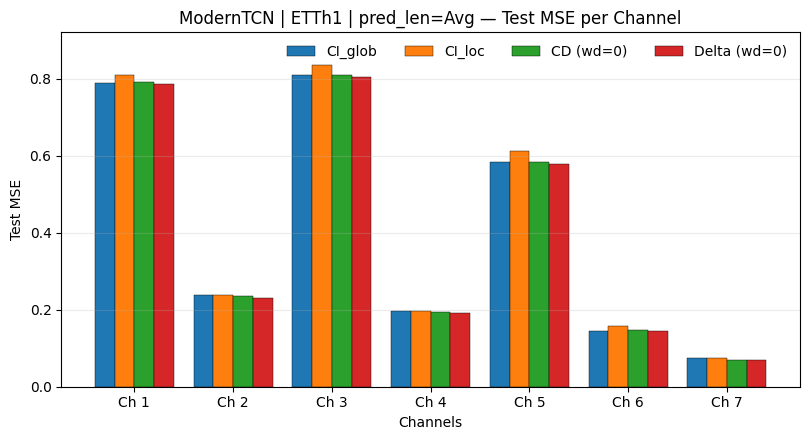

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def channel_wise_test_grouped(
    df_subset,
    pred_len=24,
    data_path="ILI",
    model="Linear",
    m_type=(("CI_glob", 0), ("CI_loc", 0), ("CD", 0), ("Delta", 0)),
):
    """
    Plot ONE figure with grouped bars of TEST MSE per channel.
    Each group = a channel; bars within a group = the different channel handling types in m_type.

    Parameters
    ----------
    df_subset : pd.DataFrame
        Must contain columns: ['model','channel_handling','data_path','pred_len',
                               'mse_per_channel_list_means'] and optionally 'cd_weight_decay'.
    pred_len : int or str
        Prediction length (or "Avg" if you use that in your df).
    data_path : str
        Dataset name in df.
    model : str
        Model name in df.
    m_type : iterable of (str, number)
        Sequence of (channel_handling, cd_weight_decay) pairs to plot.
    """

    # Collect per-method test-per-channel arrays
    series_per_method = []
    labels = []

    # Colors for up to 6 methods; extend if needed
    palette = [
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
    ]

    for i, (ch_handle, wd) in enumerate(m_type):
        # Build filter
        filt = (
            (df_subset["model"] == model)
            & (df_subset["channel_handling"] == ch_handle)
            & (df_subset["data_path"] == data_path)
            & (df_subset["pred_len"] == pred_len)
        )

        # If `cd_weight_decay` exists in df, include it in the filter
        if "cd_weight_decay" in df_subset.columns:
            filt = filt & (df_subset["cd_weight_decay"] == wd)

        df_sel = df_subset.loc[filt].copy()

        if df_sel.empty:
            # Skip missing combinations quietly (or raise if you prefer)
            continue

        # Expect a single row per combination; take first
        test_list = df_sel["mse_per_channel_list_means"].iloc[0]
        # Ensure it's a list/array of numerics
        test_arr = np.asarray(list(test_list), dtype=float)

        series_per_method.append(test_arr)

        # Legend label
        if ch_handle in ("CI_glob", "CI_loc"):
            labels.append(ch_handle)
        else:
            labels.append(f"{ch_handle} (wd={wd})")

    if not series_per_method:
        raise ValueError("No matching rows found for the given filters. Check pred_len/data_path/model/m_type.")

    # Sanity: all methods must have same number of channels
    n_channels_set = {len(arr) for arr in series_per_method}
    if len(n_channels_set) != 1:
        raise ValueError(f"Methods returned different channel counts: {n_channels_set}")

    n_methods = len(series_per_method)
    n_channels = list(n_channels_set)[0]

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(max(8, 0.6 * n_channels + 4), 4.5))

    x = np.arange(n_channels)
    total_width = 0.8
    bar_width = total_width / n_methods

    for i, arr in enumerate(series_per_method):
        offsets = x - total_width / 2 + (i + 0.5) * bar_width
        ax.bar(offsets, arr, width=bar_width, label=labels[i], color=palette[i % len(palette)], edgecolor="black", linewidth=0.3)

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels([f"Ch {i+1}" for i in x])
    ax.set_xlabel("Channels")
    ax.set_ylabel("Test MSE")
    ax.set_title(f"{model} | {data_path} | pred_len={pred_len} — Test MSE per Channel")
    ax.grid(axis="y", alpha=0.25)
    ax.legend(ncols=min(n_methods, 4), frameon=False)

    # Nice margins
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.05)

    fig.tight_layout()
    return fig, ax

# Example call (mirroring your previous call):
#fig, ax = channel_wise_test_grouped(df_subset=df_avg, pred_len=24, data_path="ILI", model="ModernTCN")
fig, ax = channel_wise_test_grouped(df_subset=df_avg, pred_len="Avg", data_path="ETTh1", model="ModernTCN")
plt.show()


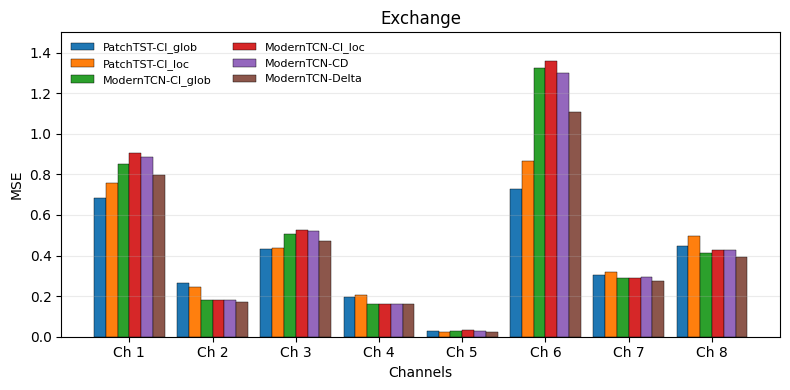

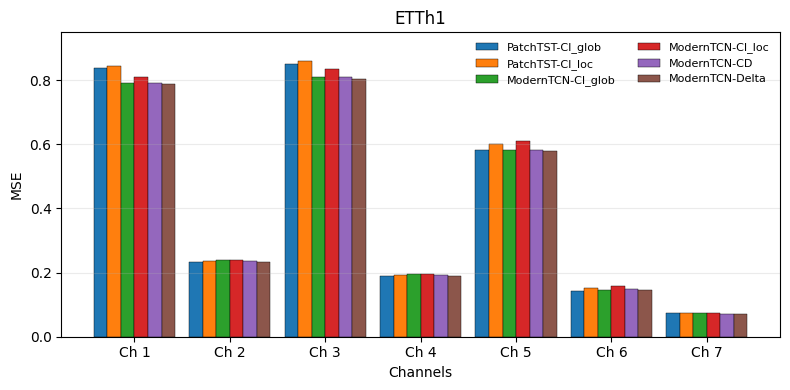

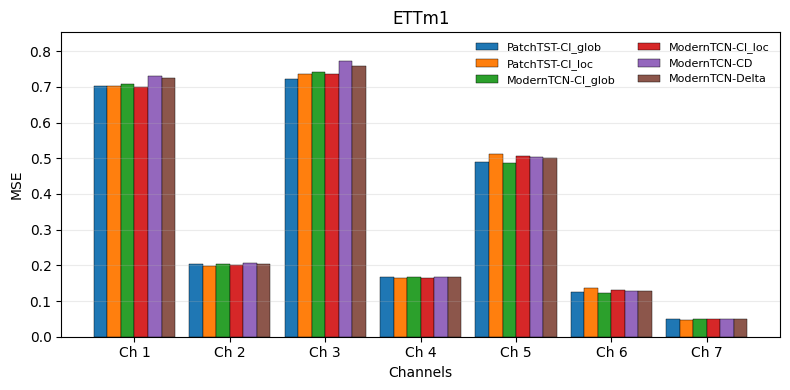

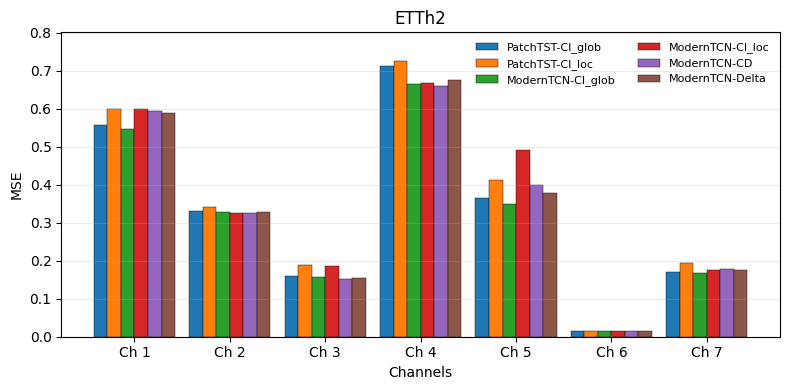

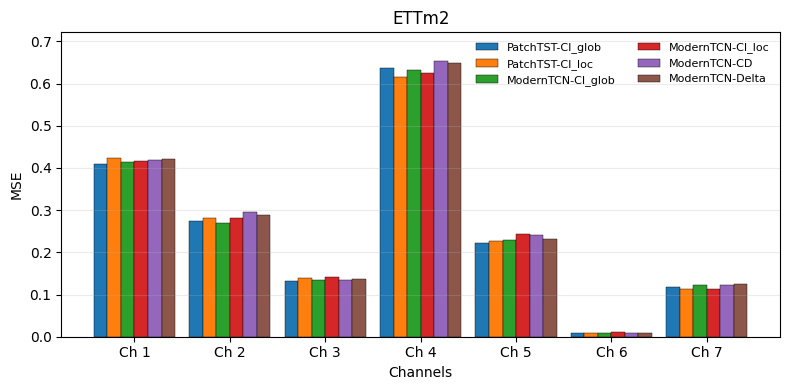

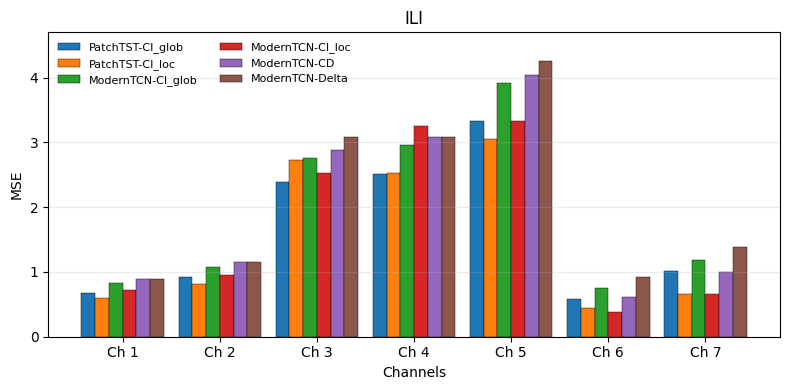

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def channel_wise_test_grouped_models(
    df_subset,
    pred_len=24,
    data_path="ILI",
    models=("ModernTCN", "PatchTST"),
    m_type=(("CI_glob", 0), ("CI_loc", 0), ("CD", 0), ("Delta", 0)),
):
    """
    Plot ONE figure with grouped bars of TEST MSE per channel.
    Each group = a channel; bars within a group = model+channel_handling combinations.
    """

    series_per_method = []
    labels = []

    palette = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"
    ]

    for model in models:
        for ch_handle, wd in m_type:
            filt = (
                (df_subset["model"] == model)
                & (df_subset["channel_handling"] == ch_handle)
                & (df_subset["data_path"] == data_path)
                & (df_subset["pred_len"] == pred_len)
            )
            if "cd_weight_decay" in df_subset.columns:
                filt = filt & (df_subset["cd_weight_decay"] == wd)

            df_sel = df_subset.loc[filt].copy()
            if df_sel.empty:
                continue

            test_list = df_sel["mse_per_channel_list_means"].iloc[0]
            test_arr = np.asarray(list(test_list), dtype=float)
            series_per_method.append(test_arr)

            labels.append(f"{model}-{ch_handle}")

    if not series_per_method:
        raise ValueError("No matching rows found for given filters.")

    n_channels_set = {len(arr) for arr in series_per_method}
    if len(n_channels_set) != 1:
        raise ValueError(f"Different channel counts: {n_channels_set}")

    n_methods = len(series_per_method)
    n_channels = list(n_channels_set)[0]

    # ---- Plot ----
    #fig, ax = plt.subplots(figsize=(max(10, 0.7 * n_channels + 4), 5))
    fig, ax = plt.subplots(figsize=(8, 4))

    x = np.arange(n_channels)
    total_width = 0.85
    bar_width = total_width / n_methods

    for i, arr in enumerate(series_per_method):
        offsets = x - total_width / 2 + (i + 0.5) * bar_width
        ax.bar(offsets, arr, width=bar_width,
               label=labels[i],
               color=palette[i % len(palette)],
               edgecolor="black", linewidth=0.3)

    ax.set_xticks(x)
    ax.set_xticklabels([f"Ch {i+1}" for i in x])
    ax.set_xlabel("Channels")
    ax.set_ylabel("MSE")
    #ax.set_title(f"{data_path} | pred_len={pred_len} — MSE per Channel")
    ax.set_title(f"{data_path}")
    ax.grid(axis="y", alpha=0.25)
    ax.legend(ncols=2, frameon=False, fontsize=8)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.05)

    fig.tight_layout()
    return fig, ax

# Example usage:
for data_path in ["Exchange", "ETTh1", "ETTm1", "ETTh2", "ETTm2", "ILI"]:
    fig, ax = channel_wise_test_grouped_models(
        df_subset=df_avg,
        pred_len="Avg",
        data_path=data_path,
        models=("PatchTST", "ModernTCN")
    )
    plt.show()


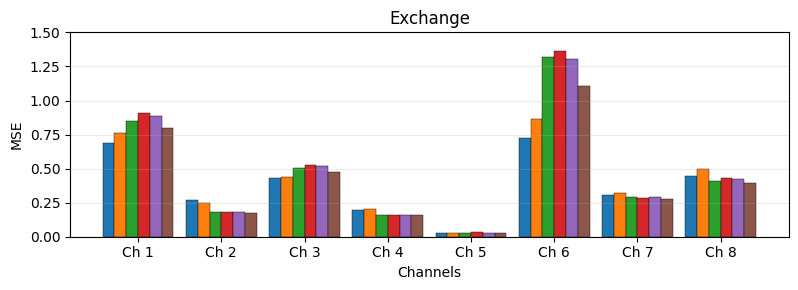

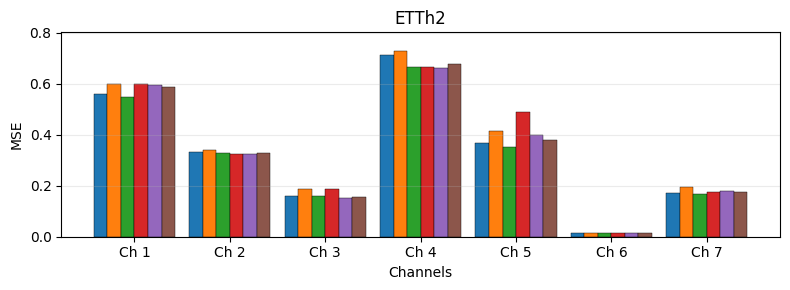

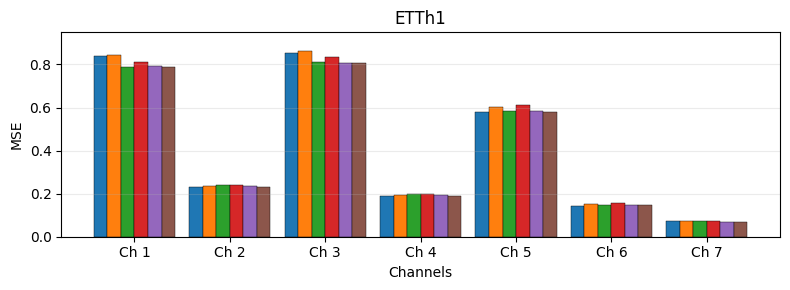

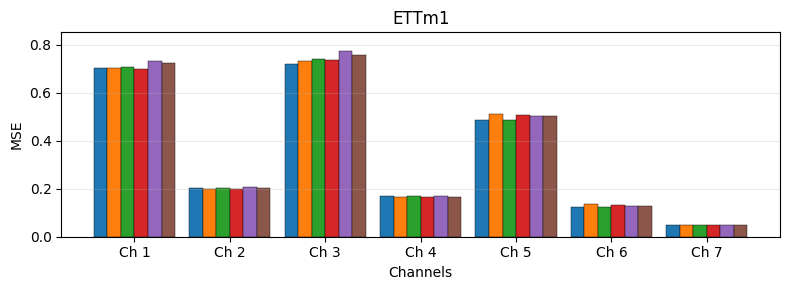

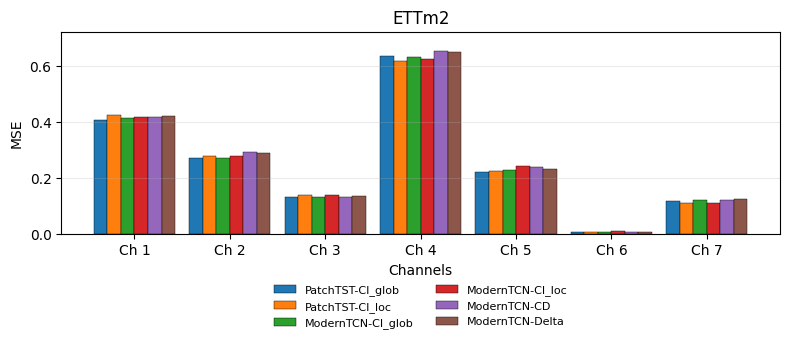

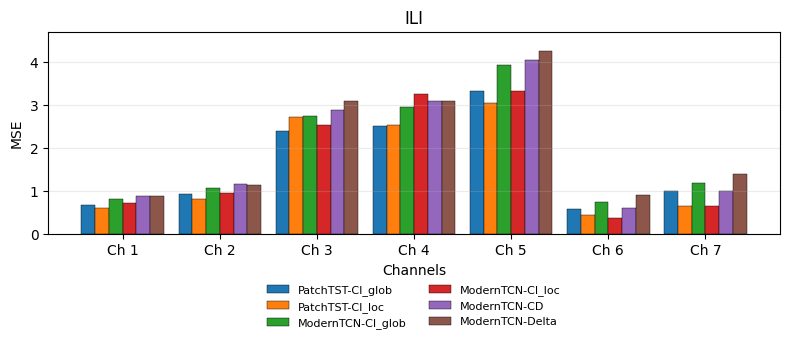

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def channel_wise_test_grouped_models(
    df_subset,
    pred_len=24,
    data_path="ILI",
    models=("ModernTCN", "PatchTST"),
    m_type=(("CI_glob", 0), ("CI_loc", 0), ("CD", 0), ("Delta", 0)),
    legend=True,
):
    """
    Plot ONE figure with grouped bars of TEST MSE per channel.
    Each group = a channel; bars within a group = model+channel_handling combinations.
    """

    series_per_method = []
    labels = []

    palette = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"
    ]

    for model in models:
        for ch_handle, wd in m_type:
            filt = (
                (df_subset["model"] == model)
                & (df_subset["channel_handling"] == ch_handle)
                & (df_subset["data_path"] == data_path)
                & (df_subset["pred_len"] == pred_len)
            )
            if "cd_weight_decay" in df_subset.columns:
                filt = filt & (df_subset["cd_weight_decay"] == wd)

            df_sel = df_subset.loc[filt].copy()
            if df_sel.empty:
                continue

            test_list = df_sel["mse_per_channel_list_means"].iloc[0]
            test_arr = np.asarray(list(test_list), dtype=float)
            series_per_method.append(test_arr)

            labels.append(f"{model}-{ch_handle}")

            """
            if ch_handle in ("CI_glob", "CI_loc"):
                labels.append(f"{model}-{ch_handle}")
            else:
                labels.append(f"{model}-{ch_handle}(wd={wd})")
            """

    if not series_per_method:
        raise ValueError("No matching rows found for given filters.")

    n_channels_set = {len(arr) for arr in series_per_method}
    if len(n_channels_set) != 1:
        raise ValueError(f"Different channel counts: {n_channels_set}")

    n_methods = len(series_per_method)
    n_channels = list(n_channels_set)[0]

    # ---- Plot ----
    if legend:
        fig, ax = plt.subplots(figsize=(8, 3.7))
    else:  
        fig, ax = plt.subplots(figsize=(8, 3))

    x = np.arange(n_channels)
    total_width = 0.85
    bar_width = total_width / n_methods

    for i, arr in enumerate(series_per_method):
        offsets = x - total_width / 2 + (i + 0.5) * bar_width
        ax.bar(offsets, arr, width=bar_width,
               label=labels[i],
               color=palette[i % len(palette)],
               edgecolor="black", linewidth=0.3)

    ax.set_xticks(x)
    ax.set_xticklabels([f"Ch {i+1}" for i in x])
    ax.set_xlabel("Channels")
    ax.set_ylabel("MSE")
    ax.set_title(f"{data_path}")
    ax.grid(axis="y", alpha=0.25)

    # Legend below the chart
    if legend:
        ax.legend(
            ncols=2,
            frameon=False,
            fontsize=8,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.2)
        )

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.05)

    fig.tight_layout()
    # Save the figure
    os.makedirs("plots/Thesis", exist_ok=True)
    out = f"plots/Thesis/Channel_Wise_MSE_Grouped_{data_path}.png"
    plt.savefig(out, bbox_inches="tight", dpi=300)
    return fig, ax

# Example usage:
for data_path in ["Exchange", "ETTh2", "ETTh1", "ETTm1", "ETTm2", "ILI"]:
    if data_path in ["ETTm2", "ILI"]:
        legend = True
    else:
        legend = False

    fig, ax = channel_wise_test_grouped_models(
        df_subset=df_avg,
        pred_len="Avg",
        data_path=data_path,
        models=("PatchTST", "ModernTCN"),
        legend=legend
    )
    plt.show()


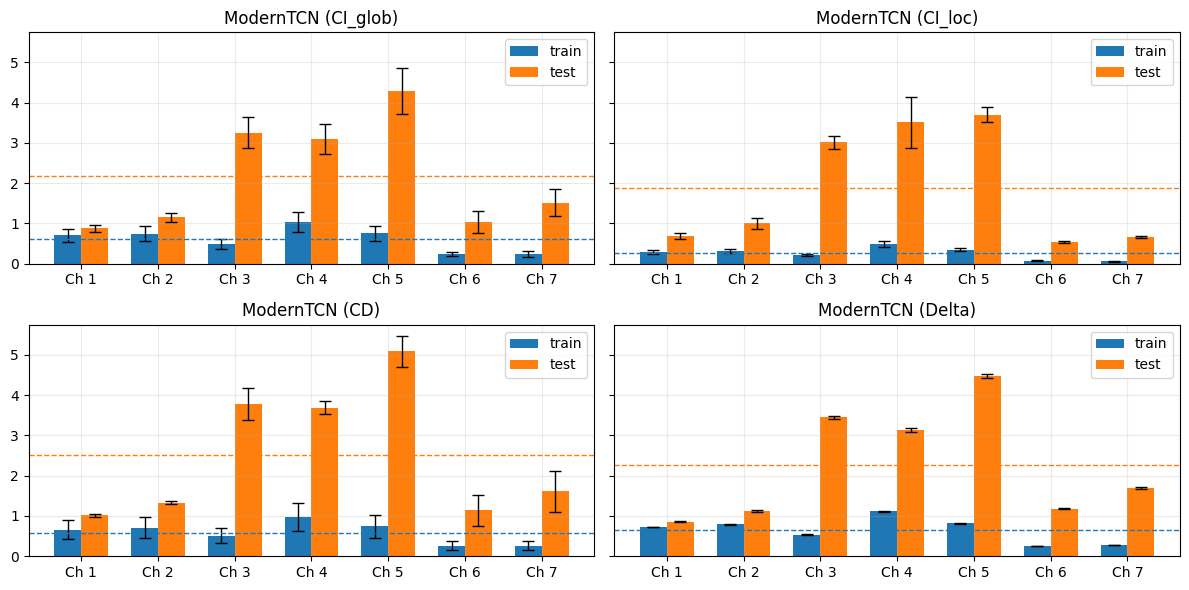

In [26]:
def channel_wise(df_subset, pred_len=60, data_path="ILI", model="Linear", m_type= [["CI_glob", 0], ["CI_loc", 0], ["CD", 0], ["Delta", 0]]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)

    if model == "PatchTST":
        rows = [0]
    else:
        rows = [0, 1]
    
    for row in rows:
        for col in [0, 1]:
            ax = axs[row, col]
            channel_handling = m_type[2*row + col][0]
            cd_weight_decay = m_type[2*row + col][1]

            df_CI = df_subset[
                (df_subset['model'] == model) &
                (df_subset['channel_handling'] == channel_handling) &
                (df_subset['data_path'] == data_path) &
                (df_subset['pred_len'] == pred_len)
            ].copy()

            if df_CI.empty:
                continue

            # Extract lists
            data_train = df_CI["mse_train_per_channel_list_means"].values[0]
            data_test = df_CI["mse_per_channel_list_means"].values[0]
            error_train = df_CI["mse_train_per_channel_list_stds"].values[0]
            error_test = df_CI["mse_per_channel_list_stds"].values[0]

            group_labels = ['train', 'test']
            colors = ['#1f77b4', '#ff7f0e']  # train, test
            bar_width = 0.35
            x = np.arange(len(data_train))  # number of channels

            # Plot bars with error bars
            for i, (data, error) in enumerate(zip([data_train, data_test], [error_train, error_test])):
                offset = (i - 1/2) * bar_width
                ax.bar(
                    x + offset,
                    data,
                    width=bar_width,
                    label=group_labels[i],
                    color=colors[i],
                    yerr=error,
                    capsize=4,
                    error_kw=dict(linewidth=1)
                )

            # Horizontal lines
            ax.axhline(y=df_CI["mse_train_mean"].values[0], color=colors[0], linestyle='--', linewidth=1)
            ax.axhline(y=df_CI["mse_mean"].values[0], color=colors[1], linestyle='--', linewidth=1)

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels([f'Ch {i+1}' for i in x])
            ax.set_title(f"{model} ({channel_handling})")
            ax.grid(alpha=0.25)
            ax.legend()

    #fig.suptitle(f"{model} | {data_path} | pred_len={pred_len}", fontsize=10)

    fig.tight_layout()

    os.makedirs("plots/Thesis", exist_ok=True)
    plt.savefig(f"plots/Thesis/CW_{model}_{data_path}_Pred_{pred_len}.png", bbox_inches='tight', dpi=300)

# Example usage
#channel_wise(df_subset=df_avg)
channel_wise(df_subset=df_avg, model="ModernTCN")
plt.show()


In [29]:
### Tabellen!

metric = "mse"
model = "Linear"

def table(channel_handling_list=["CI_glob", "CI_loc", "CD", "Delta"], df_avg=df_avg, metric=metric, model=model):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "Traffic", "Electricity"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["ILI"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    # Example: define some columns
    columns = [f"{ch} - {val}" for ch in channel_handling_list for val in ["Mean", "Std"]]

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Exchange", "Weather", "Traffic", "Electricity", "ILI"]:
        if data_path == "ILI":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            for ch in channel_handling_list:
                
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['pred_len'] == pred_len) &
                    (df_avg['channel_handling'] == ch)
                ]

                if not df_filtered.empty:
                    mse = df_filtered[metric+'_mean'].values[0]
                    mae = df_filtered[metric+'_mean'].values[0]
                    df_table.loc[f"{data_path} - {pred_len}", f"{ch} - Mean"] = round(mse, 3)
                    df_table.loc[f"{data_path} - {pred_len}", f"{ch} - Mean"] = round(mae, 3)

                    if pred_len != "Avg":
                        mse = df_filtered[metric+'_std'].values[0]
                        mae = df_filtered[metric+'_std'].values[0]
                        df_table.loc[f"{data_path} - {pred_len}", f"{ch} - Std"] = round(mse, 3)
                        df_table.loc[f"{data_path} - {pred_len}", f"{ch} - Std"] = round(mae, 3)

    df_table.to_csv(f"plots/Thesis/table_{model}_{metric}.csv", index=True)

    return df_table

#display(table())

for metric in ["mse", "mae"]:
    table(channel_handling_list=["CI_glob", "CI_loc", "CD", "Delta"], metric=metric, model="Linear")
    table(channel_handling_list=["CI_glob", "CI_loc", "CD", "Delta"], metric=metric, model="ModernTCN")
    table(channel_handling_list=["CI_glob", "CI_loc"], metric=metric, model="PatchTST")

### Alt:

In [ ]:
df_avg = pd.DataFrame()

def calc_avg(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    random_seeds = df_subset['random_seed'].unique().tolist()
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    for random_seed in random_seeds:
        df_seed = df_subset[
            (df_subset['model'] == model) &
            (df_subset['data_path'].str.contains(data_path)) &
            (df_subset['random_seed'] == random_seed)
        ].copy()

        if df_seed.empty:
            continue
        
        for channel_handling in list_channel_handling:
            df_seed_channel = df_seed[df_seed['channel_handling'] == channel_handling]
            if df_seed_channel.empty:
                continue

            list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
            
            for cd_weight_decay in list_cd_weight_decay:
                df_seed_channel_cd = df_seed_channel[df_seed_channel['cd_weight_decay'] == cd_weight_decay]
                if df_seed_channel_cd.empty:
                    continue

                # Calculate average values for each channel handling and cd_weight_decay
                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': "Avg",
                    'random_seed': random_seed,
                    'mse': df_seed_channel_cd['mse'].mean(),
                    'mae': df_seed_channel_cd['mae'].mean(),
                    'mse_train': df_seed_channel_cd['mse_train'].mean(),
                    'mae_train': df_seed_channel_cd['mae_train'].mean(),
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'Avg_values_Len': df_seed_channel_cd['pred_len'].tolist(), 
                    'Avg_Count_Len': len(df_seed_channel_cd),
                }

                # Add per channel averages
                avg_row['mse_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

In [ ]:
#df_avg = avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

df_temp=avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

display(df_temp)

df_avg=calc_avg(df_subset=df_temp, data_path="ETTh1")

display(df_avg)

model data_path  pred_len random_seed       mse       mae  \
0   Linear_final     ETTh1       192         Avg  0.428359  0.440656   
1   Linear_final     ETTh1       336         Avg  0.463995  0.465188   
2   Linear_final     ETTh1       720         Avg  0.515326  0.520389   
3   Linear_final     ETTh1        96         Avg  0.385369  0.409559   
4   Linear_final     ETTh1       192         Avg  0.417011  0.423135   
..           ...       ...       ...         ...       ...       ...   
67  Linear_final     ETTh1       720         Avg  1.583475  0.992256   
68  Linear_final     ETTh1        96         Avg  0.752832  0.643104   
69  Linear_final     ETTh1       192         Avg  1.019695  0.769982   
70  Linear_final     ETTh1       336         Avg  1.329889  0.894243   
71  Linear_final     ETTh1       720         Avg  1.542502  0.979059   

    mse_train  mae_train  cd_weight_decay channel_handling  \
0    0.399685   0.448193              0.0          CI_glob   
1    0.450571   0.477851              0.0          CI_glob   
2    0.526693   0.527229              0.0          CI_glob   
3    0.341039   0.409464              0.0          CI_glob   
4    0.360720   0.421799              0.0           CI_loc   
..        ...        ...              ...              ...   
67   0.311273   0.413806              0.1            Delta   
68   0.245471   0.353476              1.0            Delta   
69   0.277994   0.381682              1.0            Delta   
70   0.304513   0.403891              1.0            Delta   
71   0.326317   0.421775              1.0            Delta   

                   Avg_values_RanS  Avg_Count_RanS  \
0   [2021, 2022, 2023, 2024, 2025]               5   
1   [2021, 2022, 2023, 2024, 2025]               5   
2   [2021, 2022, 2023, 2024, 2025]               5   
3   [2022, 2023, 2024, 2025, 2021]               5   
4   [2021, 2022, 2023, 2024, 2025]               5   
..                             ...             ...   
67  [2021, 2022, 2023, 2024, 2025]               5   
68  [2021, 2022, 2023, 2024, 2025]               5   
69  [2021, 2022, 2023, 2024, 2025]               5   
70  [2021, 2022, 2023, 2024, 2025]               5   
71  [2021, 2022, 2023, 2024, 2025]               5   

                                 mse_per_channel_list  \
0   [0.8228135108947754, 0.24596365988254548, 0.84...   
1   [0.8598625302314759, 0.26672130823135376, 0.87...   
2   [0.7985777378082275, 0.32062711119651793, 0.78...   
3   [0.7591026425361633, 0.215773868560791, 0.7838...   
4   [0.8213740110397338, 0.23563361465930938, 0.85...   
..                                                ...   
67  [1.5183112382888795, 2.490428829193115, 1.2193...   
68  [1.030314064025879, 0.7746048688888549, 0.9122...   
69  [1.2231001615524293, 1.173753309249878, 1.0237...   
70  [1.2270315408706665, 2.0560516357421874, 1.020...   
71  [1.4597730398178101, 2.455350875854492, 1.1620...   

                                 mae_per_channel_list  \
0   [0.6180592536926269, 0.37087311744689944, 0.61...   
1   [0.6311773777008056, 0.3863368630409241, 0.619...   
2   [0.6383005142211914, 0.4306677281856537, 0.613...   
3   [0.5926631808280944, 0.3466036140918732, 0.589...   
4   [0.6121840834617615, 0.362093585729599, 0.6035...   
..                                                ...   
67  [0.9597937583923339, 1.4206832885742187, 0.817...   
68  [0.7661731362342834, 0.737368381023407, 0.6853...   
69  [0.8531947016716004, 0.9328744411468506, 0.735...   
70  [0.8429360628128052, 1.2656689167022706, 0.715...   
71  [0.9386976480484008, 1.4147354125976563, 0.793...   

                           mse_train_per_channel_list  \
0   [0.3743897438049316, 0.33937657475471494, 0.35...   
1   [0.4001357972621918, 0.4042706310749054, 0.375...   
2   [0.44845019578933715, 0.5310478210449219, 0.42...   
3   [0.3399273455142975, 0.2814298808574677, 0.327...   
4   [0.34504504799842833, 0.3095886170864105, 0.32...   
..                                      

model data_path pred_len random_seed       mse       mae  \
0   Linear_final     ETTh1      Avg         Avg  0.448262  0.458948   
1   Linear_final     ETTh1      Avg         Avg  0.434888  0.439295   
2   Linear_final     ETTh1      Avg         Avg  1.219112  0.842110   
3   Linear_final     ETTh1      Avg         Avg  1.219382  0.842208   
4   Linear_final     ETTh1      Avg         Avg  1.219382  0.842208   
5   Linear_final     ETTh1      Avg         Avg  1.219380  0.842207   
6   Linear_final     ETTh1      Avg         Avg  1.219352  0.842197   
7   Linear_final     ETTh1      Avg         Avg  1.211459  0.840047   
8   Linear_final     ETTh1      Avg         Avg  1.199591  0.836564   
9   Linear_final     ETTh1      Avg         Avg  1.169888  0.826988   
10  Linear_final     ETTh1      Avg         Avg  1.217319  0.842413   
11  Linear_final     ETTh1      Avg         Avg  1.217319  0.842413   
12  Linear_final     ETTh1      Avg         Avg  1.217318  0.842413   
13  Linear_final     ETTh1      Avg         Avg  1.217290  0.842403   
14  Linear_final     ETTh1      Avg         Avg  1.215643  0.842111   
15  Linear_final     ETTh1      Avg         Avg  1.214138  0.841558   
16  Linear_final     ETTh1      Avg         Avg  1.196720  0.835346   
17  Linear_final     ETTh1      Avg         Avg  1.161229  0.821597   

    mse_train  mae_train  cd_weight_decay channel_handling  \
0    0.429497   0.465684         0.000000          CI_glob   
1    0.389316   0.439849         0.000000           CI_loc   
2    0.286107   0.394715         0.001000               CD   
3    0.286074   0.394713         0.000000               CD   
4    0.286074   0.394713         0.000001               CD   
5    0.286074   0.394713         0.000010               CD   
6    0.286078   0.394713         0.000100               CD   
7    0.278261   0.388123         0.010000               CD   
8    0.274333   0.382803         0.100000               CD   
9    0.289041   0.390726         1.000000               CD   
10   0.278884   0.388359         0.000000            Delta   
11   0.278884   0.388359         0.000001            Delta   
12   0.278884   0.388359         0.000010            Delta   
13   0.278888   0.388359         0.000100            Delta   
14   0.277595   0.387322         0.001000            Delta   
15   0.276706   0.386379         0.010000            Delta   
16   0.275212   0.383526         0.100000            Delta   
17   0.288574   0.390206         1.000000            Delta   

         Avg_values_Len  Avg_Count_Len  \
0   [192, 336, 720, 96]              4   
1   [192, 336, 720, 96]              4   
2   [96, 192, 336, 720]              4   
3   [96, 192, 336, 720]              4   
4   [96, 192, 336, 720]              4   
5   [96, 192, 336, 720]              4   
6   [96, 192, 336, 720]              4   
7   [96, 192, 336, 720]              4   
8   [96, 192, 336, 720]              4   
9   [96, 192, 336, 720]              4   
10  [96, 192, 336, 720]              4   
11  [96, 192, 336, 720]              4   
12  [96, 192, 336, 720]              4   
13  [96, 192, 336, 720]              4   
14  [96, 192, 336, 720]              4   
15  [96, 192, 336, 720]              4   
16  [96, 192, 336, 720]              4   
17  [96, 192, 336, 720]              4   

                                 mse_per_channel_list  \
0   [0.8100891053676604, 0.26227148696780206, 0.82...   
1   [0.8146604299545288, 0.2432438708841801, 0.834...   
2   [1.2901591390371323, 1.6741781443357466, 1.086...   
3   [1.2904113799333572, 1.674470579624176, 1.0866...   
4   [1.2904113799333572, 1.674470579624176, 1.0866...   
5   [1.2904104202985764, 1.6744694143533705, 1.086...   
6   [1.290383416414261, 1.6744389981031418, 1.0866...   
7   [1.278135856986046, 1.6712544441223145, 1.0754...   
8   [1.268747013807297, 1.6567543119192125, 1.0600...   
9   [1.2300093472003937, 1.6358801901340485, 1.025...   
10  [1.2929358959197996, 1.6591746747493743, 1.083...   

In [ ]:
plt.close('all')

list_model = ["Linear_final", "ModernTCN", "PatchTST"]

df_subset = df_subset.dropna(subset=["mse_per_channel_list"])
df_avg = pd.DataFrame()

#for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]:
#for data_path in ["ETTh1"]:
    if data_path == "national_illness":
        list_pred_len = [24, 36, 48, 60, "Avg"]
    else:
        list_pred_len = [96, 192, 336, 720, "Avg"]

    for model in list_model:
        if data_path != "traffic" and data_path != "electricity":
            #df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)
            df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_avg_seeds)

            #df_avg = calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)

        try:
            vf.channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CW - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        try:    
            vf.channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CH - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        for pred_len in list_pred_len:
            try:
                #vf.channel_wise(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_wise(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_wise(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

            try:    
                #vf.channel_handling(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_handling(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_handling(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

    df_avg["model_CH"] = df_avg["model"] + "_" + df_avg["channel_handling"]

df_avg.to_pickle("df_avg.pkl")

"""
list_pred_len = [96, 192, 336, 720]
list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

for pred_len in list_pred_len:
    for data_path in list_data_path:
        for model in list_model:
            try:
                channel_wise(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")

            try:    
                channel_handling(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")


"Avg"
list_data_path = ["national_illness", "ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

display(df_avg)

"""

plt.close('all')

CW - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with da

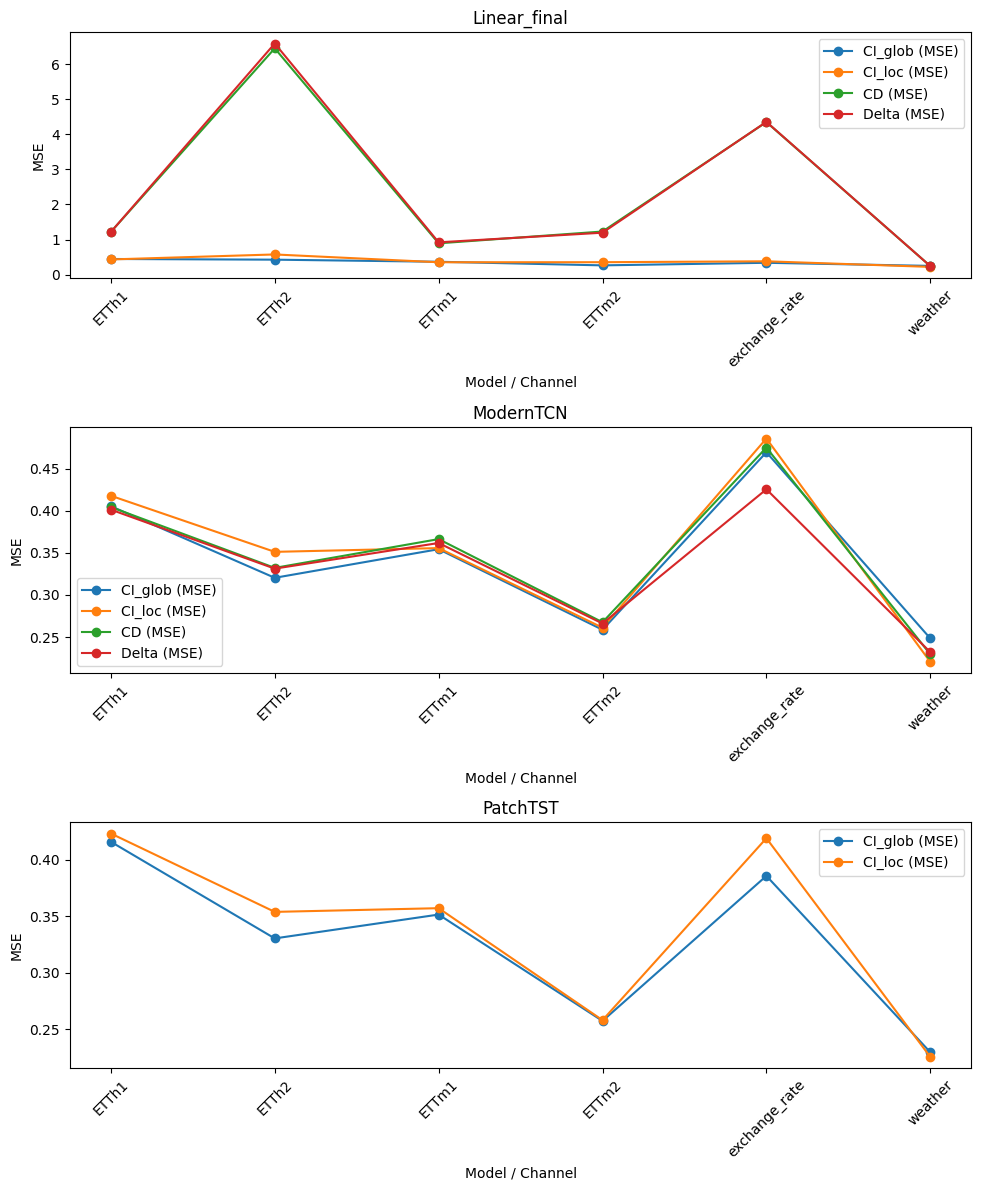

In [ ]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        #ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_test.png")
plt.show()


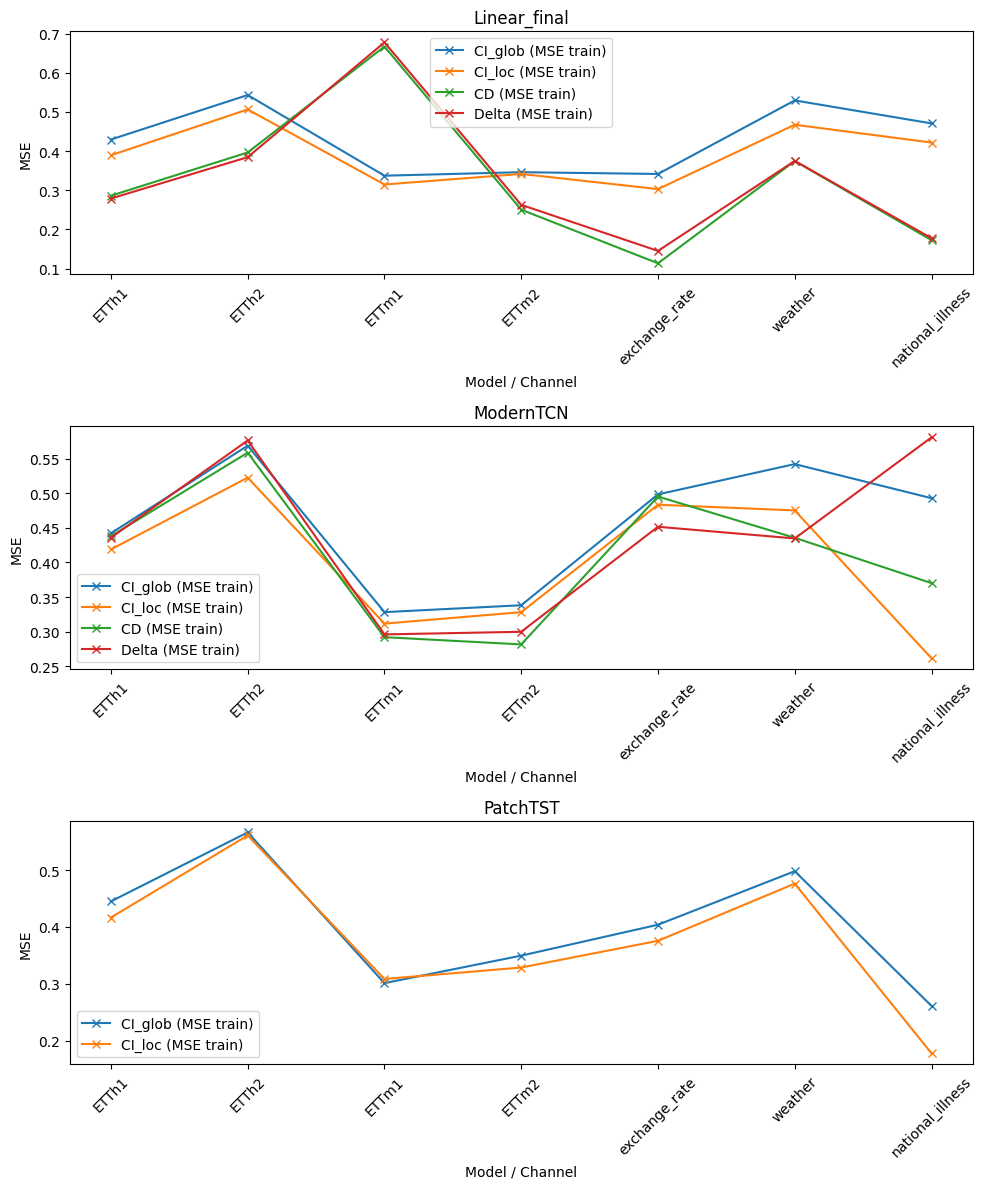

In [ ]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        #ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_train.png")
plt.show()


/scratch/ipykernel_823259/3122857556.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')


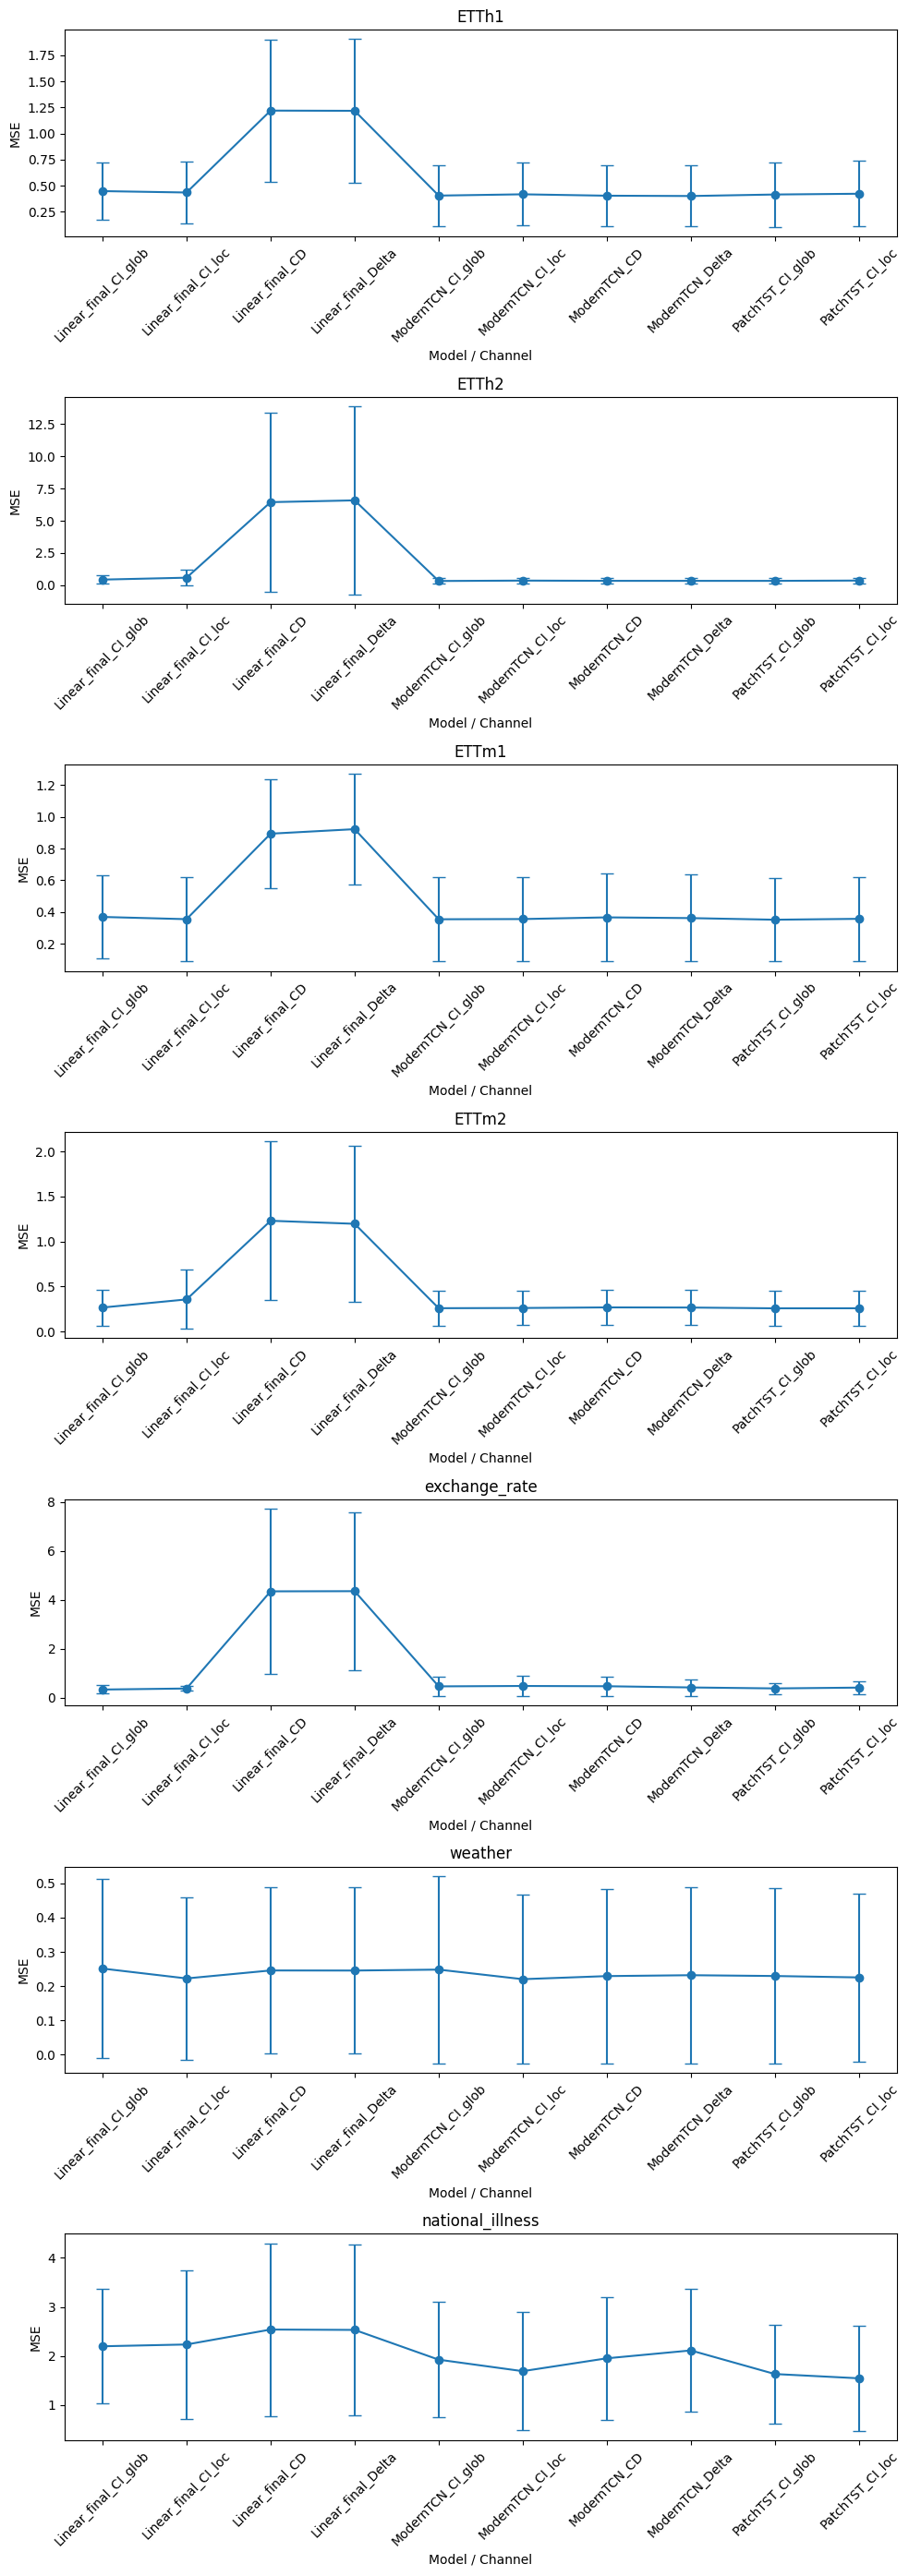

In [ ]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_errorbar.png")
plt.show()


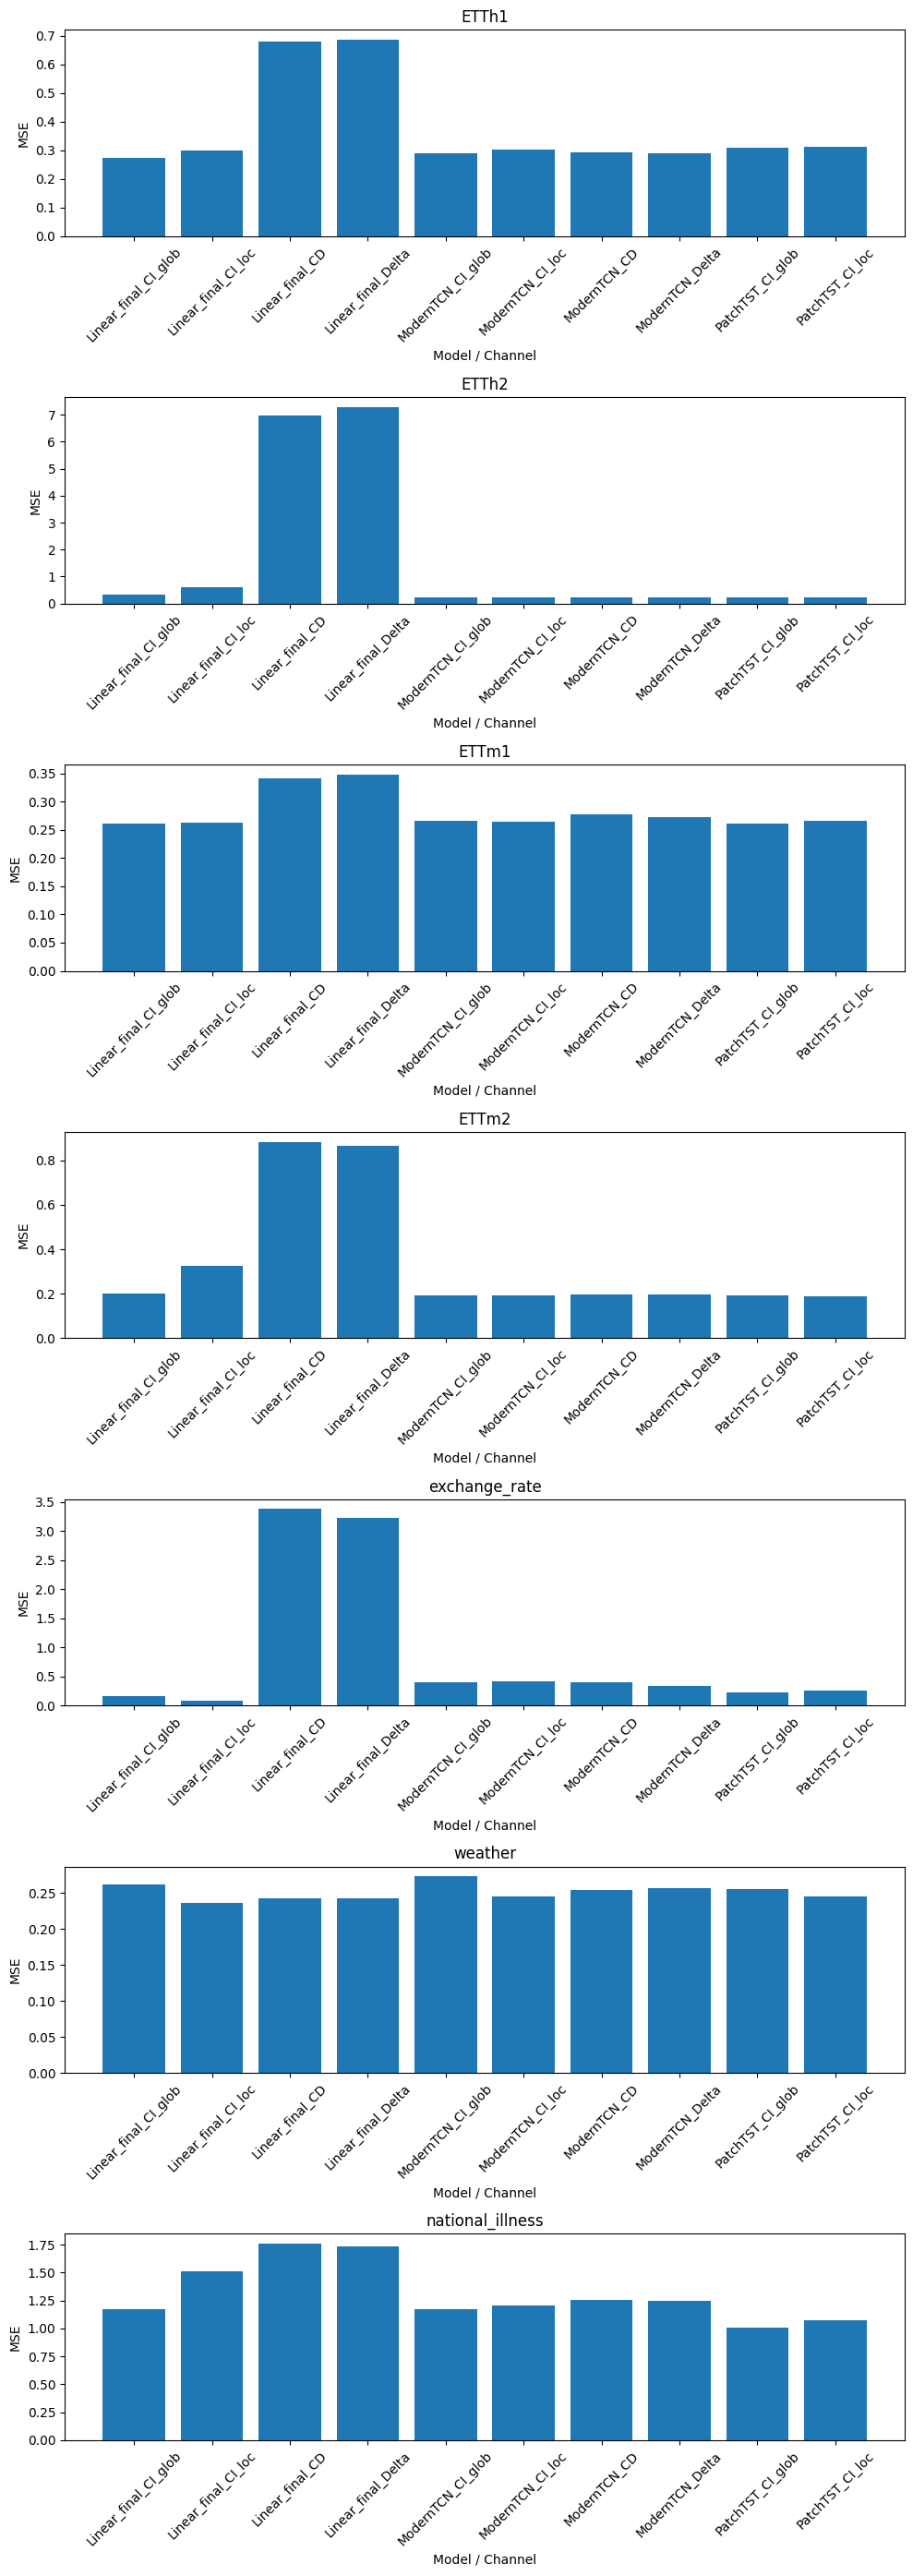

In [ ]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.bar(x, yerr)
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_std.png")
plt.show()


## Table

In [ ]:


def table(channel_handling = "CI_glob", df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    # Example: define some columns
    columns = [f"{model} - {metric}" for model in ["Linear_final", "ModernTCN", "PatchTST"] for metric in ["MSE", "MAE"]]

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            for model in ["Linear_final", "ModernTCN", "PatchTST"]:
                if pred_len == "Avg":
                    df_filtered = df_avg[
                        (df_avg['data_path'].str.contains(data_path)) &
                        (df_avg['model'] == model) &
                        (df_avg['channel_handling'] == channel_handling)
                    ]
                else:
                    df_filtered = df_subset[
                        (df_subset['data_path'].str.contains(data_path)) &
                        (df_subset['pred_len'] == pred_len) &
                        (df_subset['model'] == model) &
                        (df_subset['channel_handling'] == channel_handling)
                    ]
                    #display(df_filtered)

                if not df_filtered.empty:
                    mse = df_filtered['mse'].values[0]
                    mae = df_filtered['mae'].values[0]
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MSE"] = round(mse, 3)
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MAE"] = round(mae, 3)

    return df_table

def render_table(df, title="", fontsize=10, show:bool=False):
    fig, ax = plt.subplots(figsize=(len(df.columns)*1.8, len(df)*0.3))  # Adjust figure size
    ax.axis('off')  # Hide axes

    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.2, 1.2)  # Adjust scaling for better readability

    if title:
        plt.title(title, fontsize=fontsize+2)

    save_dir = f"plots/tables"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{channel_handling}.png"
    plt.savefig(save_path)

    plt.tight_layout()
    
    if show:
        plt.show()
    else:
        plt.close(fig)

#render_table(table(), title="Results for CI_glob Channel Handling", fontsize=10);

In [ ]:
vf.render_table(vf.table(channel_handling="CI_glob", df_avg=df_avg, df_subset=df_subset), title="Results for CI_glob", fontsize=10)

## Comp (PatchTST, ModernTCN)

In [ ]:


def comp_PatchTST(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity"]      # , "exchange_rate"
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "PatchTST"
    channel_handling = "CI_glob"
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness"]:     # "exchange_rate" isn't evaluated in the paper
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)

            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mae'].values[0]

            #print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table




def comp_ModernTCN(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "exchange_rate"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "ModernTCN"
    channel_handling = "CD"
    cd_weight_decay = 0.0
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness", "exchange_rate"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling) &
                    (df_avg['cd_weight_decay'] == cd_weight_decay)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling) &
                    (df_subset['cd_weight_decay'] == cd_weight_decay)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)
            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mae'].values[0]

            print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table

In [ ]:
vf.render_table(comp_PatchTST(df_avg=df_avg, df_subset=df_subset), title="PatchTST_Comp", fontsize=10)
vf.render_table(comp_ModernTCN(df_avg=df_avg, df_subset=df_subset), title="ModernTCN_Comp", fontsize=10)

Processing ETTh1 - 96, MSE: 0.368, MAE: 0.394
Processing ETTh1 - 192, MSE: 0.405, MAE: 0.413
Processing ETTh1 - 336, MSE: 0.391, MAE: 0.412
Processing ETTh1 - 720, MSE: 0.45, MAE: 0.461
Processing ETTh1 - Avg, MSE: 0.404, MAE: 0.42
Processing ETTh2 - 96, MSE: 0.263, MAE: 0.332
Processing ETTh2 - 192, MSE: 0.32, MAE: 0.374
Processing ETTh2 - 336, MSE: 0.313, MAE: 0.376
Processing ETTh2 - 720, MSE: 0.392, MAE: 0.433
Processing ETTh2 - Avg, MSE: 0.322, MAE: 0.379
Processing ETTm1 - 96, MSE: 0.292, MAE: 0.346
Processing ETTm1 - 192, MSE: 0.332, MAE: 0.368
Processing ETTm1 - 336, MSE: 0.365, MAE: 0.391
Processing ETTm1 - 720, MSE: 0.416, MAE: 0.417
Processing ETTm1 - Avg, MSE: 0.351, MAE: 0.381
Processing ETTm2 - 96, MSE: 0.166, MAE: 0.256
Processing ETTm2 - 192, MSE: 0.222, MAE: 0.293
Processing ETTm2 - 336, MSE: 0.272, MAE: 0.324
Processing ETTm2 - 720, MSE: 0.351, MAE: 0.381
Processing ETTm2 - Avg, MSE: 0.253, MAE: 0.314
Processing weather - 96, MSE: 0.149, MAE: 0.2
Processing weather - 

In [ ]:
# CI_glob, CI_loc, CD, Delta (letzte beide inkl. cd_weight_decay)
# versch. random seeds

# versch. lags & pred_len

data_path_list = "_weather_shower_lag"

cd_weight_decay = 0.0
random_seed = 2021

df_subset[df_subset['data_path'].str.contains(data_path)]

model  pred_len  random_seed         data_path       mae  \
543       PatchTST        24         2021  national_illness  0.803709   
546       PatchTST        24         2021  national_illness  0.734400   
549       PatchTST        36         2021  national_illness  0.738304   
553       PatchTST        36         2021  national_illness  0.897628   
556       PatchTST        48         2021  national_illness  0.781294   
...            ...       ...          ...               ...       ...   
6853  Linear_final        60         2025  national_illness  1.125286   
6854  Linear_final        24         2025  national_illness  0.966875   
6856  Linear_final        36         2025  national_illness  0.969060   
6857  Linear_final        48         2025  national_illness  1.002569   
6859  Linear_final        60         2025  national_illness  1.082660   

           mse  seq_len  cd_weight_decay  mse_train  mae_train  ...  \
543   1.526970      104              0.0   0.178466   0.266468  ...   
546   1.300964      104              0.0   0.147548   0.268095  ...   
549   1.402446      104              0.0   0.139886   0.241957  ...   
553   1.658348      104              0.0   0.301664   0.343836  ...   
556   1.551446      104              0.0   0.108178   0.218677  ...   
...        ...      ...              ...        ...        ...  ...   
6853  2.761027      104              0.1   0.193905   0.261825  ...   
6854  2.104870      104              1.0   0.175310   0.250610  ...   
6856  2.214893      104              1.0   0.183034   0.245036  ...   
6857  2.354463      104              1.0   0.240188   0.294305  ...   
6859  2.654606      104              1.0   0.213474   0.265893  ...   

                             mae_train_per_channel_list  \
543   [0.323392391204834, 0.3177845776081085, 0.2902...   
546   [0.32734137773513794, 0.3444662392139435, 0.26...   
549   [0.2924741208553314, 0.275689035654068, 0.2251...   
553   [0.3963671922683716, 0.40513041615486145, 0.34...   
556   [0.27350935339927673, 0.2145286351442337, 0.19...   
...                                                 ...   
6853  [0.3064042329788208, 0.3258795142173767, 0.242...   
6854  [0.29654061794281006, 0.31647565960884094, 0.2...   
6856  [0.2896304428577423, 0.3084365129470825, 0.231...   
6857  [0.34254977107048035, 0.36091795563697815, 0.2...   
6859  [0.3119667172431946, 0.33168137073516846, 0.24...   

                                   mae_per_channel_list channel_handling  \
543   [0.5129213929176331, 0.6478416323661804, 1.175...           CI_loc   
546   [0.48295941948890686, 0.5699107646942139, 0.94...          CI_glob   
549   [0.4654504358768463, 0.5817347168922424, 1.171...           CI_loc   
553   [0.6038227677345276, 0.698068380355835, 1.0487...          CI_glob   
556   [0.499705582857132, 0.5648725032806396, 1.1448...           CI_loc   
...                                                 ...              ...   
6853  [0.9506398439407348, 1.0250247716903689, 1.384...            Delta   
6854  [0.8080660700798035, 0.8735821843147278, 1.255...            Delta   
6856  [0.8055736422538757, 0.8829195499420166, 1.210...            Delta   
6857  [0.7949936389923096, 0.8712086081504822, 1.262...            Delta   
6859  [0.868520975112915, 0.9446245431900024, 1.3448...            Delta   

     learning_rate batch_size  patience  head_dropout  dropout  delta_factor  \
543         0.0025         16        20           0.0     0.30           1.0   
546         0.0025         16        20           0.0     0.30           1.0   
549         0.0025         16        20           0.0     0.30           1.0   
553         0.0025         16        20           0.0     0.30           1.0   
556         0.0025         16        20           0.0     0.30           1.0   
...            ...        ...       ...           ...      ...           ...   
6853        0.0050         32        20           0.0     0.05           1.0   
6854        0.0050   

In [ ]:
pred_len_list = 96
data_path_list = ["_weather_shower_lag"]
metric = "MSE"

def lag(pred_len=pred_len, data_path_list=data_path_list, df_subset=df_subset, model="Linear_final"):
    fig, axs = plt.subplots(4, figsize=(10, 10), sharey=True)
    #fig, axs = plt.subplots(4, figsize=(10, 10))#, sharey=True)

    
    for j, data_path in enumerate(data_path_list):
        for ind, channel_handling in enumerate(["CI_glob", "CI_loc", "CD", "Delta"]):
            df_CI = df_subset[(df_subset['model'] == model) & (df_subset['channel_handling'] == channel_handling) & (df_subset['cd_weight_decay'] == 0.0) & (df_subset['random_seed'] == 2021) 
                              & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset['patience'] == 20)].copy()
            #df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_([0-9]+)$').astype(int)
            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            #display(df_CI)

            data_train = df_CI["mse_train_per_channel_list"].tolist()
            data_test = df_CI["mse_per_channel_list"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            #display(data)

            x_labels = df_CI['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[ind].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[ind].set_xticks(x)
            axs[ind].set_xticklabels(x_labels)
            axs[ind].set_title(f'{model} - {channel_handling} - Pred Len: {pred_len}, Data: {data_path}')
            axs[ind].set_ylabel(metric)
            axs[ind].set_xlabel("Data lag")
            axs[ind].legend()
            axs[ind].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("plots/Dataset_Selec/"+model+"_pred"+str(pred_len)+".png")
    #plt.show()

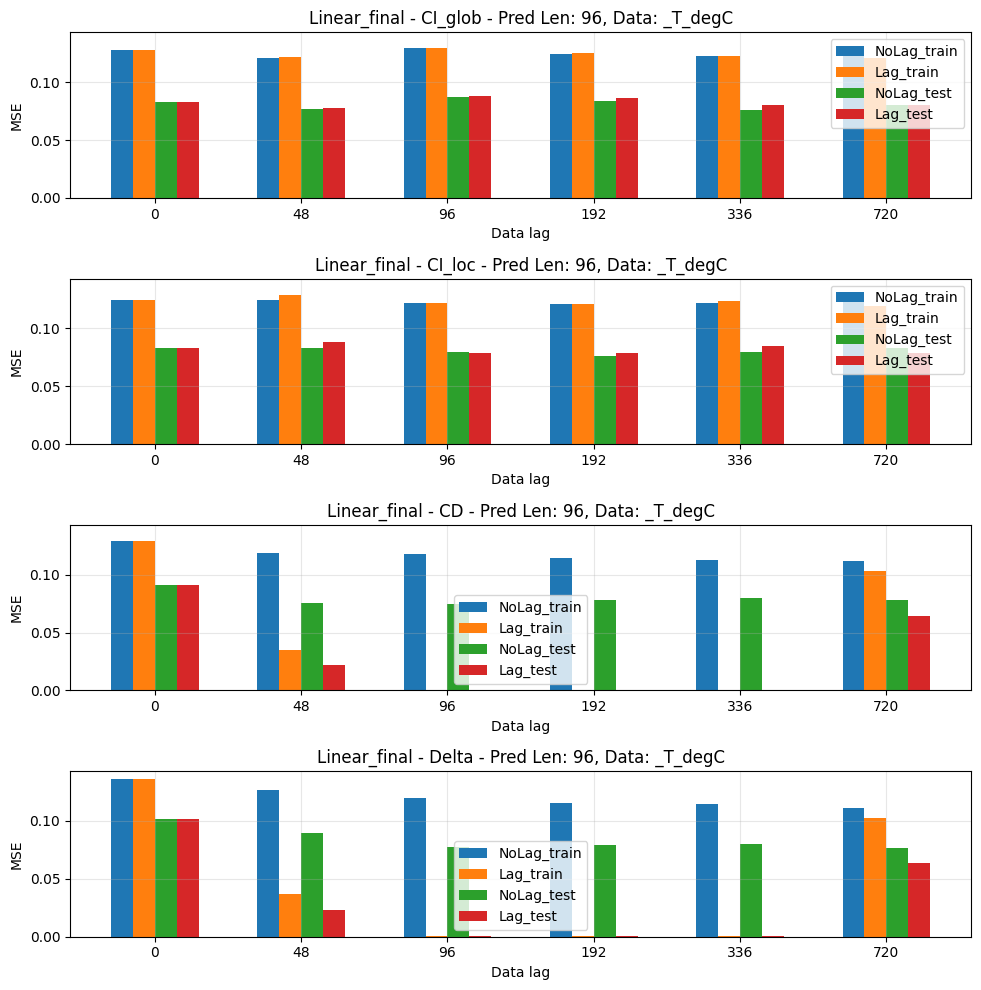

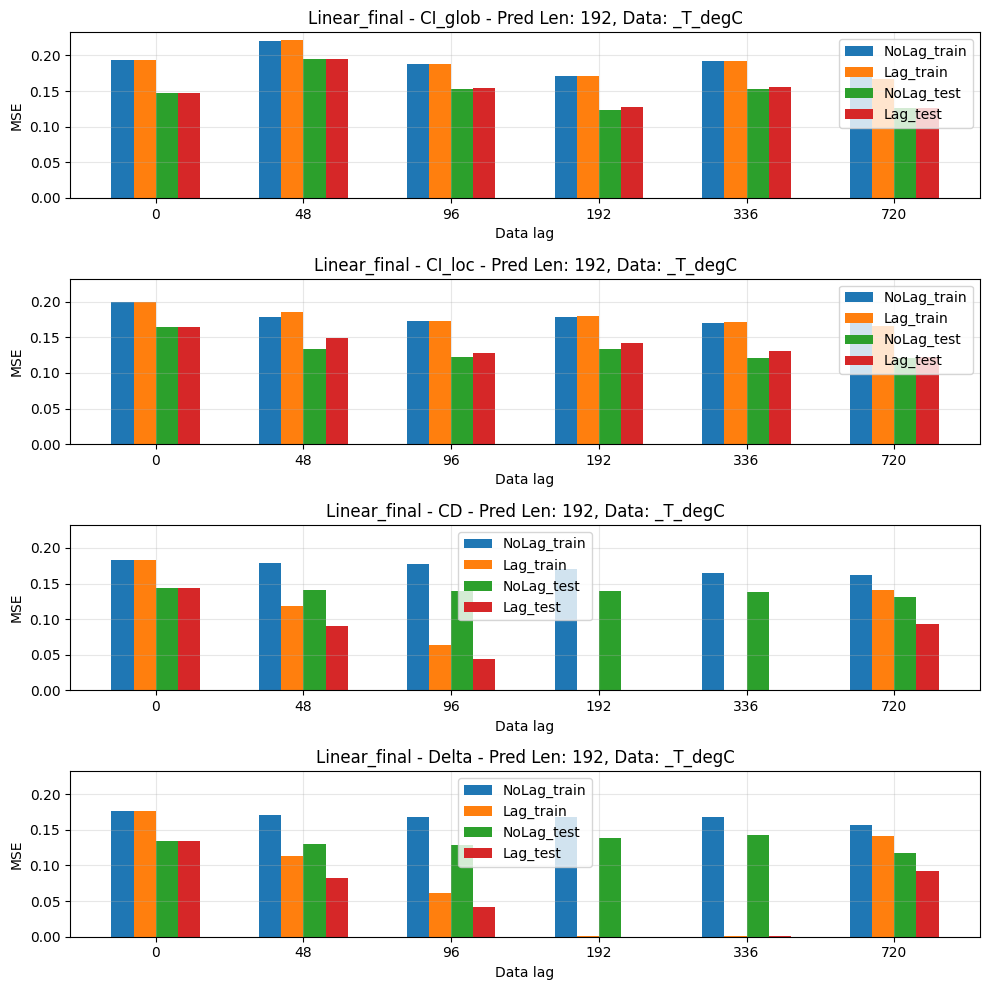

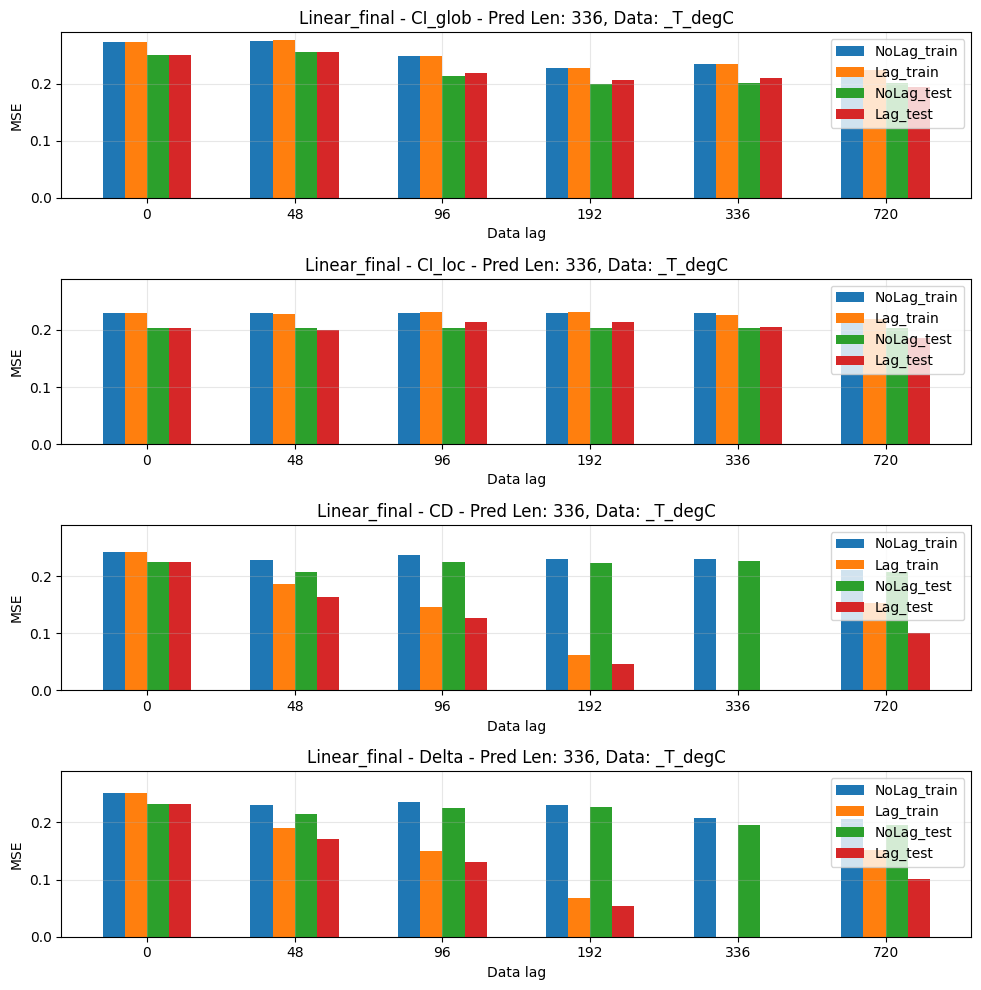

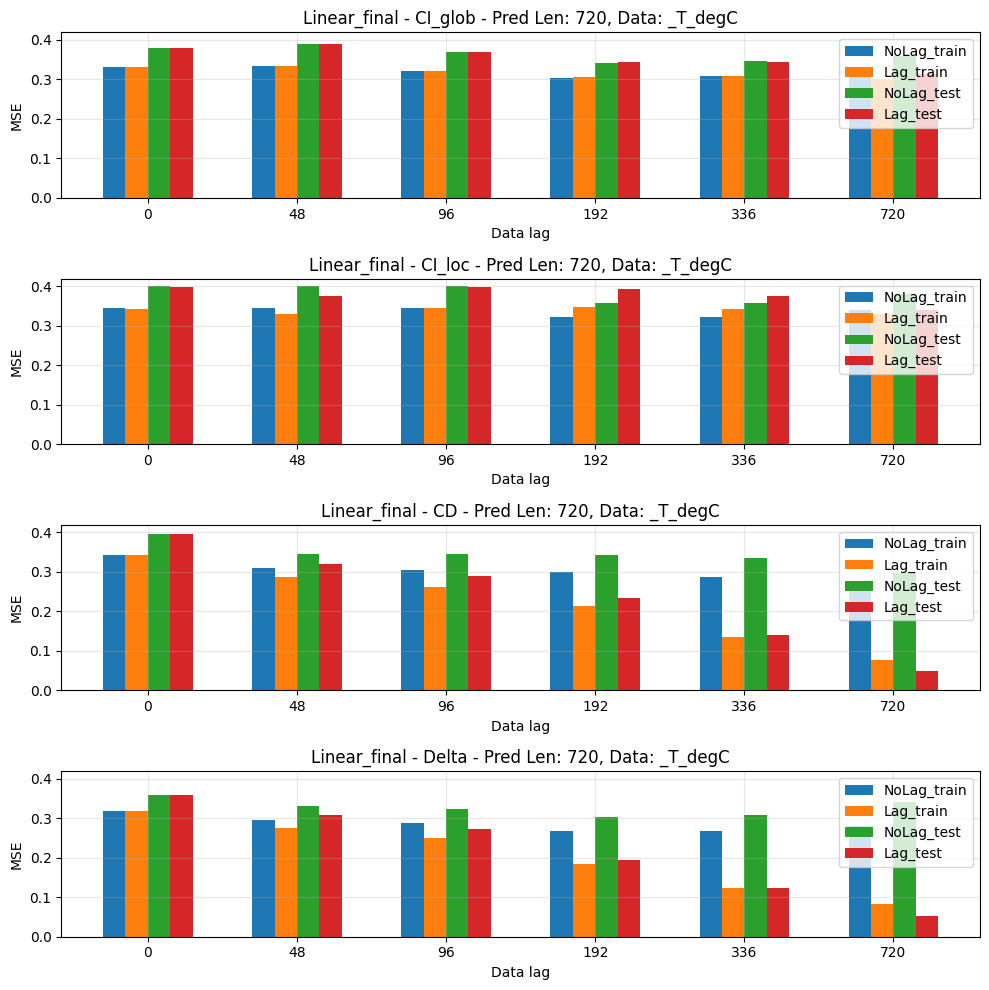

In [ ]:


for pred_len in [96, 192, 336, 720]:
    lag(model="Linear_final", data_path_list=["_T_degC"], pred_len=pred_len, df_subset=df_subset)

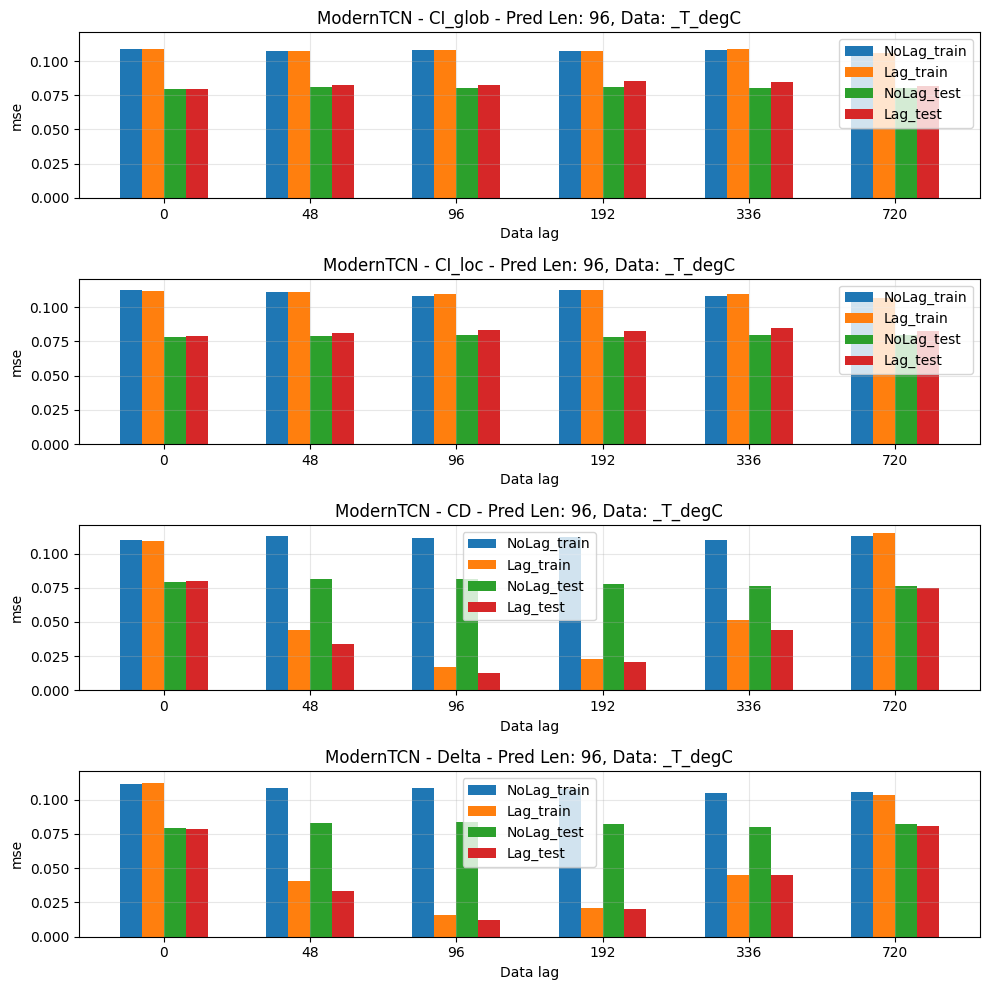

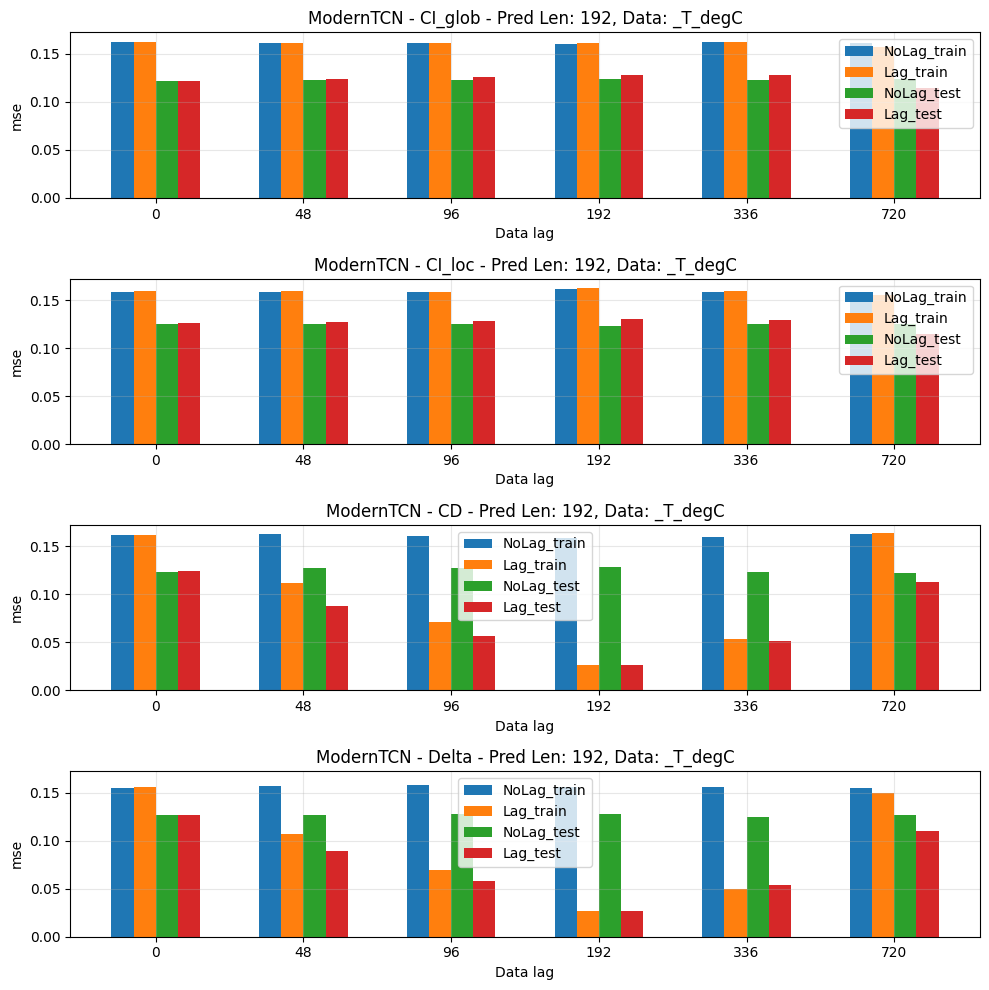

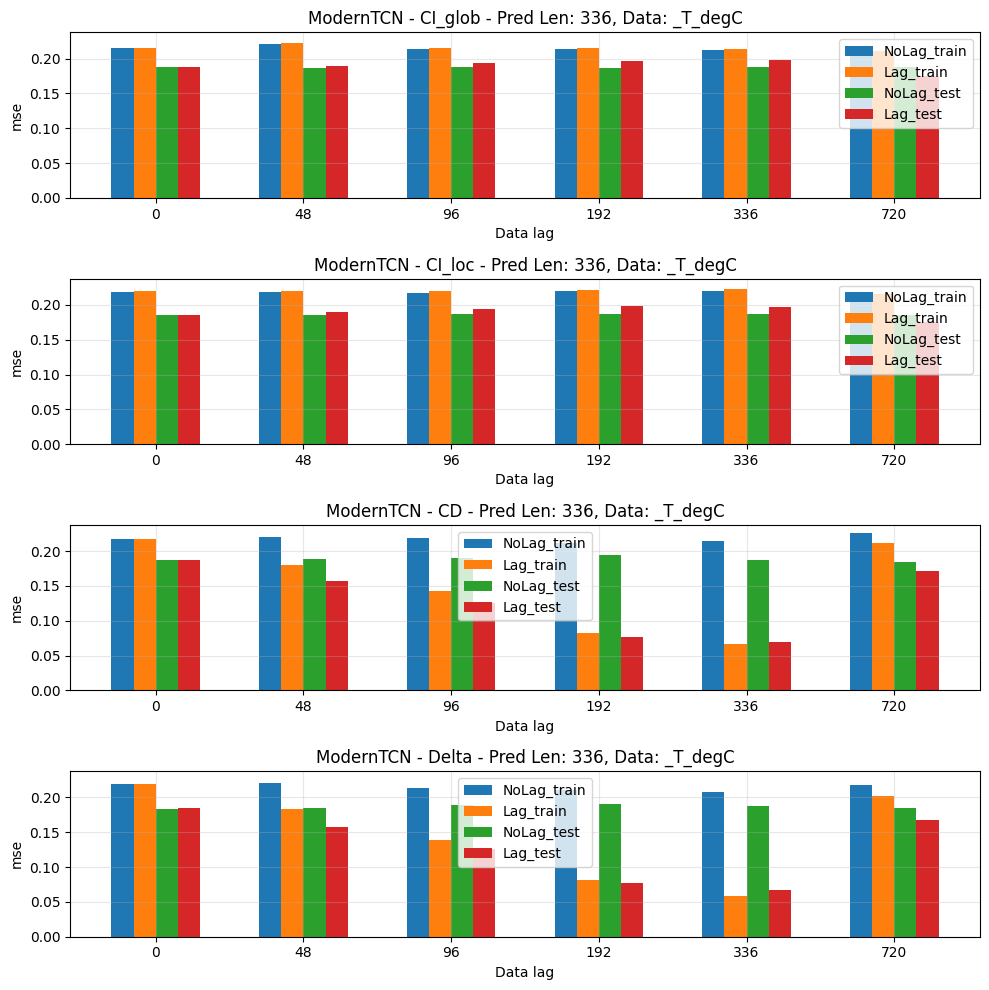

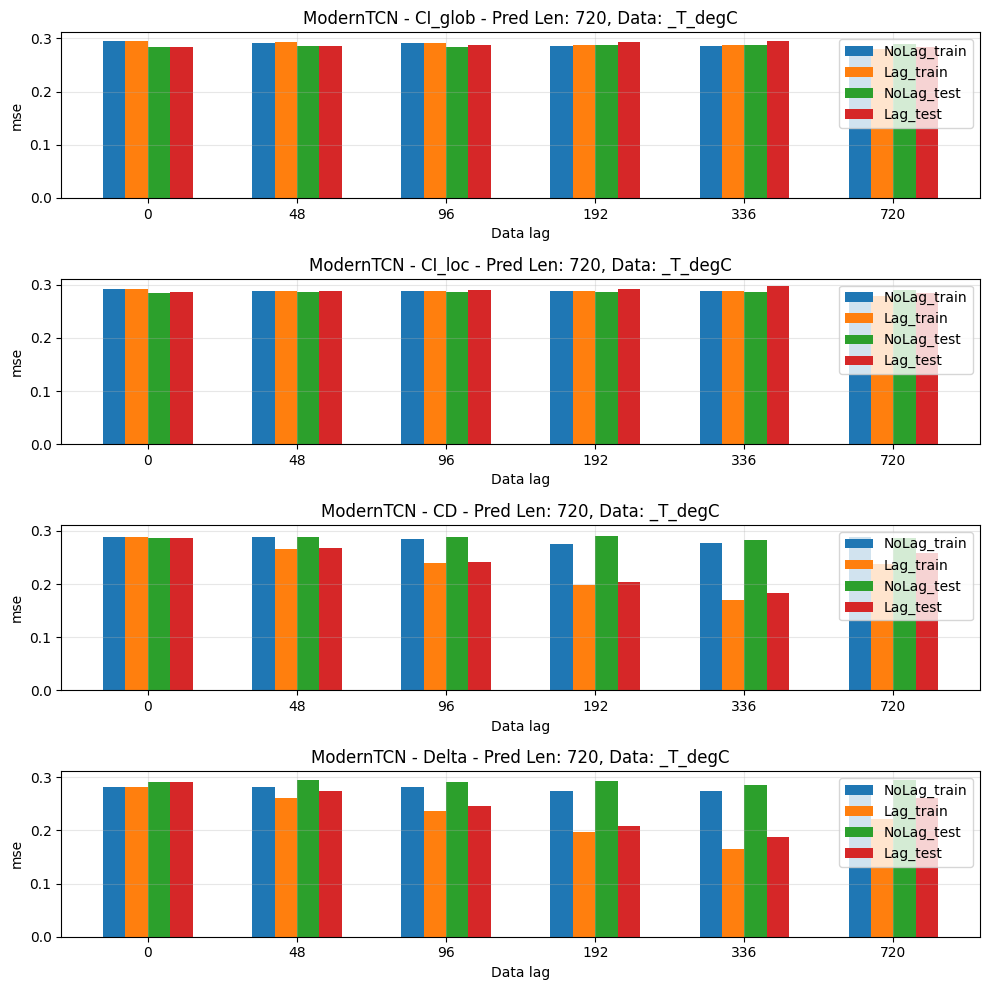

In [ ]:
for pred_len in [96, 192, 336, 720]:
    lag(model="ModernTCN", data_path_list=["_T_degC"], pred_len=pred_len)

In [79]:
base_path = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/checkpoints"

matches = [
    folder for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder)) and
        all(key in folder for key in ["PatchTST", "lectricity", "CI_glob"]) or 
        all(key in folder for key in ["PatchTST", "raffic", "CI_glob"]) 
]

matches = [
    folder for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder)) and
       all(key in folder for key in ["TCN", "lectricity", "_df0.5", "Delta"]) 
       #all(key in folder for key in ["TCN", "lectricity", "CI_glob"]) 
       #all(key in folder for key in ["TCN", "lectricity", "CD"])
]

matches = [
    folder for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder)) and
       all(key in folder for key in ["TCN", "raffic", "_df0.5", "Delta"])
       #all(key in folder for key in ["TCN", "raffic", "CI_glob"])
       #all(key in folder for key in ["TCN", "raffic", "CD"])
]


matches.sort()
print(len(matches))

""" """
for match in matches:
    print(match)


file_list = [
    "mse_per_channel_list.json",
]

base = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"

found = []

for match in matches:
    file_path = os.path.join(base, match, "mse_per_channel_list.json")
    if os.path.isfile(file_path):
        rs_match = re.search(r"rs(\d+)", match)
        pl_match = re.search(r"pl(\d+)", match)

        rs = int(rs_match.group(1)) if rs_match else None
        pl = int(pl_match.group(1)) if pl_match else None

        found.append(f"{rs}_{pl}")

        pass
    else:
        print(f"File not found: {file_path}")



20
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2022_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2023_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2024_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2025_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2022_chDelta_cdwd0.0_df0.5_p10_sk0_Exp_0
Traffic_336_336_Mo

In [117]:
found = []
not_found = []

base_path = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"


def check(matches):
    for match in matches:
        file_path = os.path.join(base, match, "mse_per_channel_list.json")
        if os.path.isfile(file_path):
            rs_match = re.search(r"rs(\d+)", match)
            pl_match = re.search(r"pl(\d+)", match)

            rs = int(rs_match.group(1)) if rs_match else None
            pl = int(pl_match.group(1)) if pl_match else None

            found.append(f"{rs}_{pl}")

            pass
        else:
            not_found.append(os.path.join(base, match))
            print(f"File not found: {file_path}")

def return_list(match):
    file_path = os.path.join(base, match, "mse_per_channel_list.json")
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


model_types = []

for pred_len in [96, 192, 336, 720]:
    for rseed in [2021, 2022, 2023, 2024, 2025]:
        for data_path in ["Traffic", "Electricity"]:
            print(pred_len, rseed, data_path)
            ### TCN CI
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "chCI_glob", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "CI_glob") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])
            
            ### TCN CD
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "chCD", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "CD") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])

            ### TCN Delta
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TCN", data_path[1:], "df0.5", "chDelta", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)
            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "ModernTCN")  & (df_subset['channel_handling'] == "Delta") 
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])

            ### Patch CI
            matches = [
                folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder)) and all(key in folder for key in ["TST", data_path[1:], "chCI_glob", f"rs{rseed}", f"336_{pred_len}"])
            ]
            print(matches)

            mask = (df_subset['data_path'] == data_path) & (df_subset['random_seed'] == rseed) & (df_subset['pred_len'] == pred_len) & (df_subset['model'] == "PatchTST")  & (df_subset['channel_handling'] == "CI_glob") 
            # Assign new values
            #display(df_subset.loc[mask, 'mse_per_channel_list'])
            idx = df_subset.index[mask][0]
            df_subset.at[idx, 'mse_per_channel_list'] = return_list(matches[0])
            #display(df_subset.loc[mask, 'mse_per_channel_list'])


96 2021 Traffic


['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_df1.0_p10_sk0_Exp_0']
['Traffic_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_Exp_0']
['traffic_336_96_PatchTST_custom_ftM_sl336_ll48_pl96_dm128_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
96 2021 Electricity
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_p10_sk0_Exp_0']
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_df1.0_p10_sk0_Exp_0']
['electricity_336_96_ModernTCN_custom_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.

In [104]:
display(df_subset[df_subset['data_path'] == "Traffic"])

model  pred_len  random_seed data_path       mae       mse  seq_len  \
716    PatchTST        96         2021   Traffic  0.250455  0.366679      336   
772    PatchTST       192         2021   Traffic  0.262552  0.388725      336   
774   ModernTCN        96         2021   Traffic  0.284663  0.413639      336   
776    PatchTST       336         2021   Traffic  0.265352  0.398039      336   
778    PatchTST       720         2021   Traffic  0.285277  0.433304      336   
...         ...       ...          ...       ...       ...       ...      ...   
8904  ModernTCN        96         2025   Traffic  0.284163  0.413210      336   
8905  ModernTCN       336         2025   Traffic  0.292199  0.437113      336   
8906  ModernTCN       720         2025   Traffic  0.309296  0.465641      336   
8907  ModernTCN       336         2024   Traffic  0.294483  0.437932      336   
8908  ModernTCN       720         2024   Traffic  0.310916  0.466255      336   

      cd_weight_decay  mse_train  mae_train  ... head_dropout dropout  \
716               0.0   0.211325   0.203288  ...          0.0     0.2   
772               0.0   0.223269   0.213380  ...          0.0     0.2   
774               0.0   0.248133   0.237601  ...          0.0     0.9   
776               0.0   0.230790   0.217165  ...          0.0     0.2   
778               0.0        NaN        NaN  ...          0.0     0.2   
...               ...        ...        ...  ...          ...     ...   
8904              0.0   0.248048   0.237444  ...          0.0     0.9   
8905              0.0   0.265545   0.245620  ...          0.0     0.9   
8906              0.0        NaN        NaN  ...          0.0     0.9   
8907              0.0   0.266137   0.247779  ...          0.0     0.9   
8908              0.0        NaN        NaN  ...          0.0     0.9   

     delta_factor skip_1st_epoch cw_mse_std  cw_mae_std  cw_mse_train_std  \
716           1.0            0.0        0.0         0.0               0.0   
772           1.0            0.0        0.0         0.0               0.0   
774           1.0            0.0        0.0         0.0               0.0   
776           1.0            0.0        0.0         0.0               0.0   
778           1.0            0.0        0.0         0.0               0.0   
...           ...            ...        ...         ...               ...   
8904          1.0            0.0        0.0         0.0               0.0   
8905          1.0            0.0        0.0         0.0               0.0   
8906          1.0            0.0        0.0         0.0               0.0   
8907          1.0            0.0        0.0         0.0               0.0   
8908          1.0            0.0        0.0         0.0               0.0   

      cw_mae_train_std  cw_mse_std_mean_quot  train_mse  
716                0.0                   0.0        NaN  
772                0.0                   0.0        NaN  
774                0.0                   0.0        NaN  
776                0.0                   0.0        NaN  
778                0.0                   0.0        NaN  
...                ...                   ...        ...  
8904               0.0                   0.0        NaN  
8905               0.0                   0.0        NaN  
8906               0.0                   0.0        NaN  
8907               0.0                   0.0        NaN  
8908               0.0                   0.0        NaN  

[80 rows x 28 columns]

In [20]:
my_list = found
seen = set()
duplicates = set()

for item in my_list:
    if item in seen:
        duplicates.add(item)
    else:
        seen.add(item)

print(list(duplicates))  # Output: ['a', 'b']


[]


In [2]:
import re

s = "Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2023_chCD_cdwd0.0_df1.0_p10_sk0_Exp_0"

# Extract values after 'rs' and 'pl'
rs_match = re.search(r"rs(\d+)", s)
pl_match = re.search(r"pl(\d+)", s)

rs = int(rs_match.group(1)) if rs_match else None
pl = int(pl_match.group(1)) if pl_match else None

print(rs)
print(pl)

2023
336


In [ ]:
import os
import json

base = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"
target = "electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/"
target_path = os.path.join(base, target)

file_list = [
    "mse_train_per_channel_list.json",
    "mse_per_channel_list.json",
    "mae_train_per_channel_list.json",
    "mae_per_channel_list.json"
]

for filename in file_list:
    file_path = os.path.join(target_path, filename)
    print(f"\n--- {filename} ---")
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
            print(data)
    except Exception as e:
        print(f"Error reading {filename}: {e}")



--- mse_train_per_channel_list.json ---
Error reading mse_train_per_channel_list.json: [Errno 2] No such file or directory: '/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/mse_train_per_channel_list.json'

--- mse_per_channel_list.json ---
[1.1540082693099976, 0.2644135653972626, 0.0002177944261347875, 0.15270425379276276, 0.3910791575908661, 0.14768019318580627, 1.2058324813842773, 0.16533857583999634, 0.27161818742752075, 0.603560745716095, 0.19879291951656342, 0.26834622025489807, 0.13946282863616943, 0.21940186619758606, 0.11976084858179092, 0.3142140507698059, 0.2500108778476715, 0.5309024453163147, 0.10304577648639679, 0.5235851407051086, 0.27337250113487244, 0.21309657394886017, 0.13580486178398132, 0.24508506059646606, 0.19141671061515808, 0.4933299422264099, 0.14371448755264282, 0.293767809867858